In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
from helper import *
import numpy as np
import scipy

In [2]:
architecture_name = "conv_autoencoder"

In [3]:
data = torch.from_numpy(getData("Data/rbcL_one_hot_encoding.txt", 50000)).float()

In [4]:
# sequences = torch.from_numpy(data).clone().detach().float()
sequences = data.permute(0, 2, 1)
print(sequences.shape)

torch.Size([50000, 5, 300])


In [3]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(5, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), 
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 5, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

class DNADataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx])

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ConvAutoEncoder().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# dataset = DNADataset(sequences)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# epochs = 20

# criterion = nn.MSELoss()
# outputs = []
# losses = []

# for epoch in range(epochs):
#     for batch in dataloader:
#         batch = batch.to(device)
#         reconstructed = model(batch)

#         loss = criterion(reconstructed, batch)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())
#     outputs.append((epochs, batch, reconstructed))
# print(f"Batch loss is {loss}")

# print("Training epoch {ep} done".format(ep=epoch))

# torch.save(model.state_dict(), f'{architecture_name}.pth')



In [4]:
device = torch.device('cpu')
model = ConvAutoEncoder()
model.load_state_dict(torch.load(f'{architecture_name}.pth', map_location=device))
model.eval()

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(64, 5, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): Sigmoid()
  )
)

In [8]:
embeddings = []
for seq in sequences:
    embedded_seq = model.encode(seq.unsqueeze(0))
    # embedded_seq = sklearn.preprocessing.normalize(embedded_seq.detach().numpy())
    embeddings.append(embedded_seq.detach().numpy())

In [9]:
embeddings = np.array(embeddings)

In [10]:
print(embeddings.shape)

(50000, 1, 32, 75)


In [11]:
embeddings = np.concatenate(embeddings, axis=0).reshape(50000, -1)

In [12]:
print(embeddings.shape)

(50000, 2400)


In [13]:
def KMeansOnEmbeddings(embeddings, n_clusters, seed=42, normalize=True):
    # define Kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, max_iter=1500)
    
    # run Kmeans
    cluster_labels = kmeans.fit_predict(embeddings)

    # count labels to see if the clusters look okay ish
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    for label, count in zip(unique_labels, label_counts):
        print(f"Label {label}: Count {count}")

    return cluster_labels, unique_labels

In [14]:
def pairWiseCrossValidation(data, sequences, model):
    sum_means = []
    for k in range(3, 50):
        cluster_labels, unique_labels = KMeansOnEmbeddings(data, k)
        means = []
        for ind in unique_labels:
            cluster_sequences = [sequences[i] for i, label in enumerate(cluster_labels) if label == unique_labels[ind]]
            
            means.append(np.mean(pairwise_distances(cluster_sequences, metric="cosine")))
        sum_means.append(np.mean(np.array(means)))
    return np.argmin(sum_means) + 3

In [22]:
# ordinal is faster and give the same results
sequences_list_ordinal = getData("Data/rbcL_ordinal_encoding.txt", 50000)
print(sequences_list_ordinal.shape)

(50000, 300)


In [25]:
num_clusters = pairWiseCrossValidation(embeddings, sequences_list_ordinal, model)

Label 0: Count 2747
Label 1: Count 4195
Label 2: Count 43058
Label 0: Count 2747
Label 1: Count 36892
Label 2: Count 7618
Label 3: Count 2743
Label 0: Count 2744
Label 1: Count 2747
Label 2: Count 3371
Label 3: Count 39083
Label 4: Count 2055
Label 0: Count 2742
Label 1: Count 3479
Label 2: Count 2626
Label 3: Count 22470
Label 4: Count 2747
Label 5: Count 15936
Label 0: Count 1993
Label 1: Count 2747
Label 2: Count 16767
Label 3: Count 4109
Label 4: Count 20798
Label 5: Count 1845
Label 6: Count 1741
Label 0: Count 1741
Label 1: Count 2741
Label 2: Count 14783
Label 3: Count 20284
Label 4: Count 1421
Label 5: Count 2624
Label 6: Count 2747
Label 7: Count 3659
Label 0: Count 13810
Label 1: Count 2741
Label 2: Count 1200
Label 3: Count 2747
Label 4: Count 20079
Label 5: Count 2713
Label 6: Count 2622
Label 7: Count 1741
Label 8: Count 2347
Label 0: Count 19966
Label 1: Count 2741
Label 2: Count 1421
Label 3: Count 2747
Label 4: Count 2619
Label 5: Count 1281
Label 6: Count 1796
Label 7:

In [26]:
print(num_clusters)

43


In [14]:
num_clusters = 43

In [15]:
cluster_labels, unique_labels = KMeansOnEmbeddings(embeddings, num_clusters)

Label 0: Count 3066
Label 1: Count 514
Label 2: Count 1441
Label 3: Count 1546
Label 4: Count 597
Label 5: Count 323
Label 6: Count 552
Label 7: Count 532
Label 8: Count 1741
Label 9: Count 336
Label 10: Count 641
Label 11: Count 783
Label 12: Count 568
Label 13: Count 972
Label 14: Count 495
Label 15: Count 769
Label 16: Count 743
Label 17: Count 342
Label 18: Count 665
Label 19: Count 640
Label 20: Count 11010
Label 21: Count 330
Label 22: Count 1161
Label 23: Count 1547
Label 24: Count 241
Label 25: Count 224
Label 26: Count 754
Label 27: Count 8032
Label 28: Count 252
Label 29: Count 672
Label 30: Count 2233
Label 31: Count 420
Label 32: Count 434
Label 33: Count 882
Label 34: Count 516
Label 35: Count 961
Label 36: Count 604
Label 37: Count 799
Label 38: Count 552
Label 39: Count 314
Label 40: Count 181
Label 41: Count 281
Label 42: Count 334


In [34]:
decodeSequencesRange(architecture_name, 0, num_clusters, data, one_hot_decoder, unique_labels, cluster_labels)

In [35]:
runClustalRange(architecture_name, 0, num_clusters, unique_labels, True)

Using 16 threads
Read 3066 sequences (type: DNA) from clusters/conv_autoencoder/cluster_0.fasta
Using 134 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 3066 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress: 0 % (0 out of 401933)
Ktuple-distance calculation progress: 9 % (37572 out of 401933)
Ktuple-distance calculation progress: 10 % (42616 out of 401933)
Ktuple-distance calculation progress: 11 % (46769 out of 401933)
Ktuple-distance calculation progress: 12 % (48272 out of 401933)
Ktuple-distance calculation progress: 13 % (53941 out of 401933)
Ktuple-distance calculation progress: 17 % (70018 out of 401933)
Ktuple-distance calculation progress: 20 % (81131 out of 401933)
Ktuple-distance calculation progress: 22 % (89154 out of 401933)
Ktuple-distance calculation progress: 24 % (98274 out of 401933)
Ktuple-distance calculation progress: 25 % (100991 out of 401933)
Ktuple-distance calculation progress: 26 

In [17]:
percentages = evaluateGapsInRange(architecture_name, 0, num_clusters, unique_labels)

clustal/conv_autoencoder/cluster_0.clustal
Percentage of gaps in the alignment for cluster 0: 64.80%
clustal/conv_autoencoder/cluster_1.clustal
Percentage of gaps in the alignment for cluster 1: 0.84%
clustal/conv_autoencoder/cluster_2.clustal
Percentage of gaps in the alignment for cluster 2: 0.84%
clustal/conv_autoencoder/cluster_3.clustal
Percentage of gaps in the alignment for cluster 3: 15.98%
clustal/conv_autoencoder/cluster_4.clustal
Percentage of gaps in the alignment for cluster 4: 1.40%
clustal/conv_autoencoder/cluster_5.clustal
Percentage of gaps in the alignment for cluster 5: 0.29%
clustal/conv_autoencoder/cluster_6.clustal
Percentage of gaps in the alignment for cluster 6: 1.95%
clustal/conv_autoencoder/cluster_7.clustal
Percentage of gaps in the alignment for cluster 7: 8.90%
clustal/conv_autoencoder/cluster_8.clustal
Percentage of gaps in the alignment for cluster 8: 0.84%
clustal/conv_autoencoder/cluster_9.clustal
Percentage of gaps in the alignment for cluster 9: 1.49

In [37]:
countPercentageLowerThan(percentages, 10)

30

Plot for cluster 0


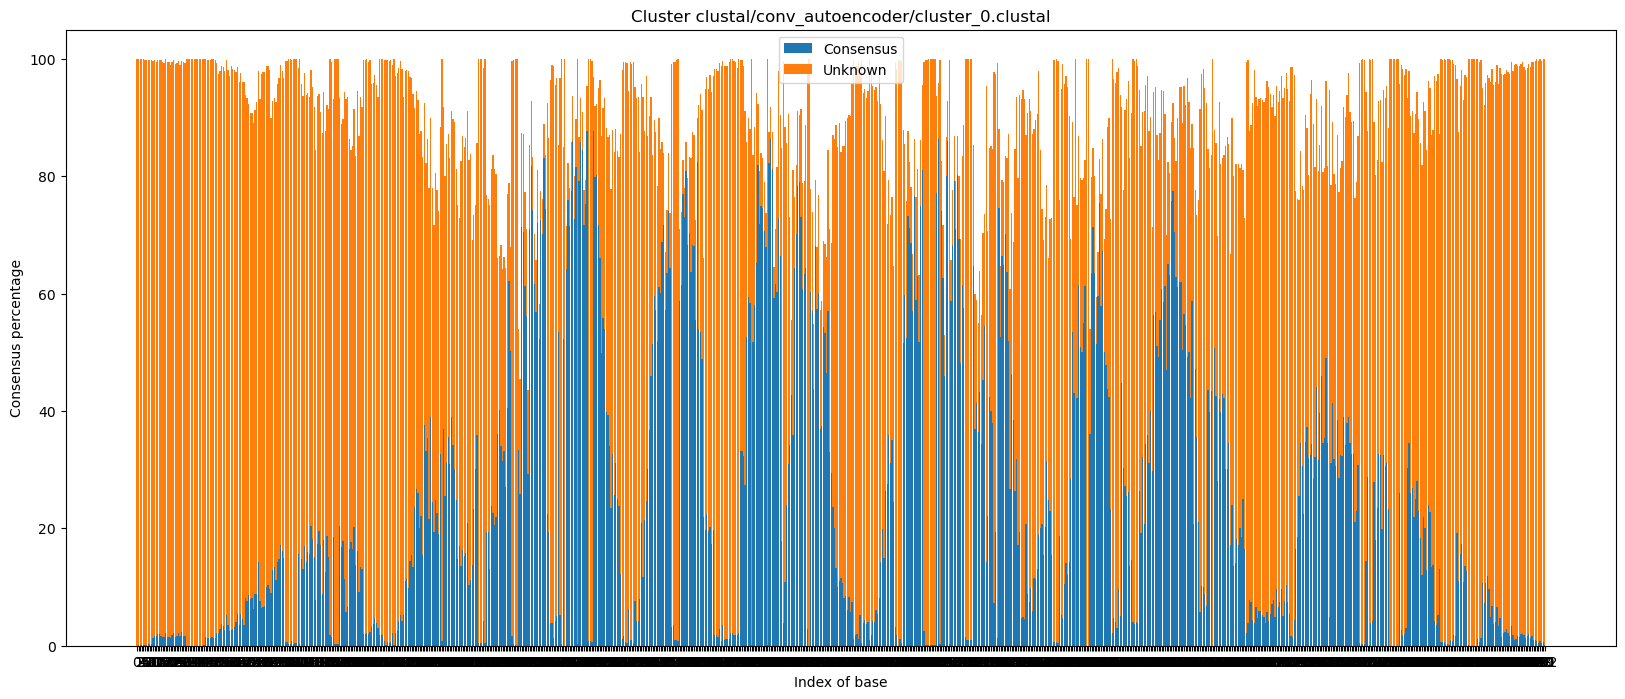

Plot for cluster 1


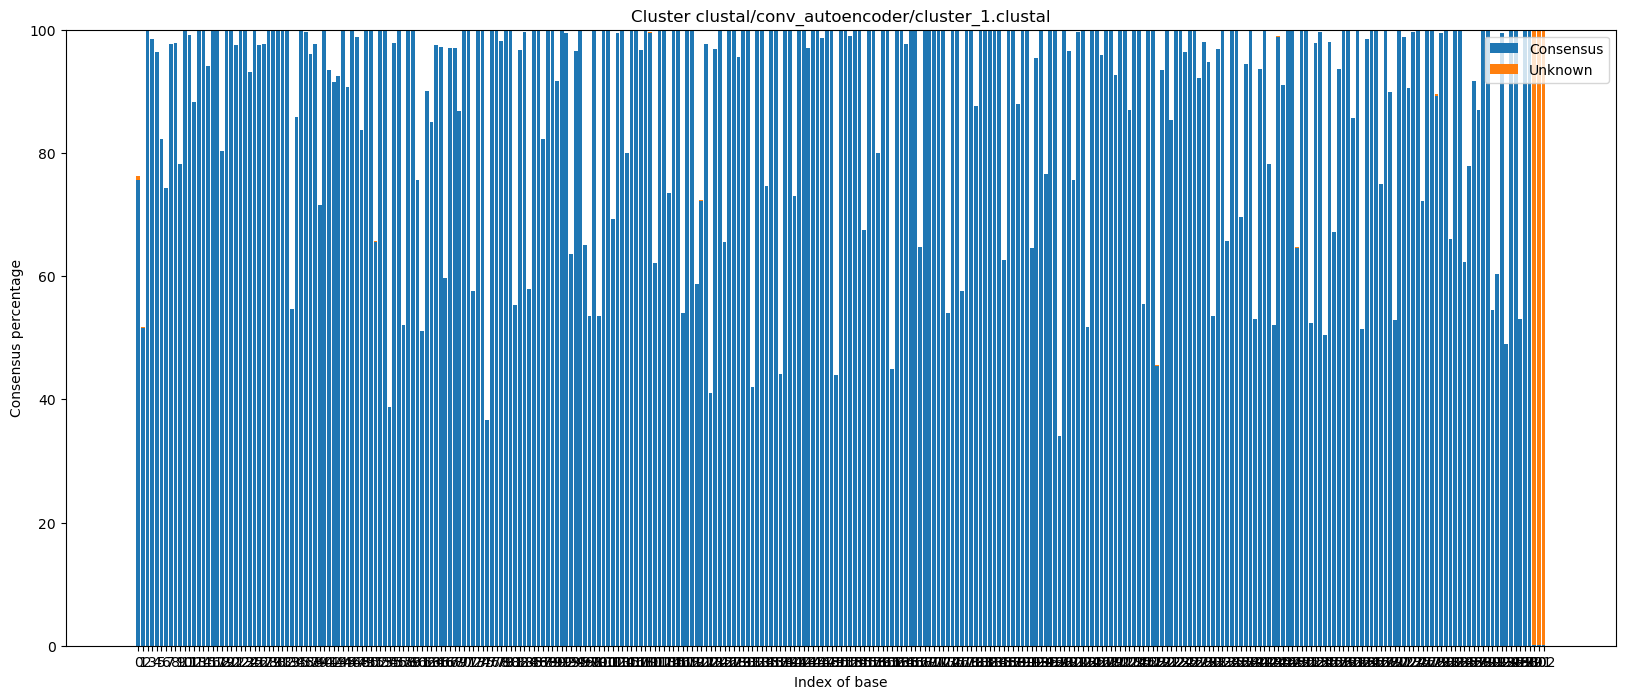

Plot for cluster 2


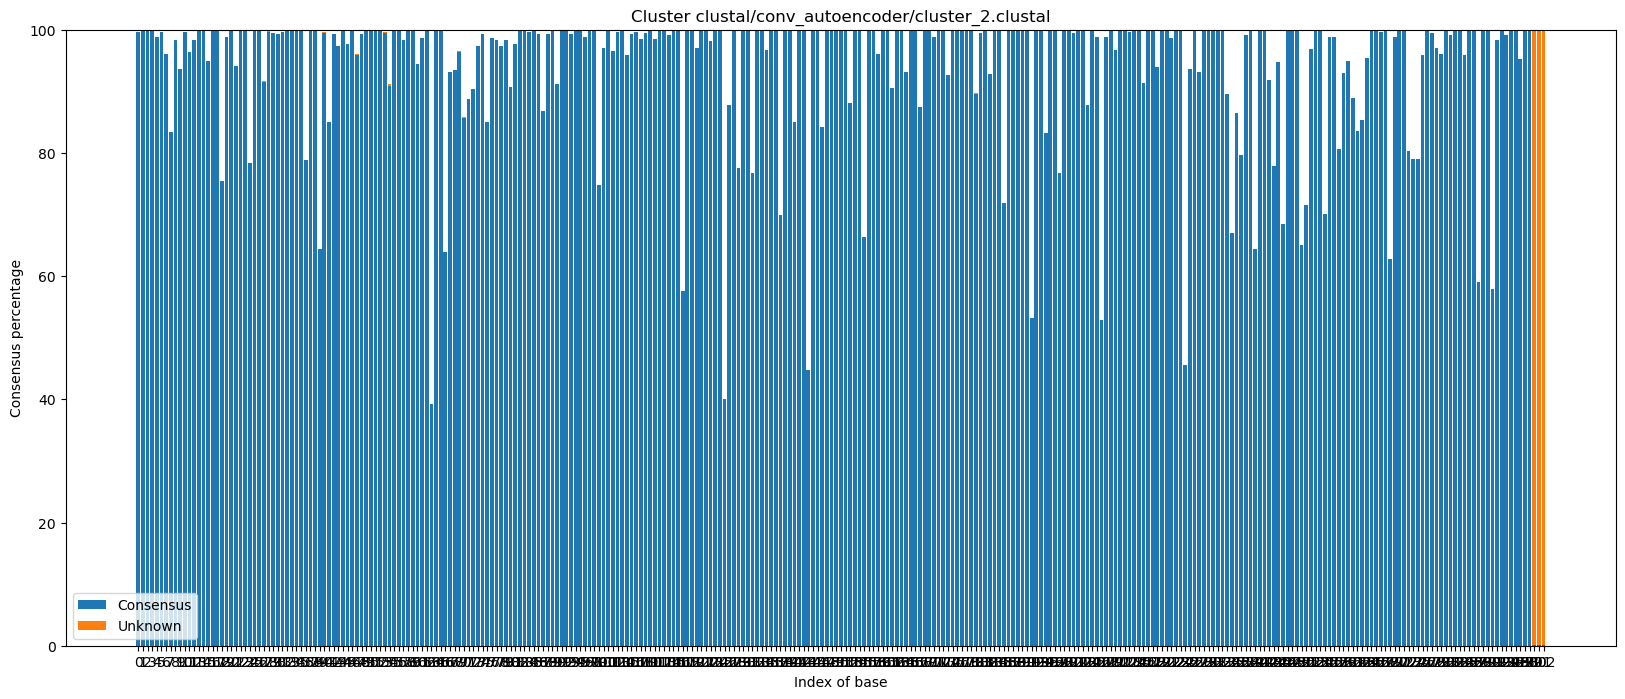

Plot for cluster 3


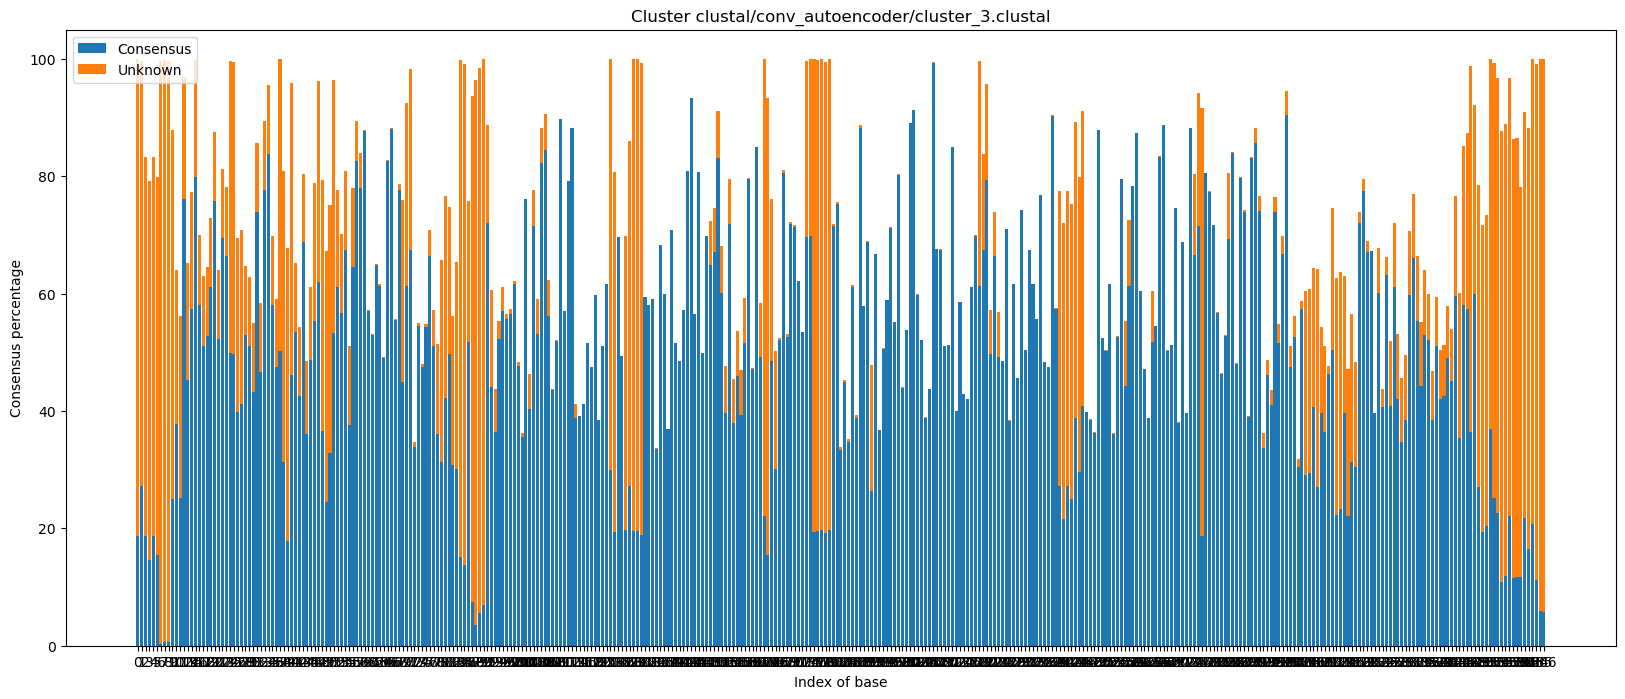

Plot for cluster 4


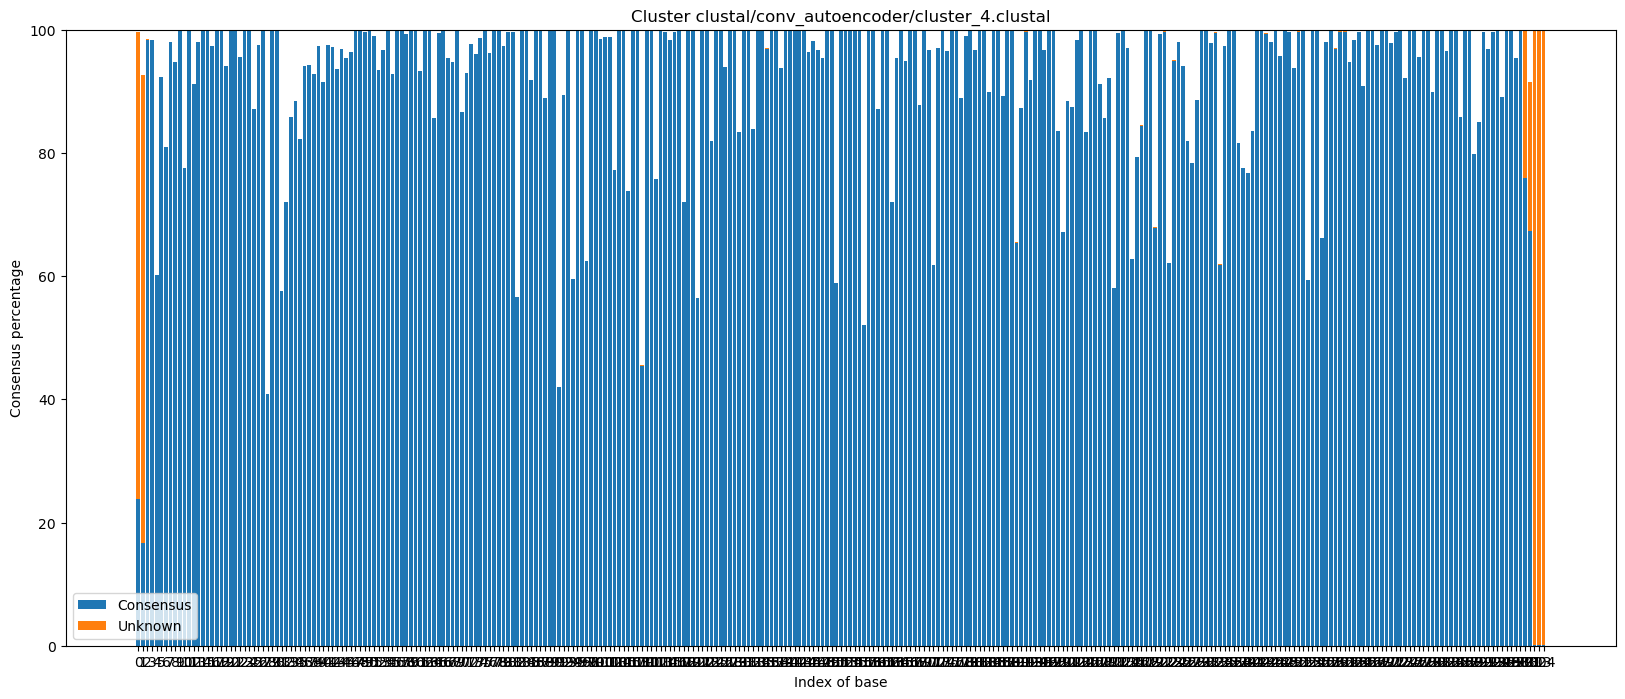

Plot for cluster 5


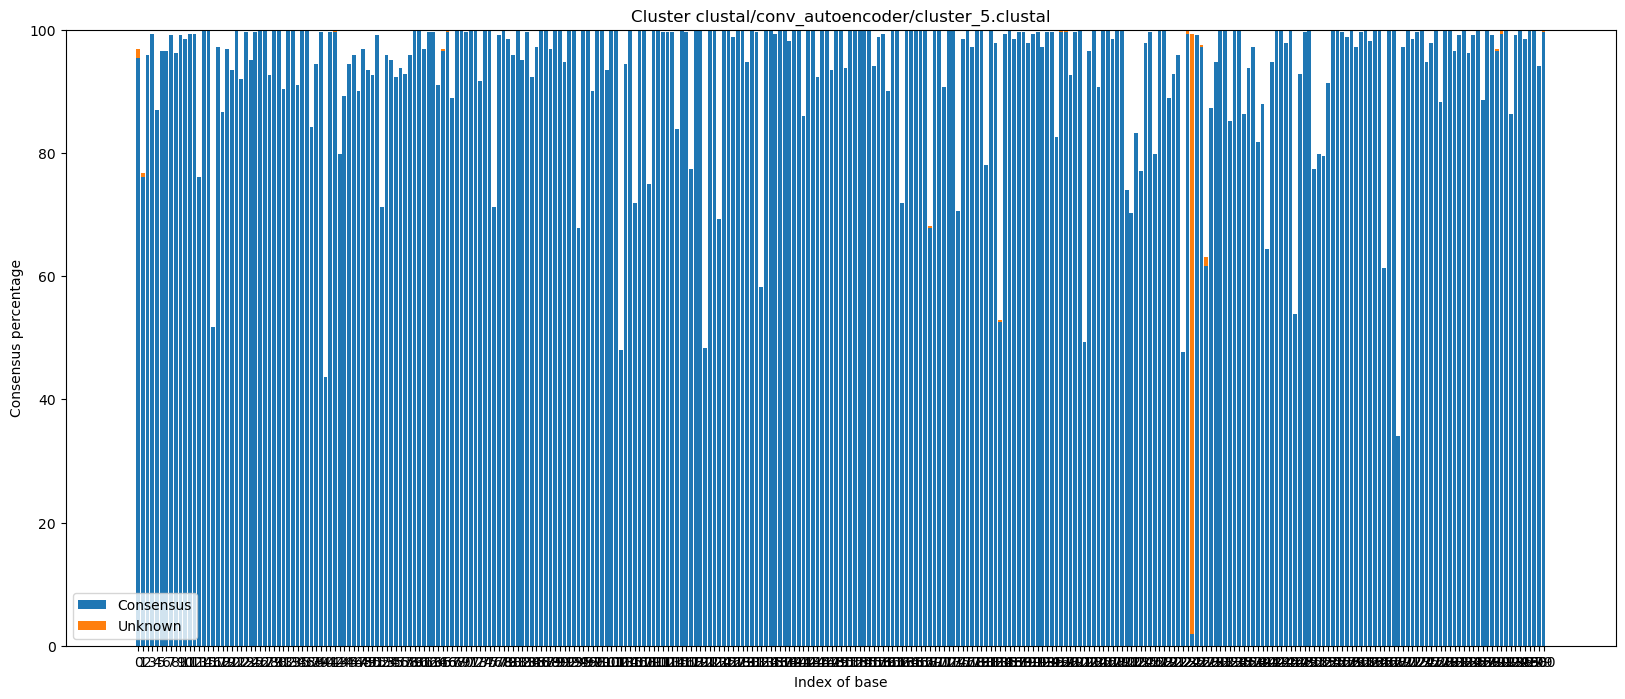

Plot for cluster 6


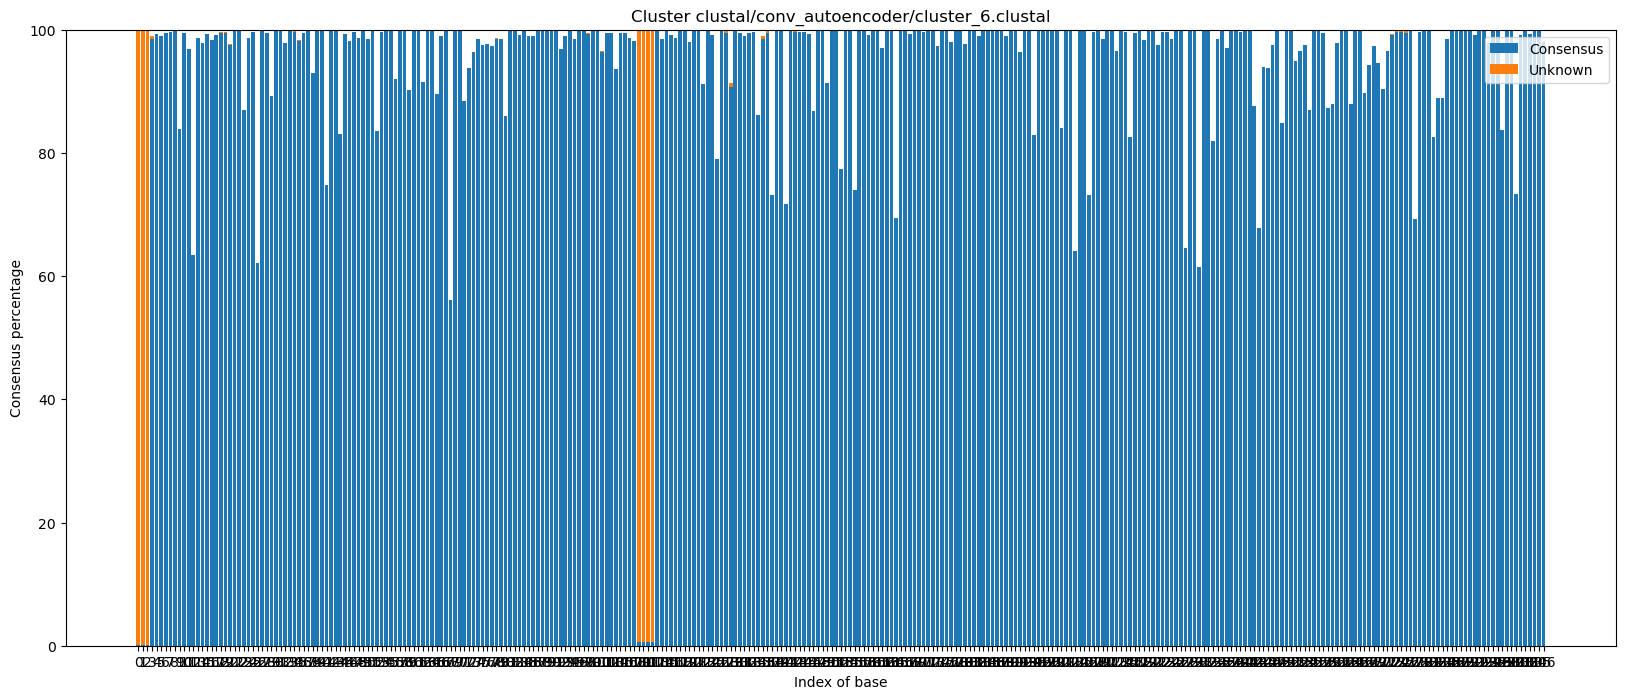

Plot for cluster 7


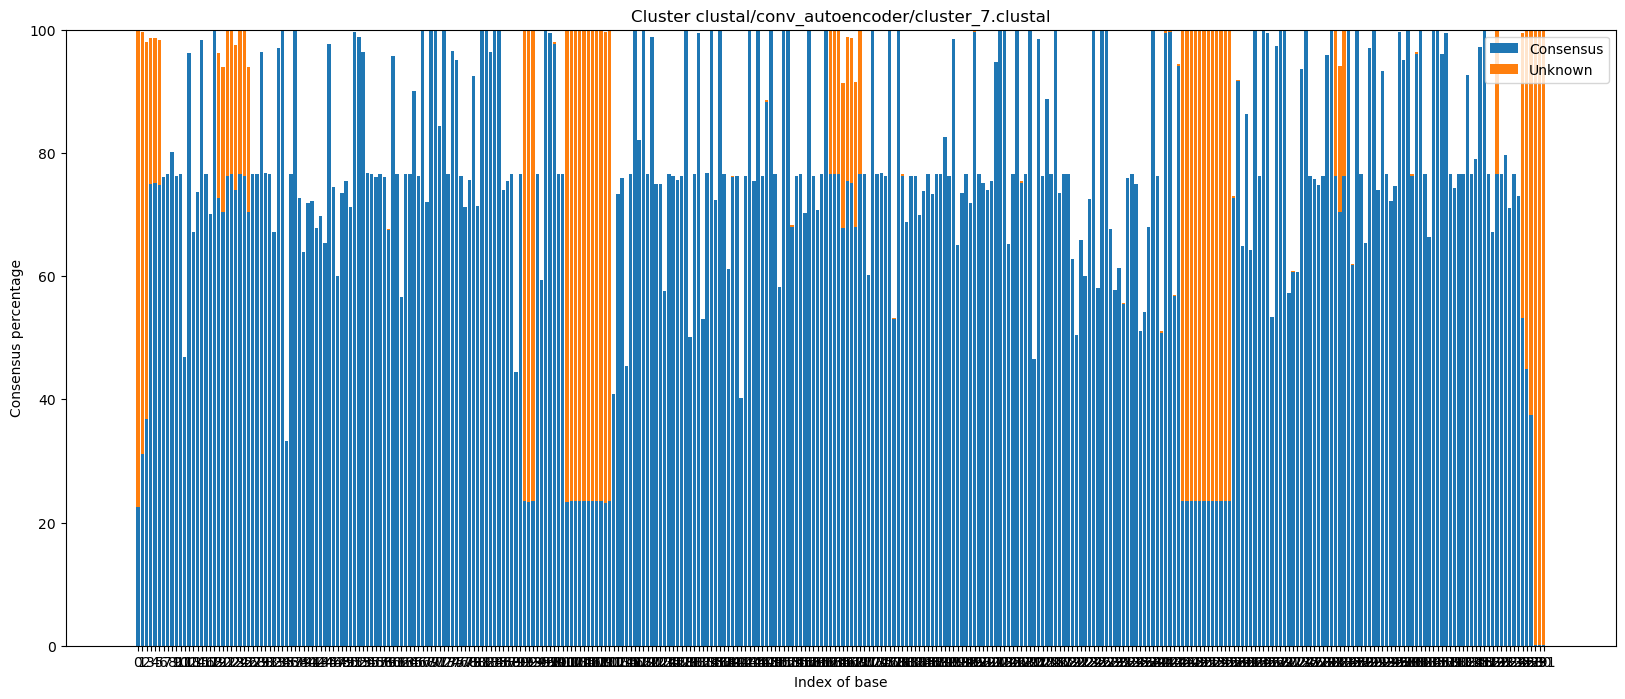

Plot for cluster 8


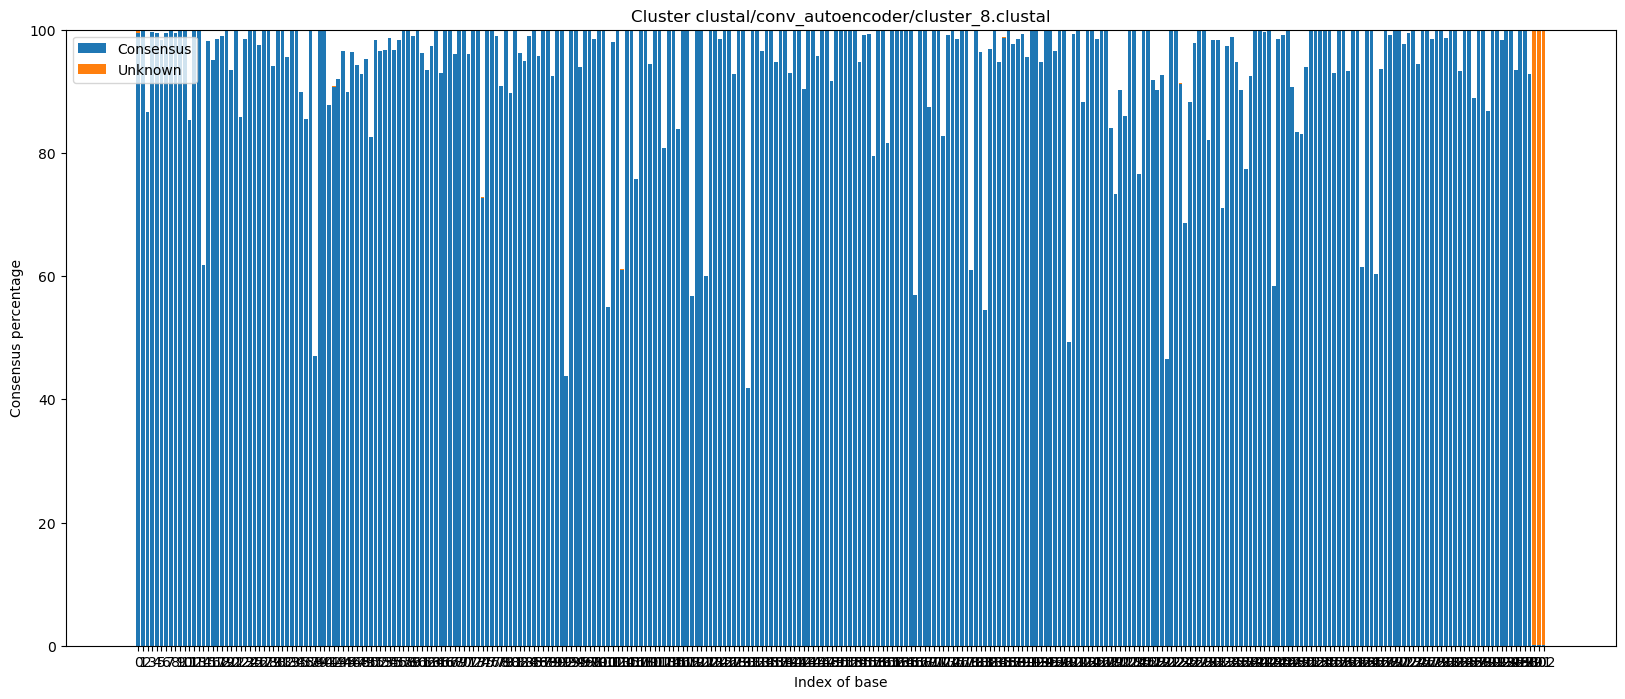

Plot for cluster 9


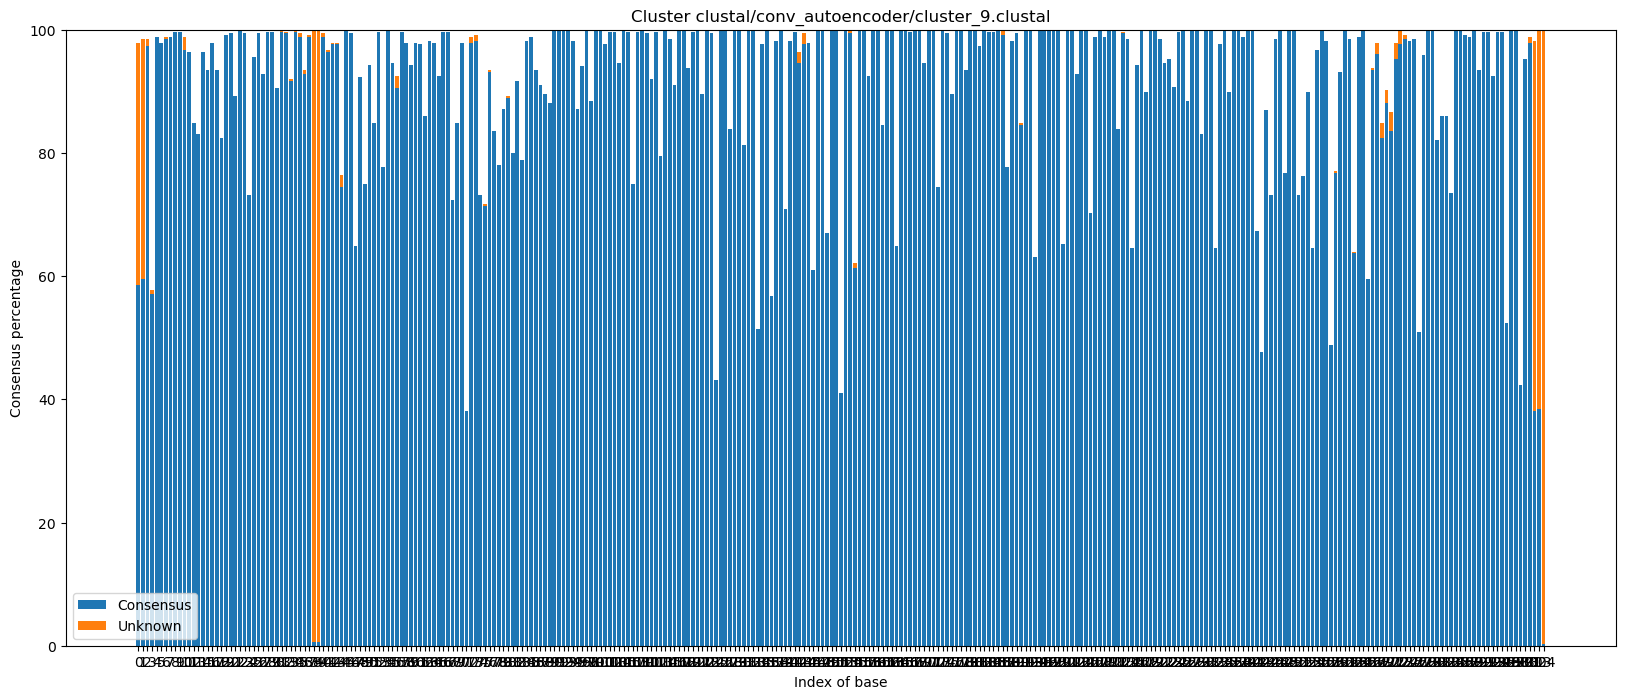

Plot for cluster 10


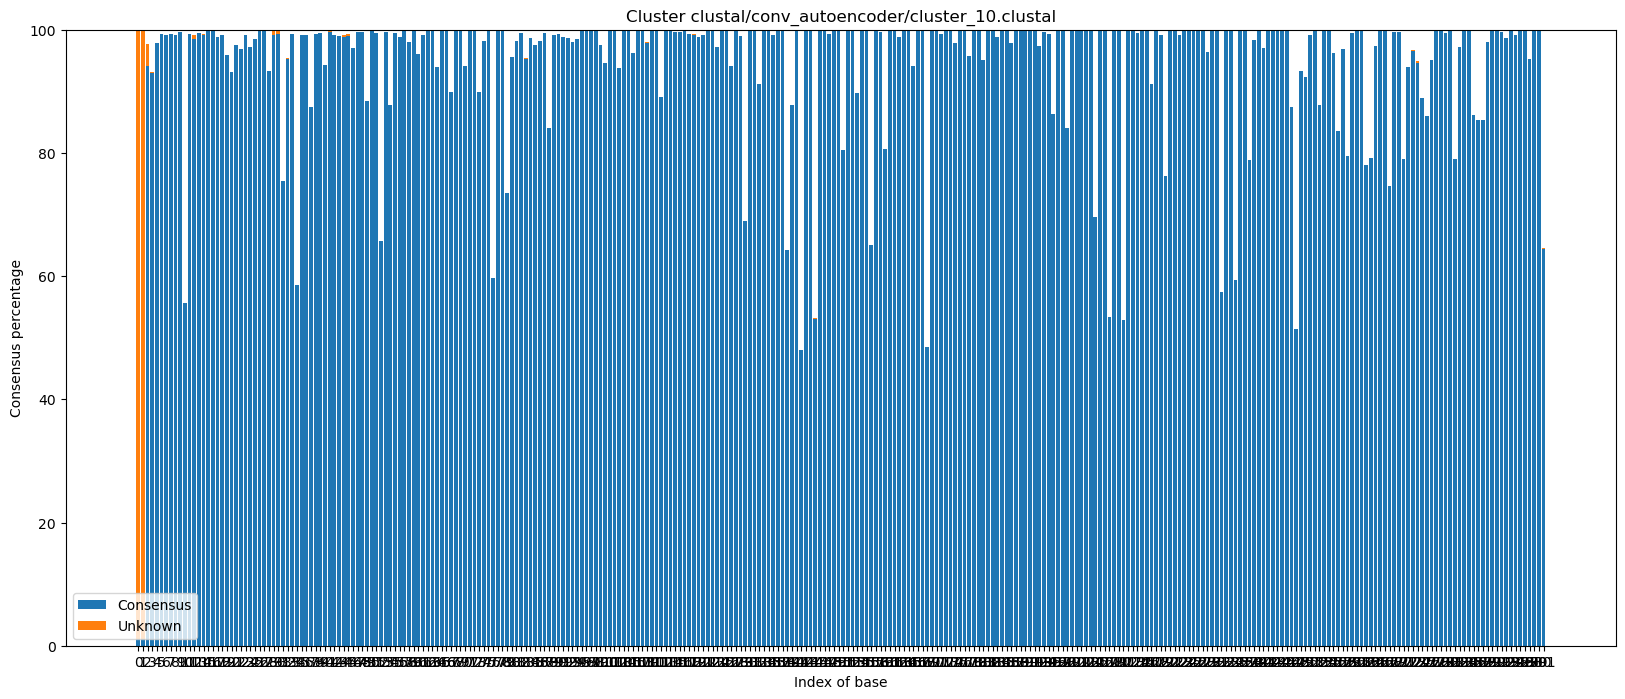

Plot for cluster 11


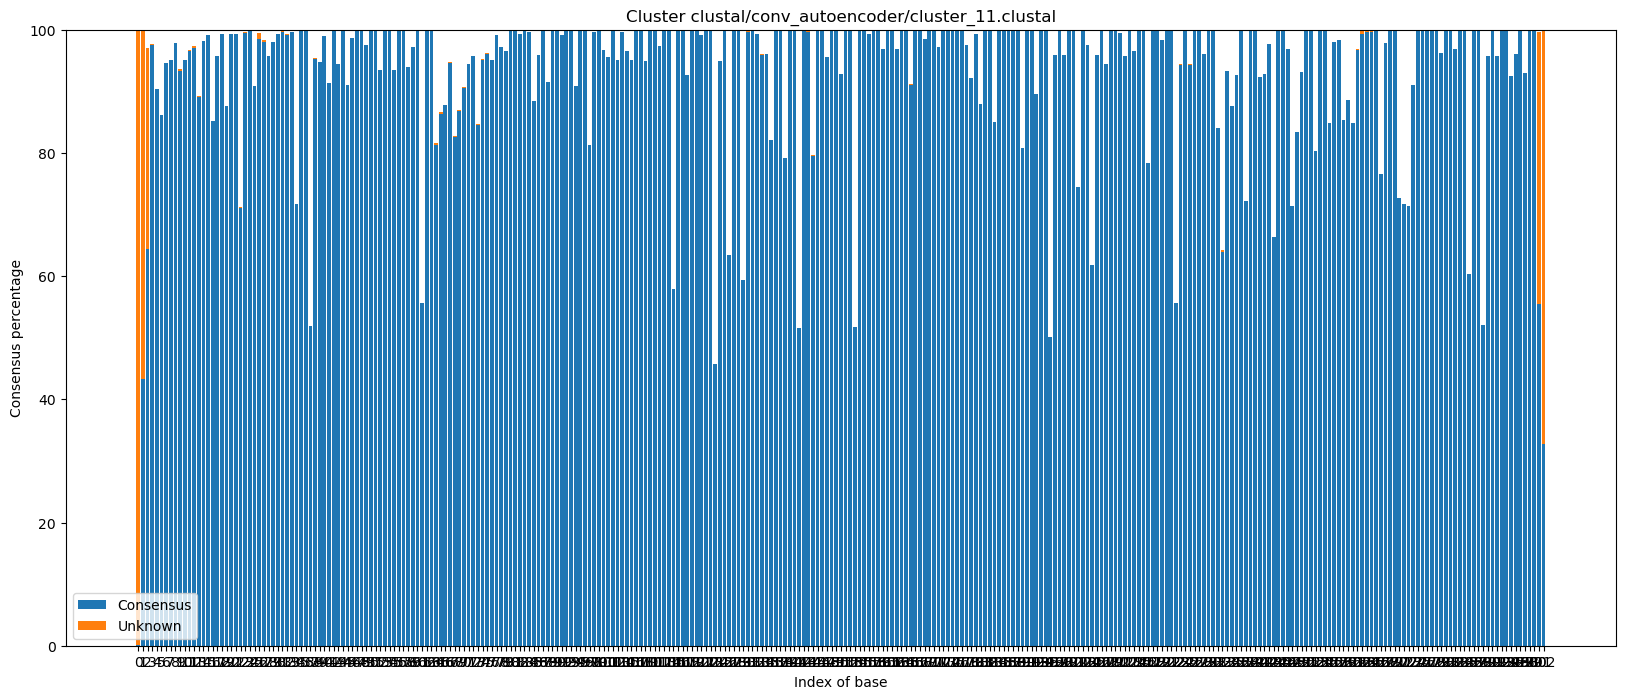

Plot for cluster 12


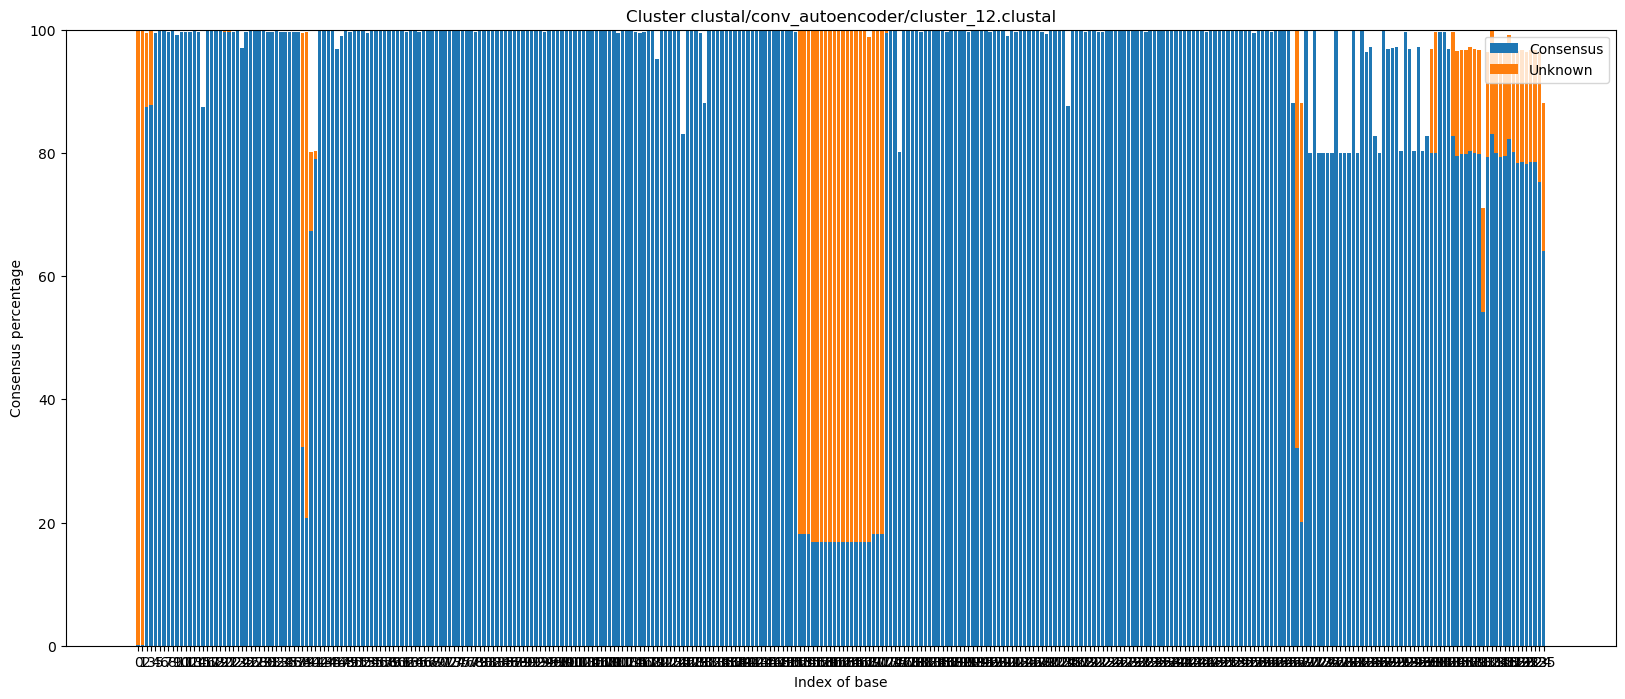

Plot for cluster 13


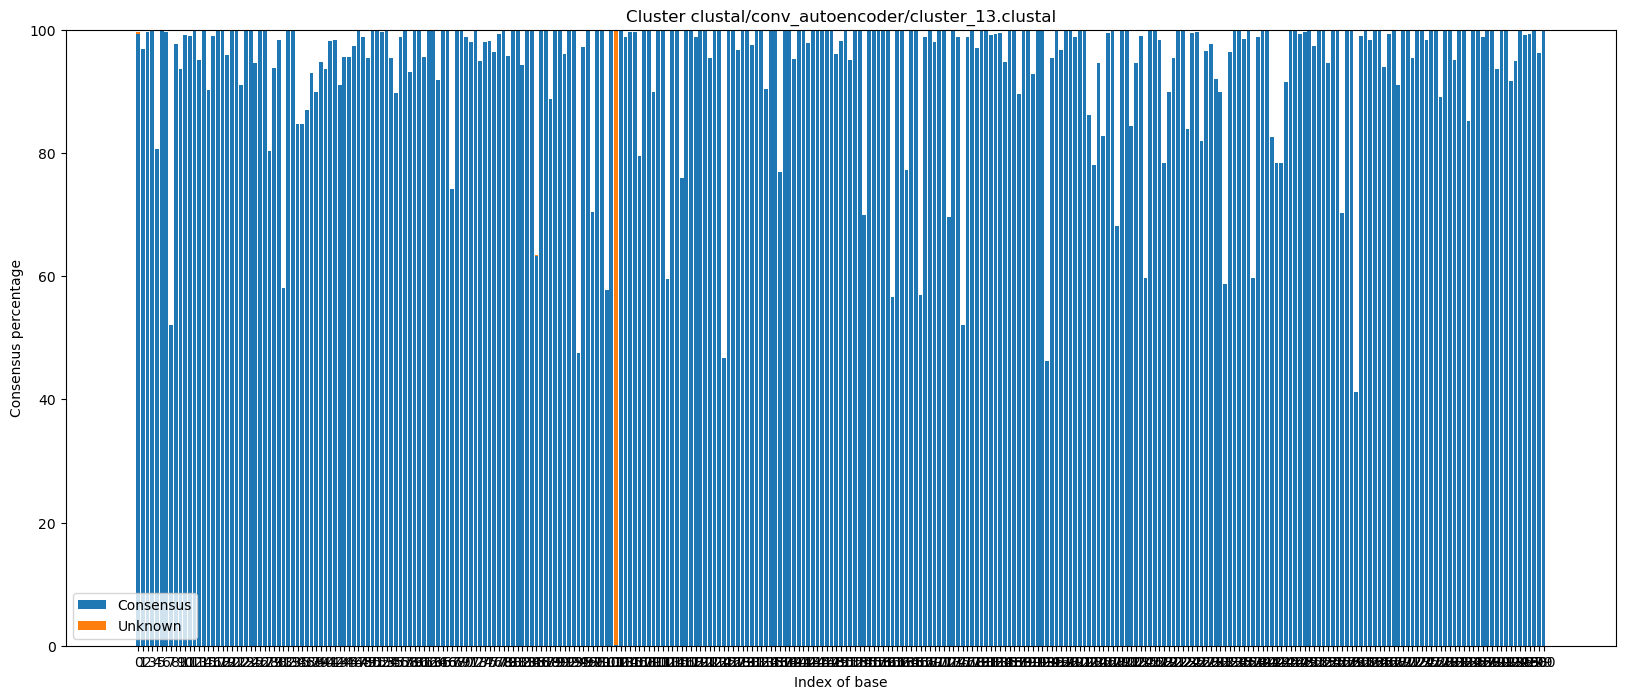

Plot for cluster 14


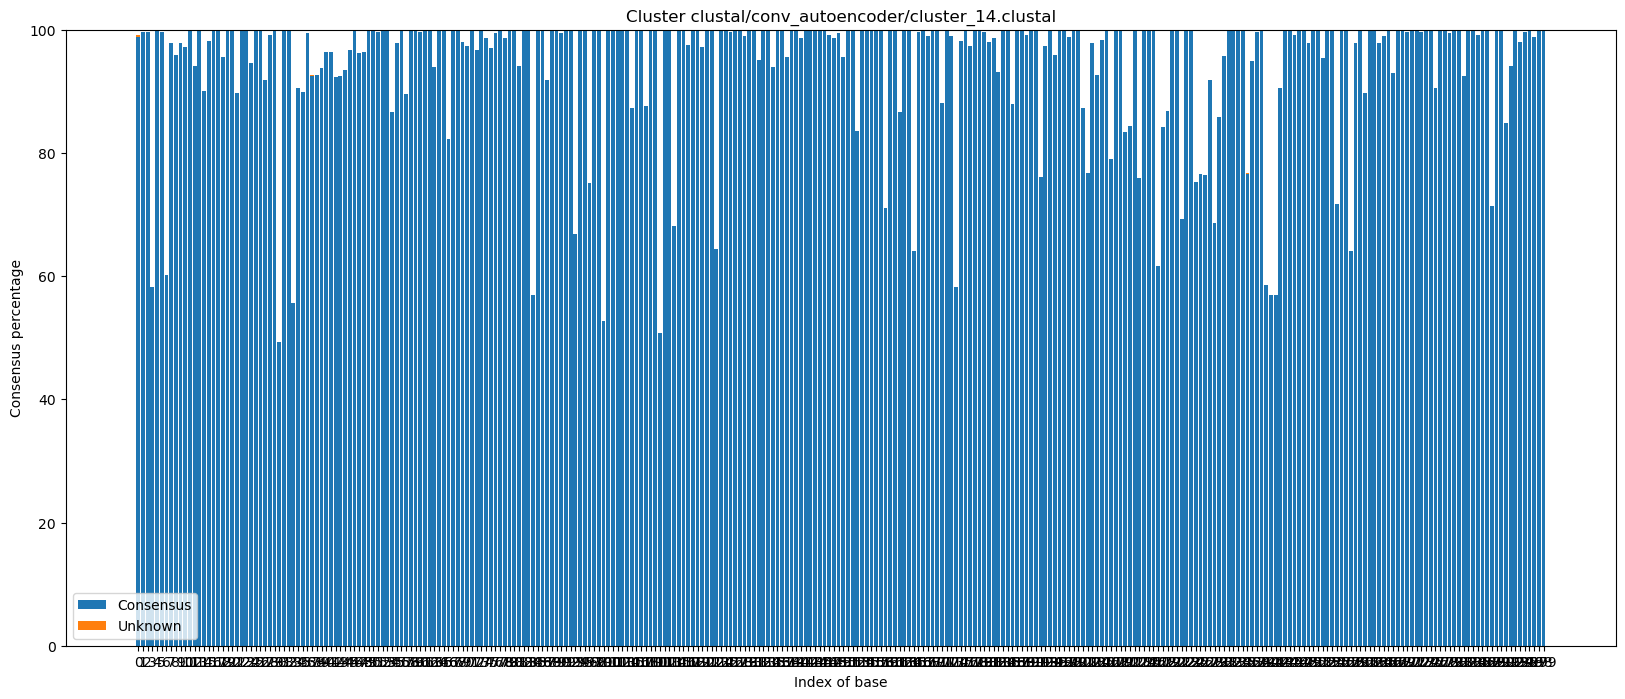

Plot for cluster 15


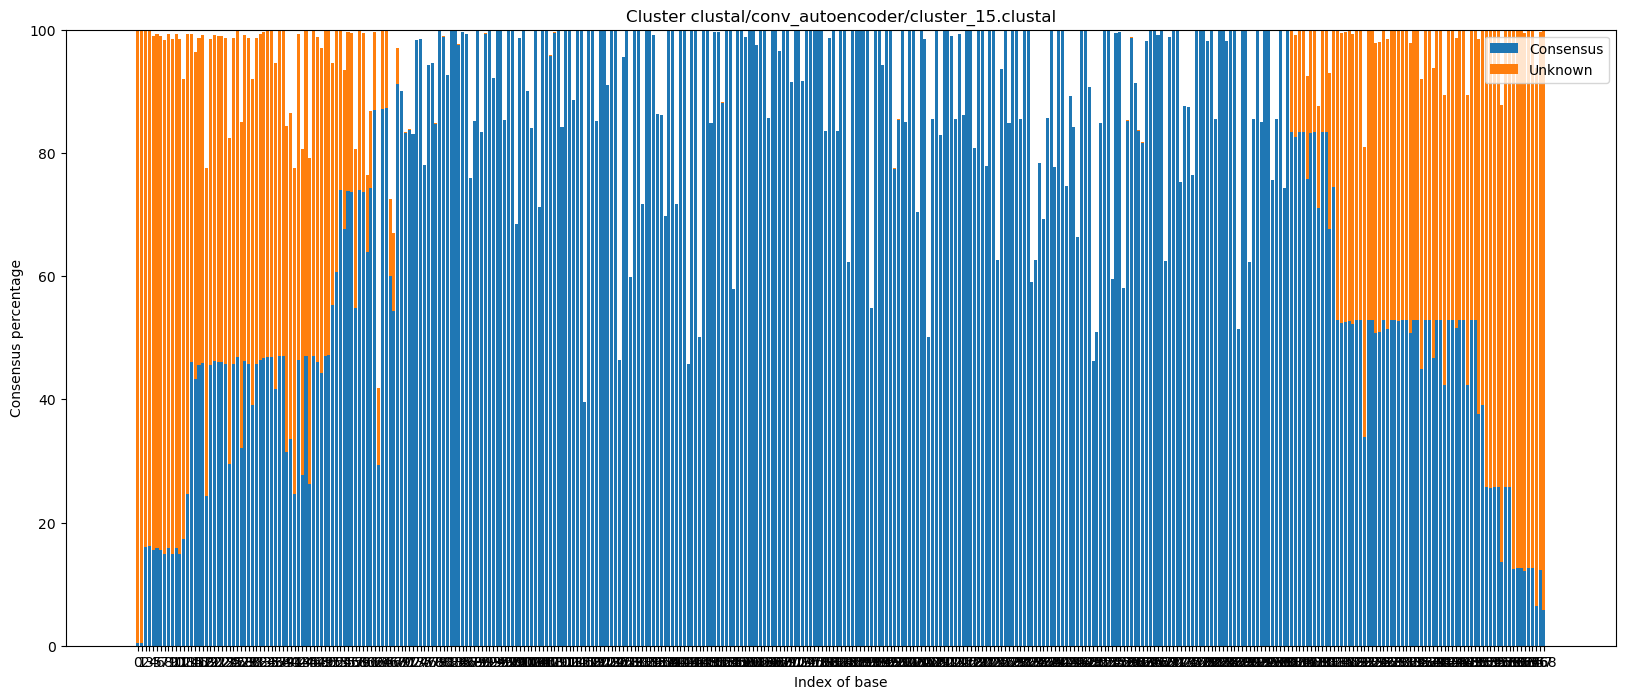

Plot for cluster 16


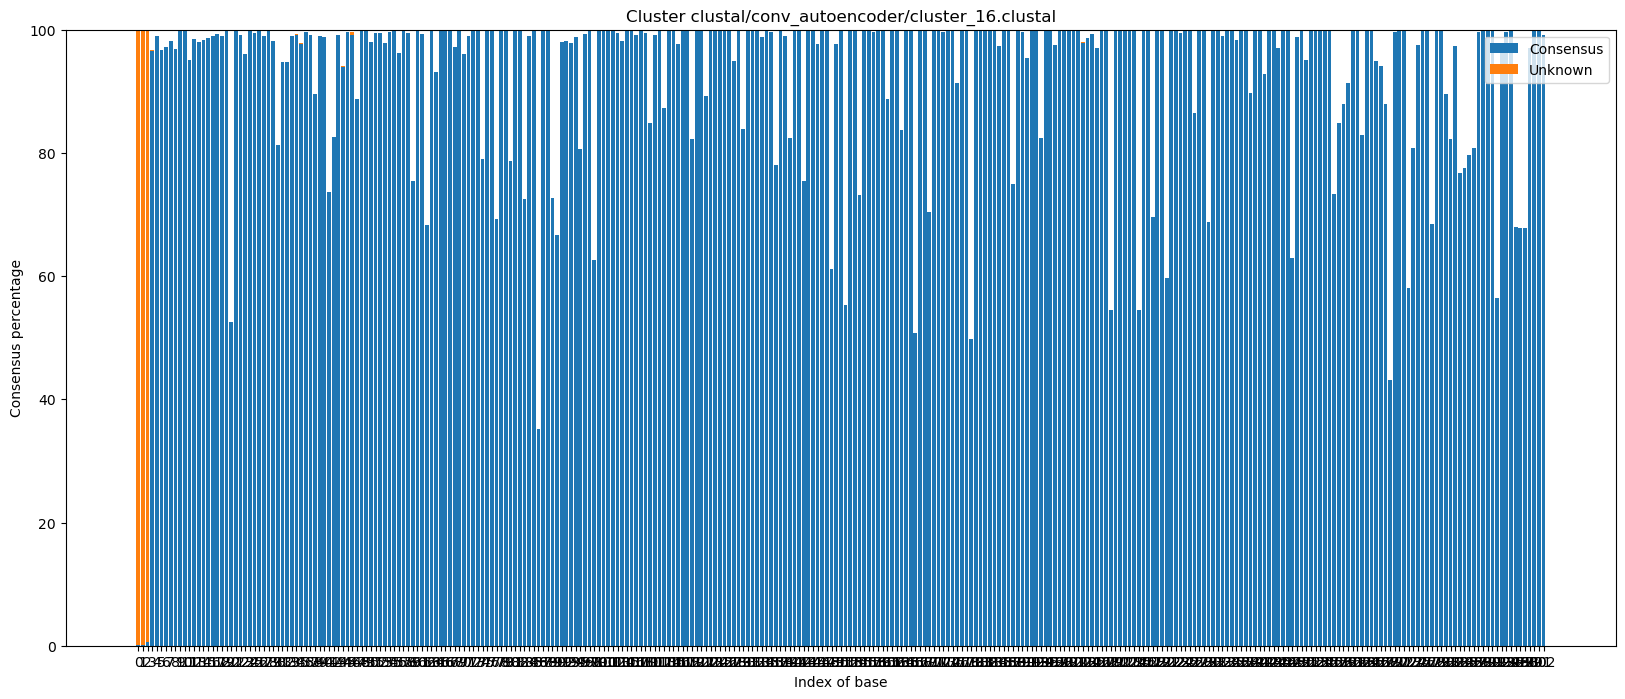

Plot for cluster 17


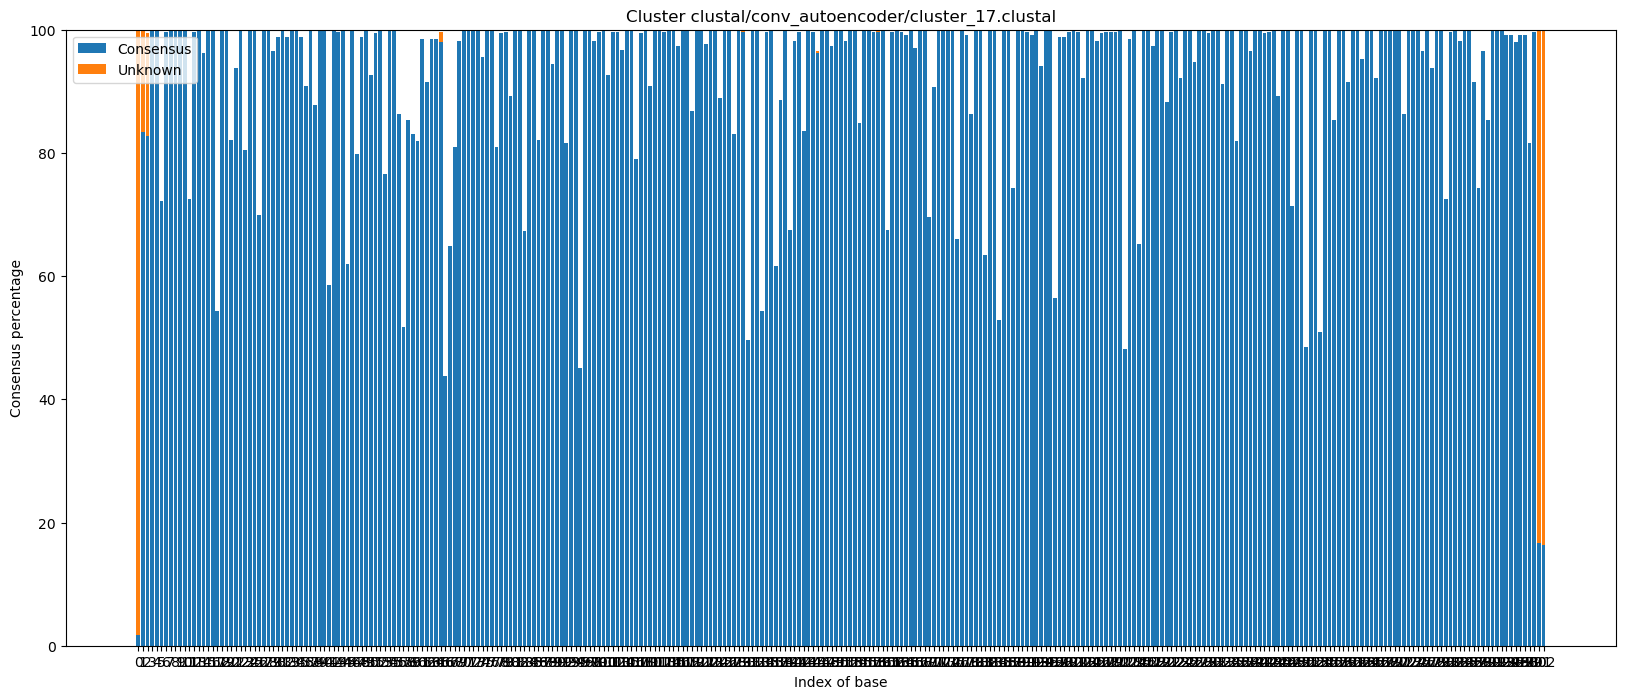

Plot for cluster 18


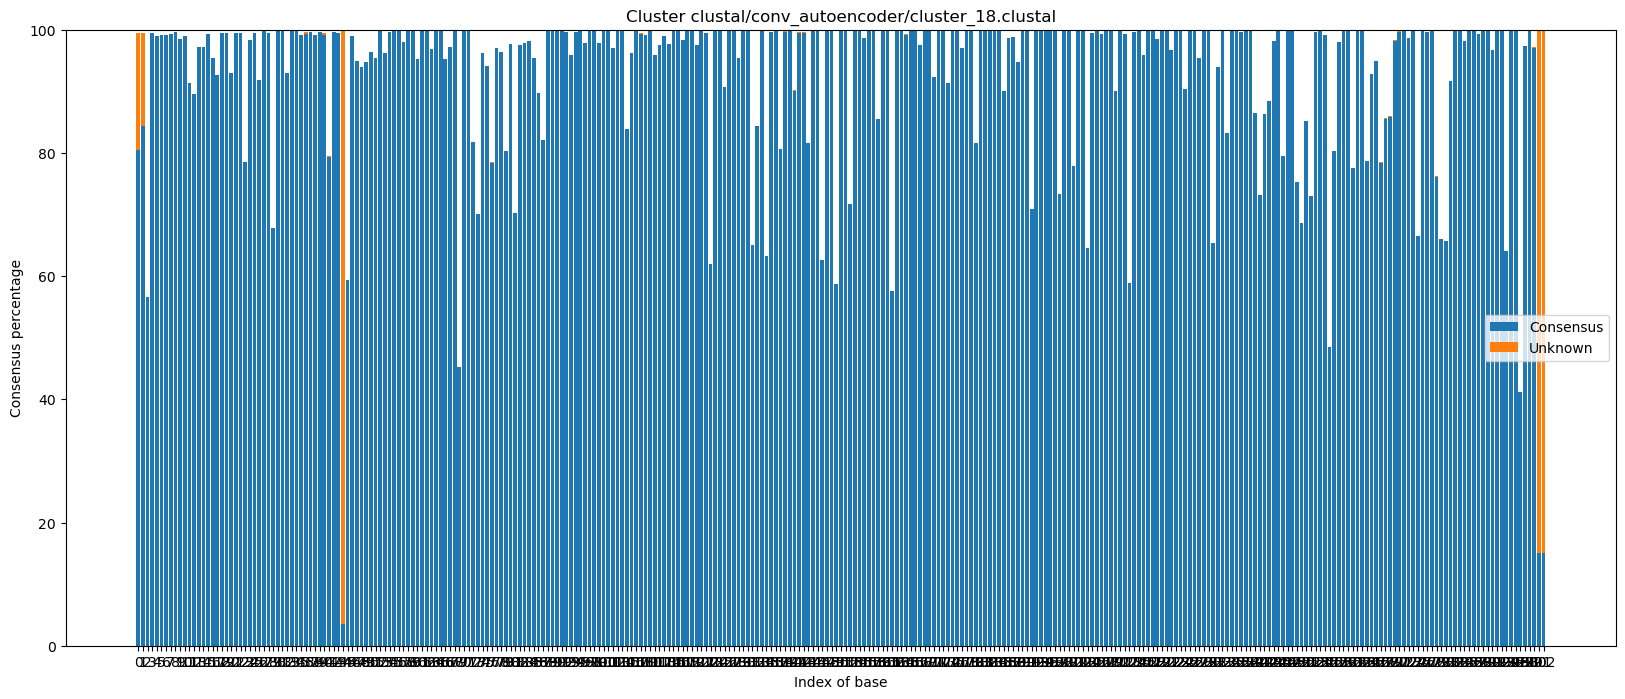

Plot for cluster 19


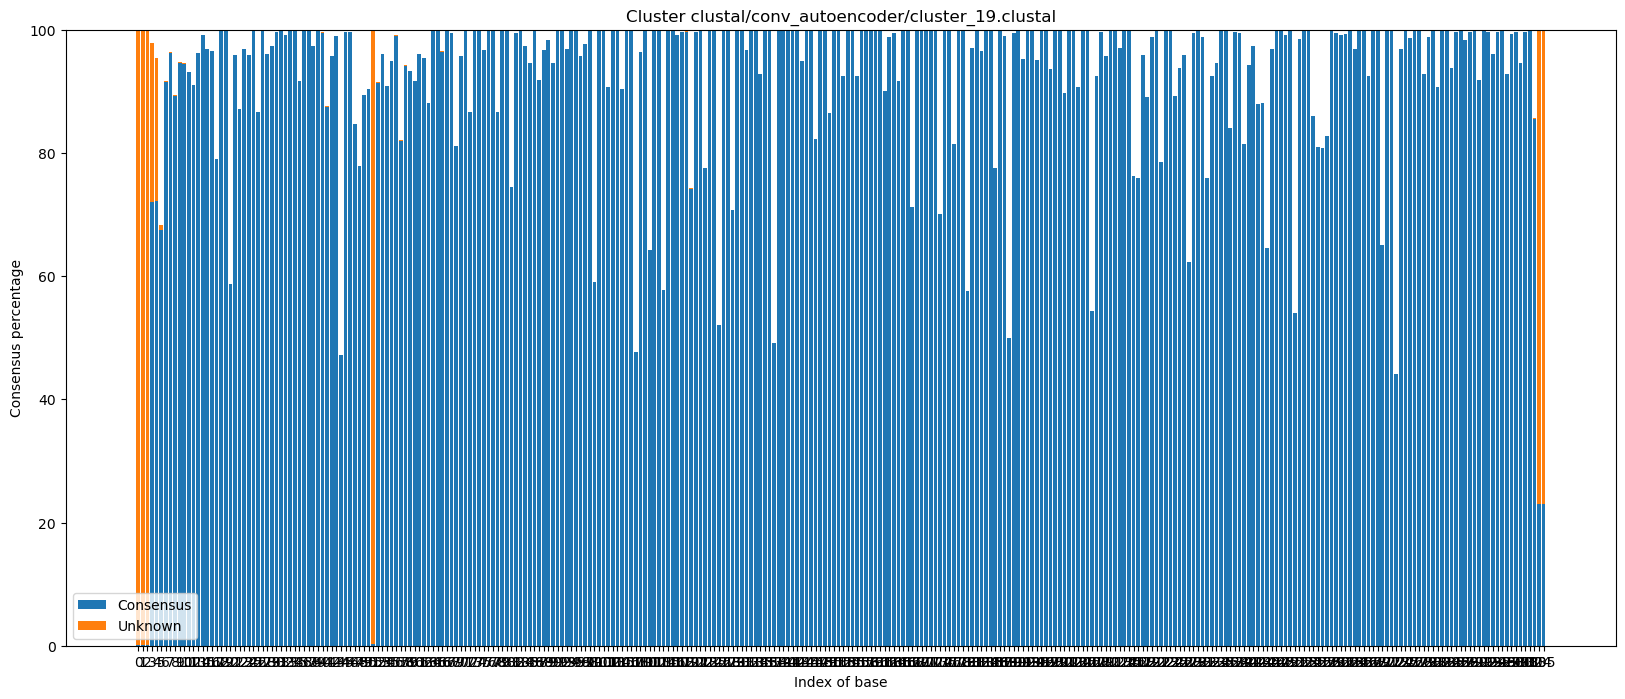

Plot for cluster 20


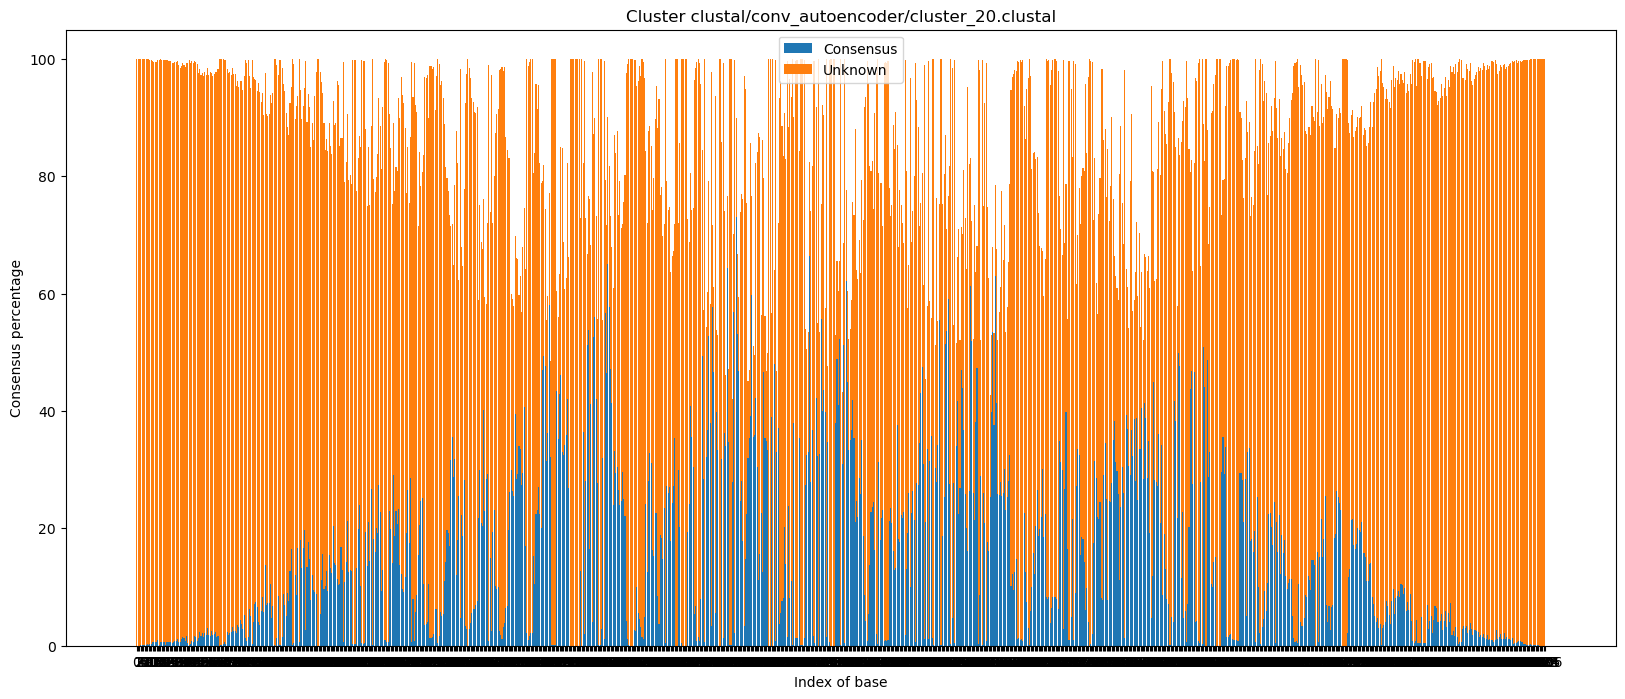

Plot for cluster 21


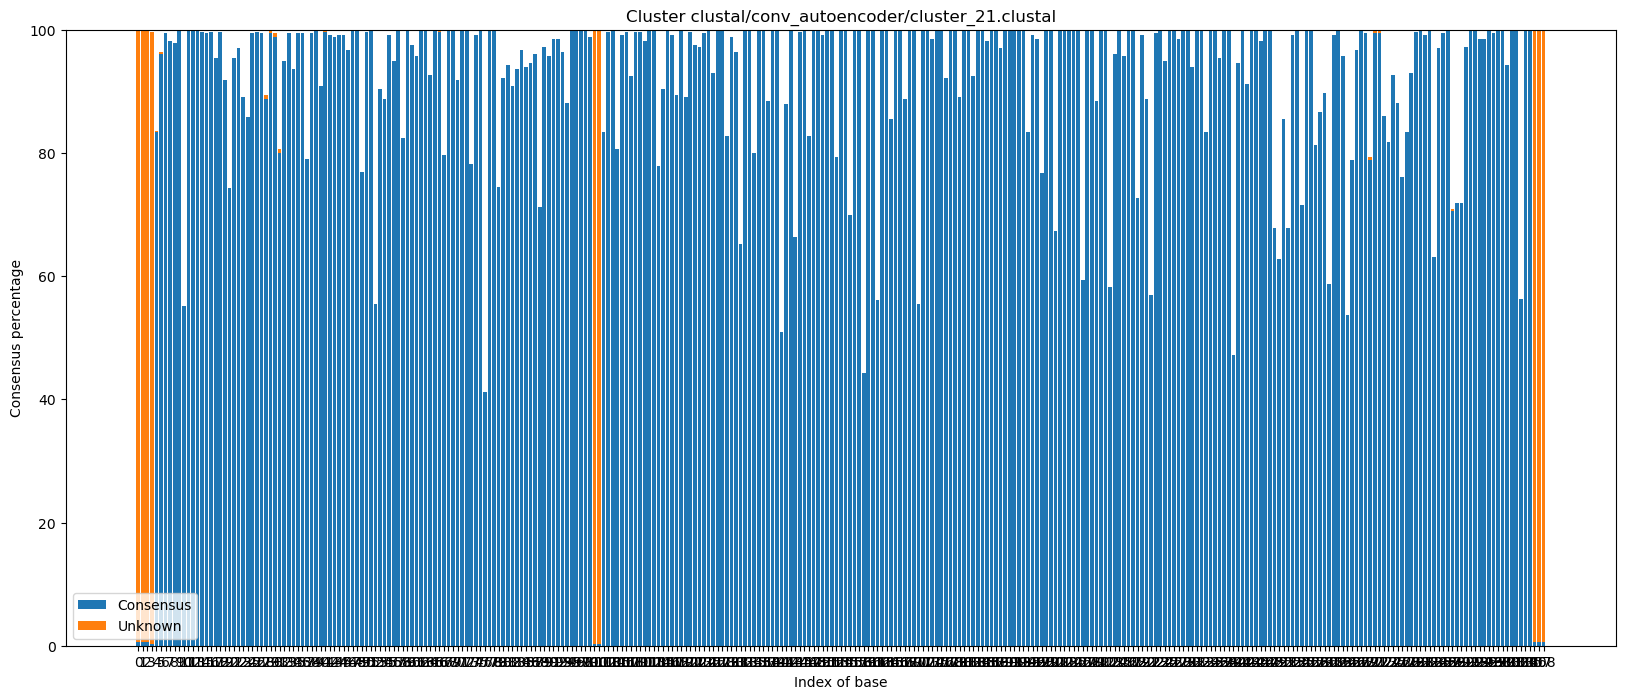

Plot for cluster 22


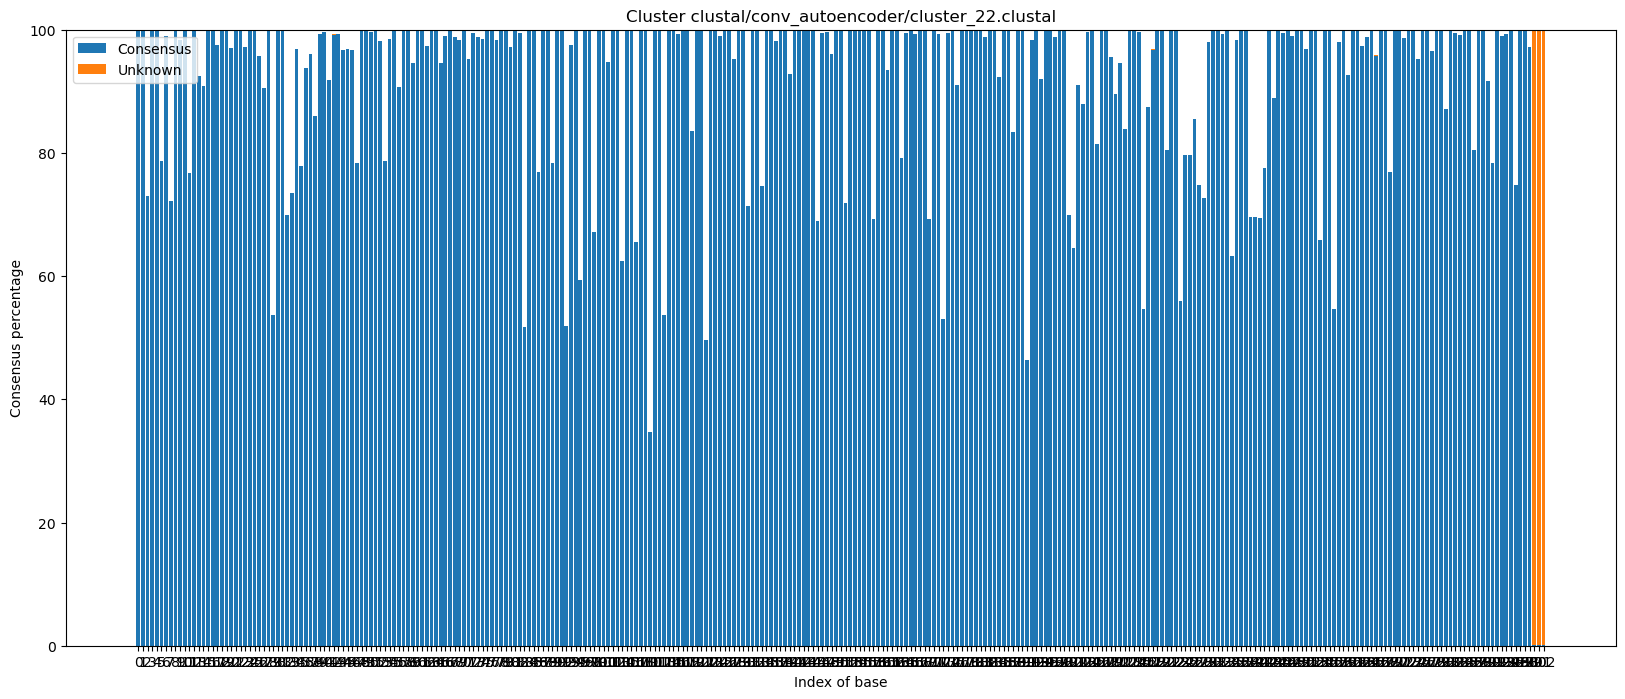

Plot for cluster 23


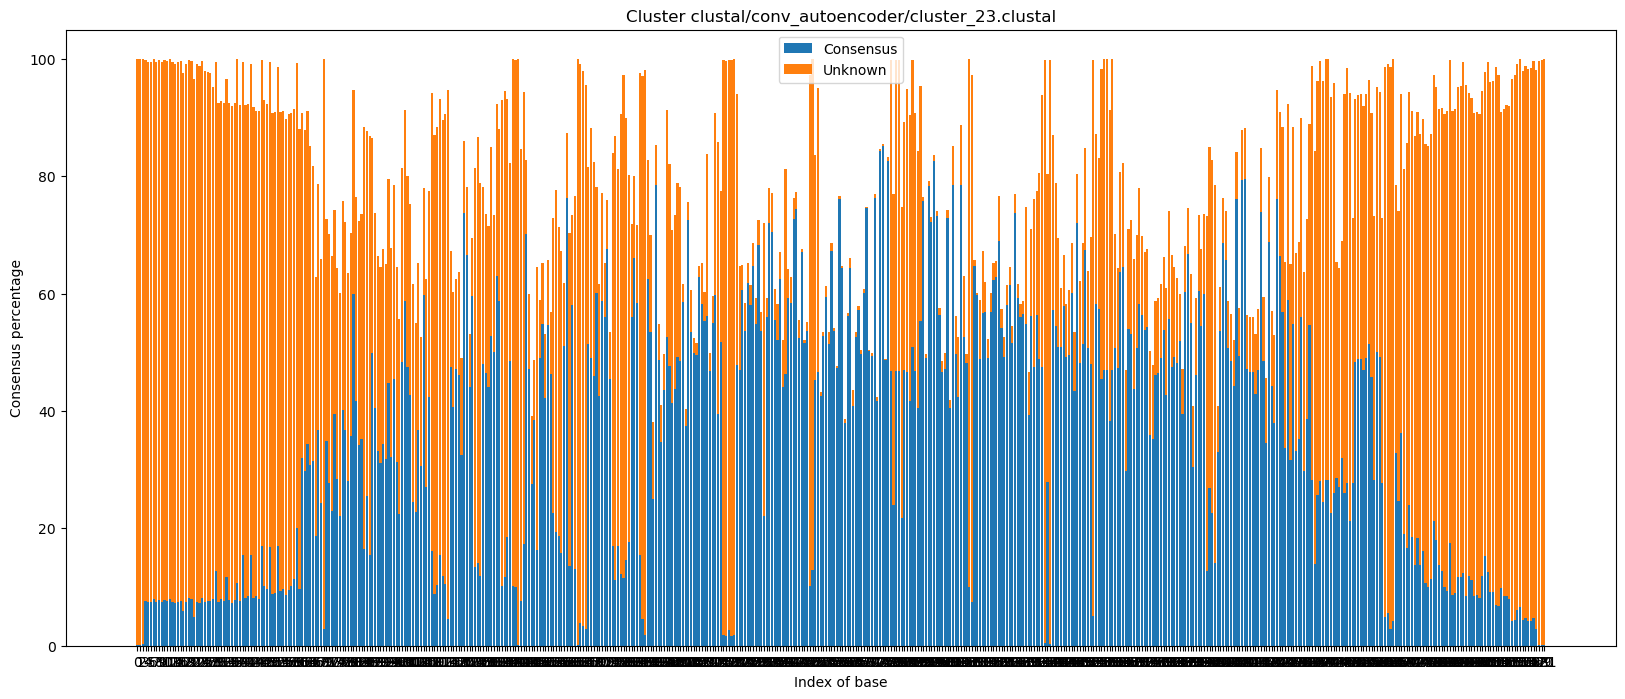

Plot for cluster 24


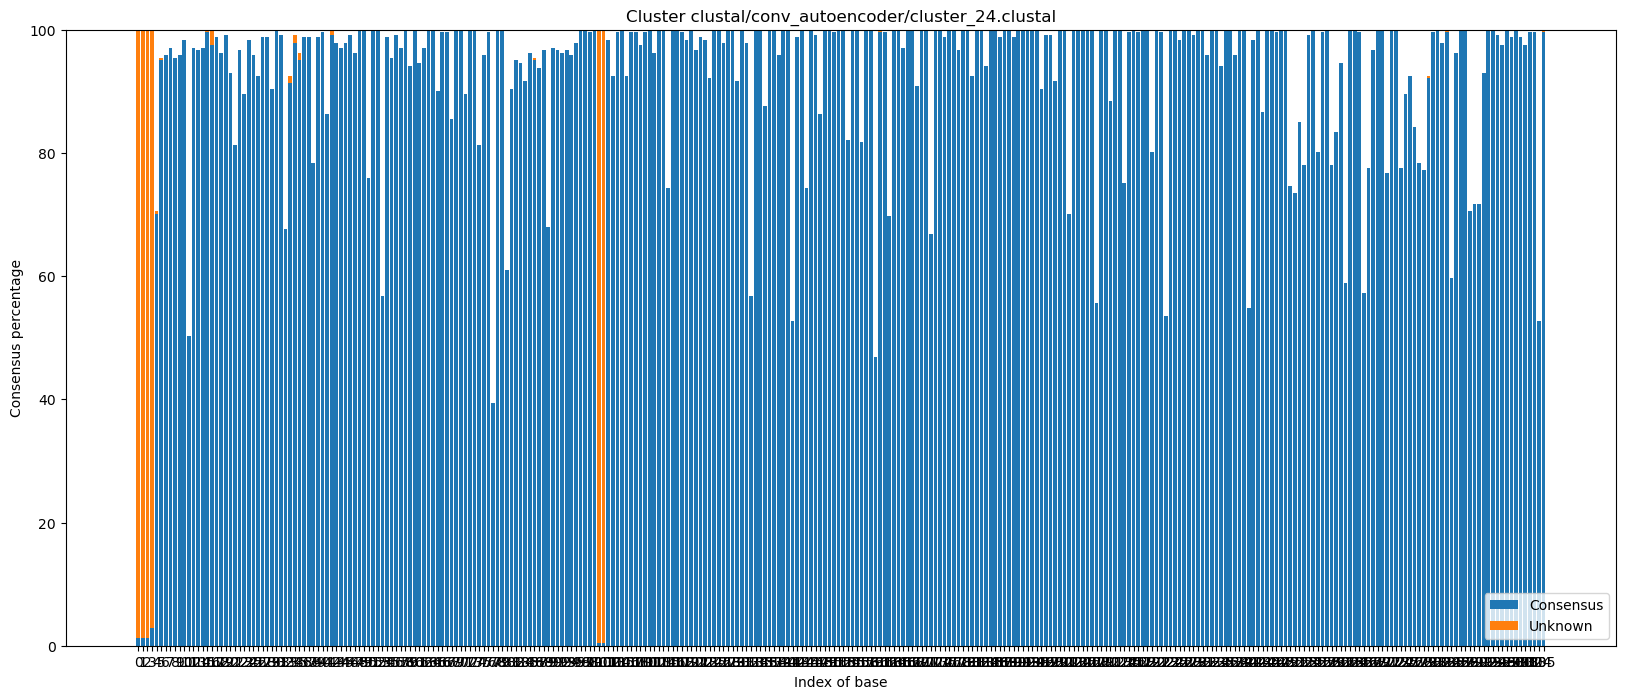

Plot for cluster 25


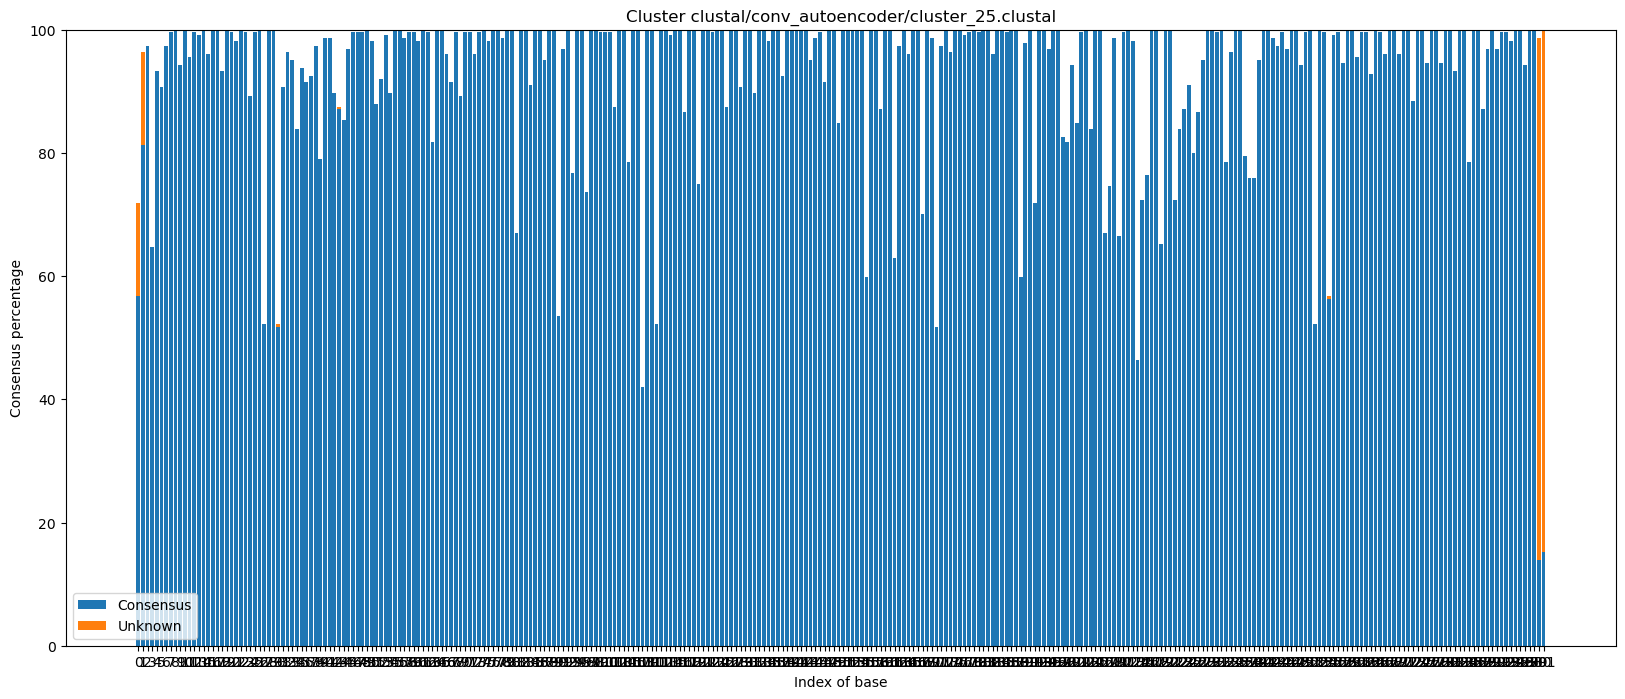

Plot for cluster 26


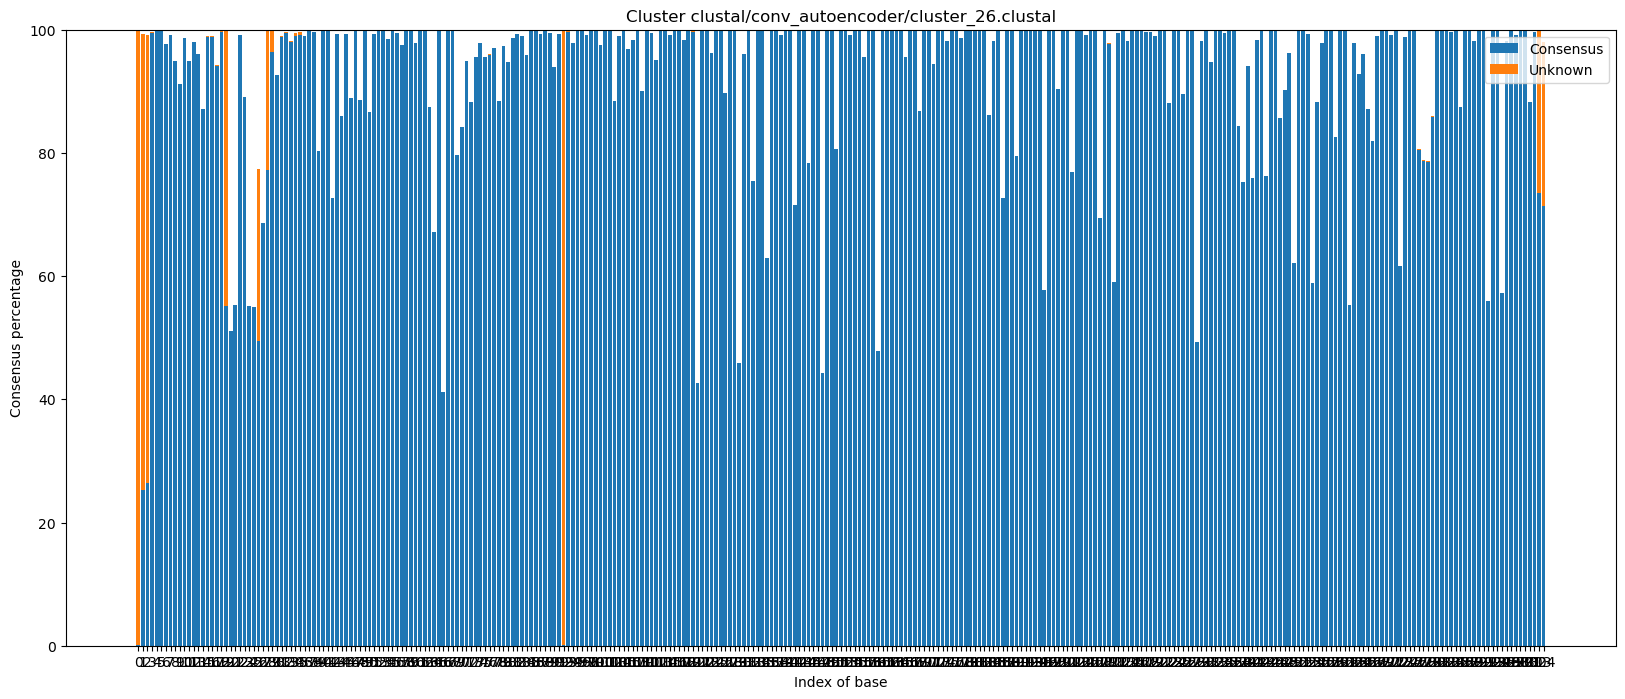

Plot for cluster 27


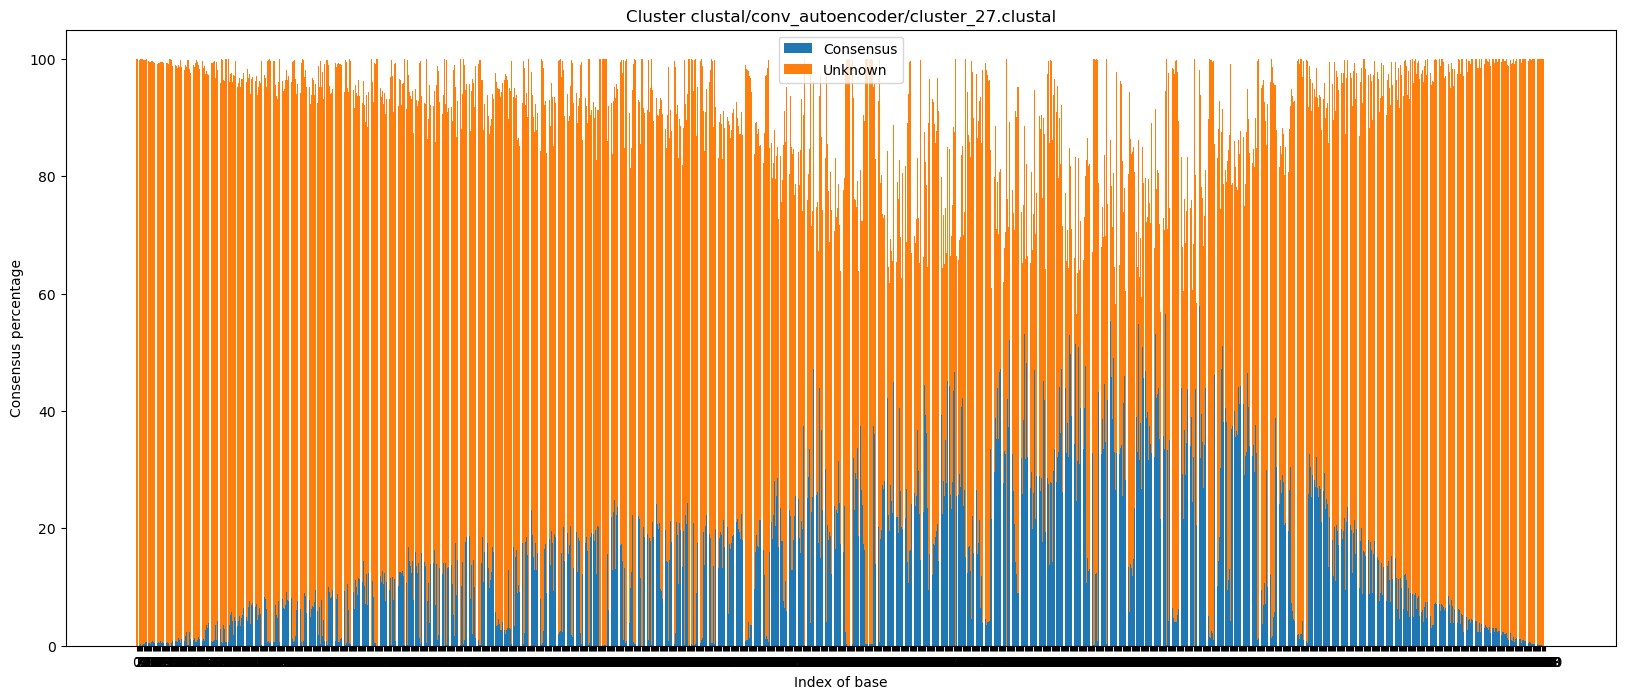

Plot for cluster 28


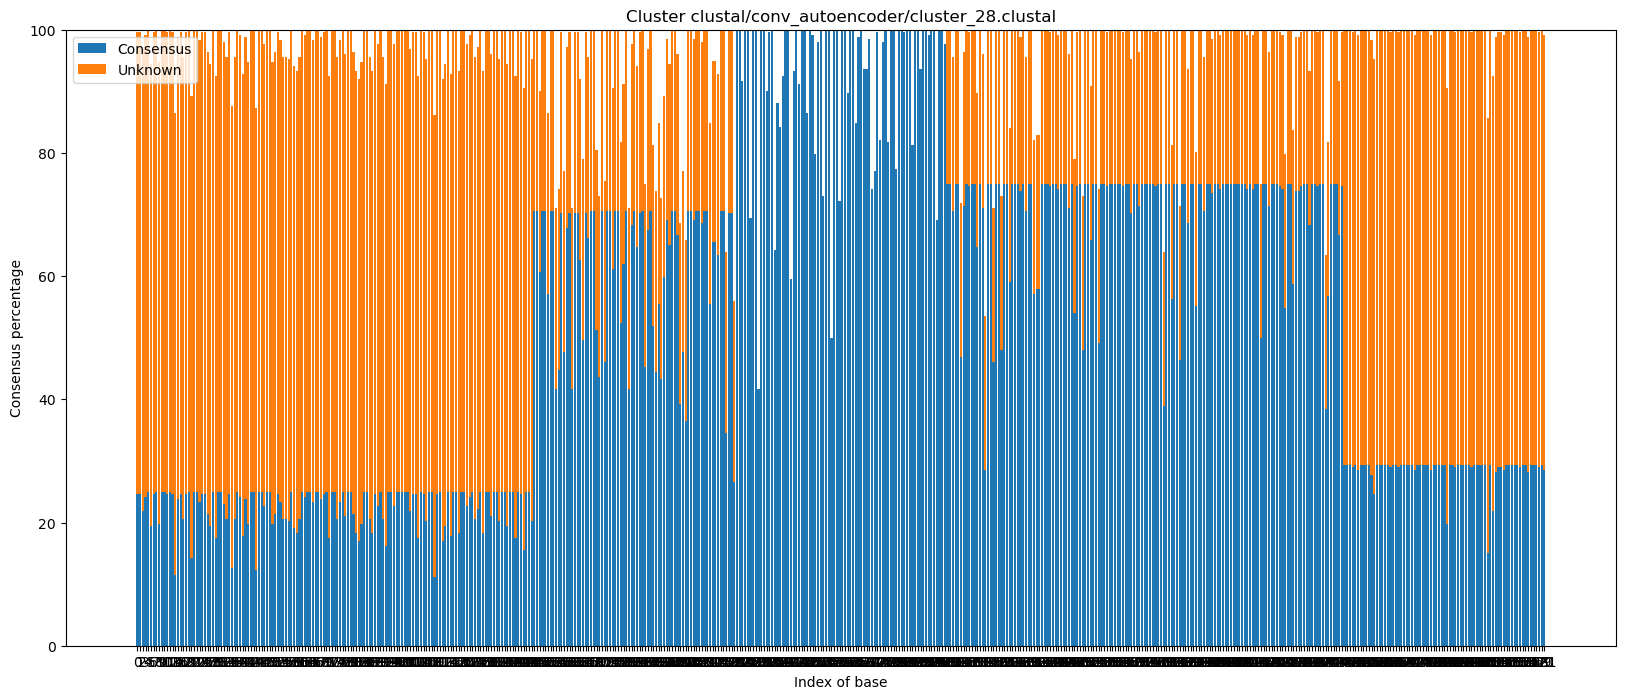

Plot for cluster 29


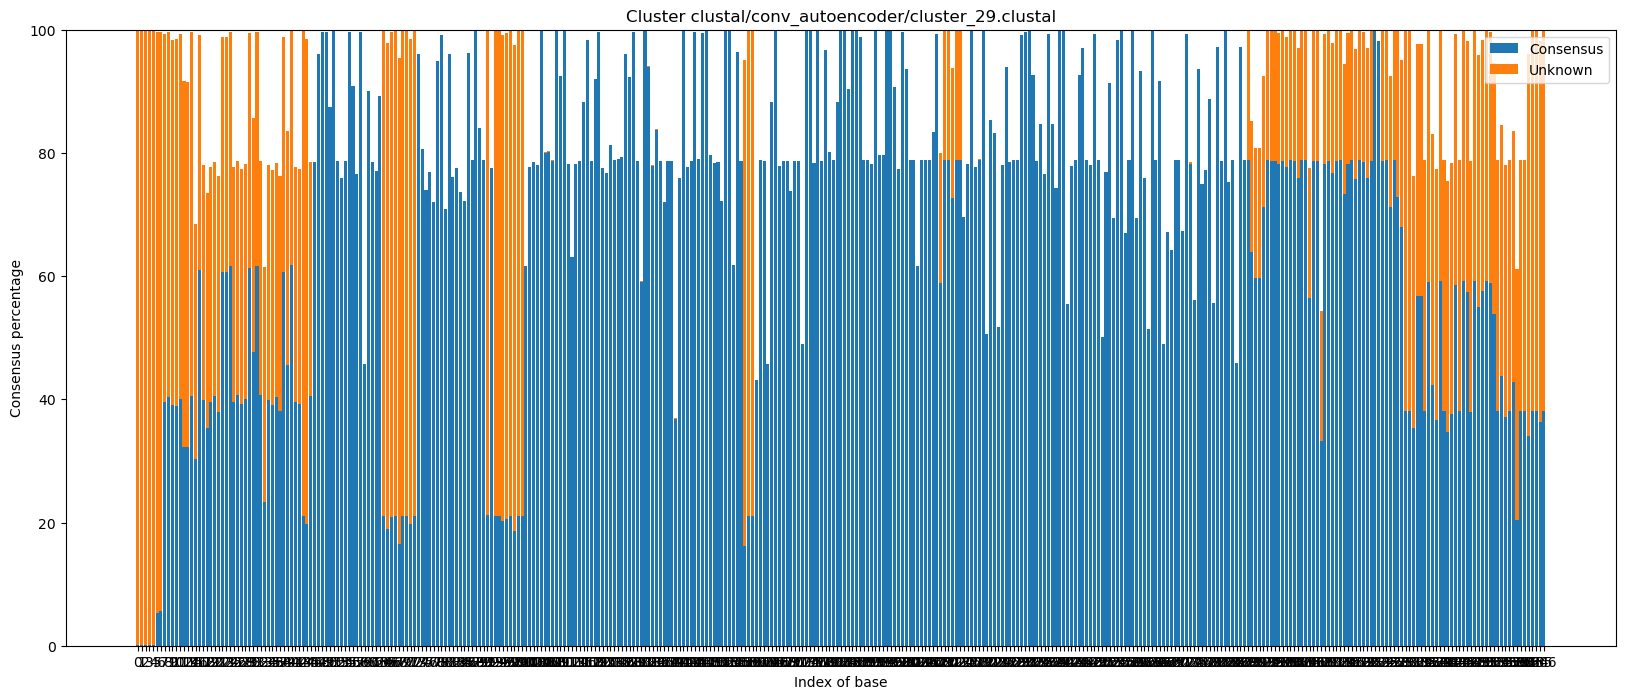

Plot for cluster 30


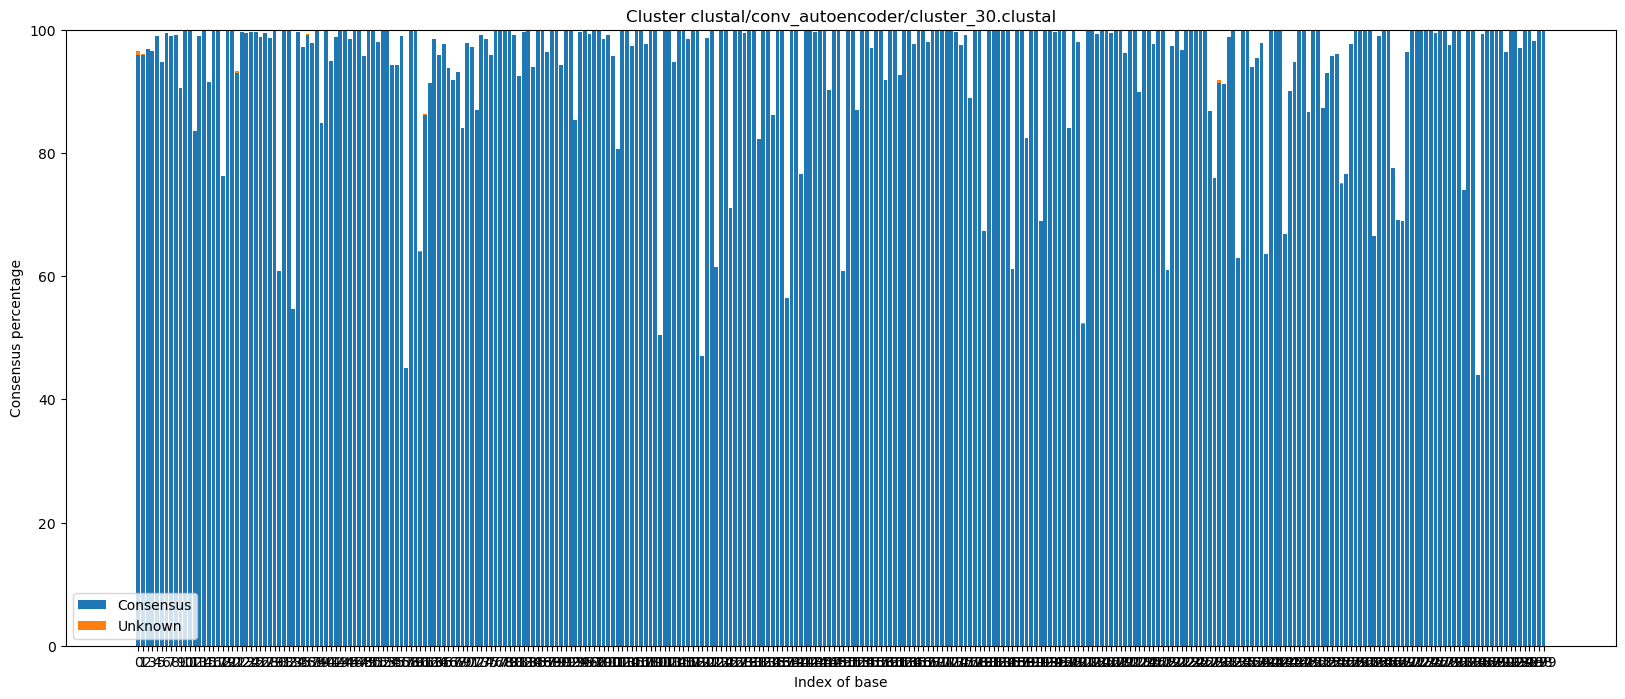

Plot for cluster 31


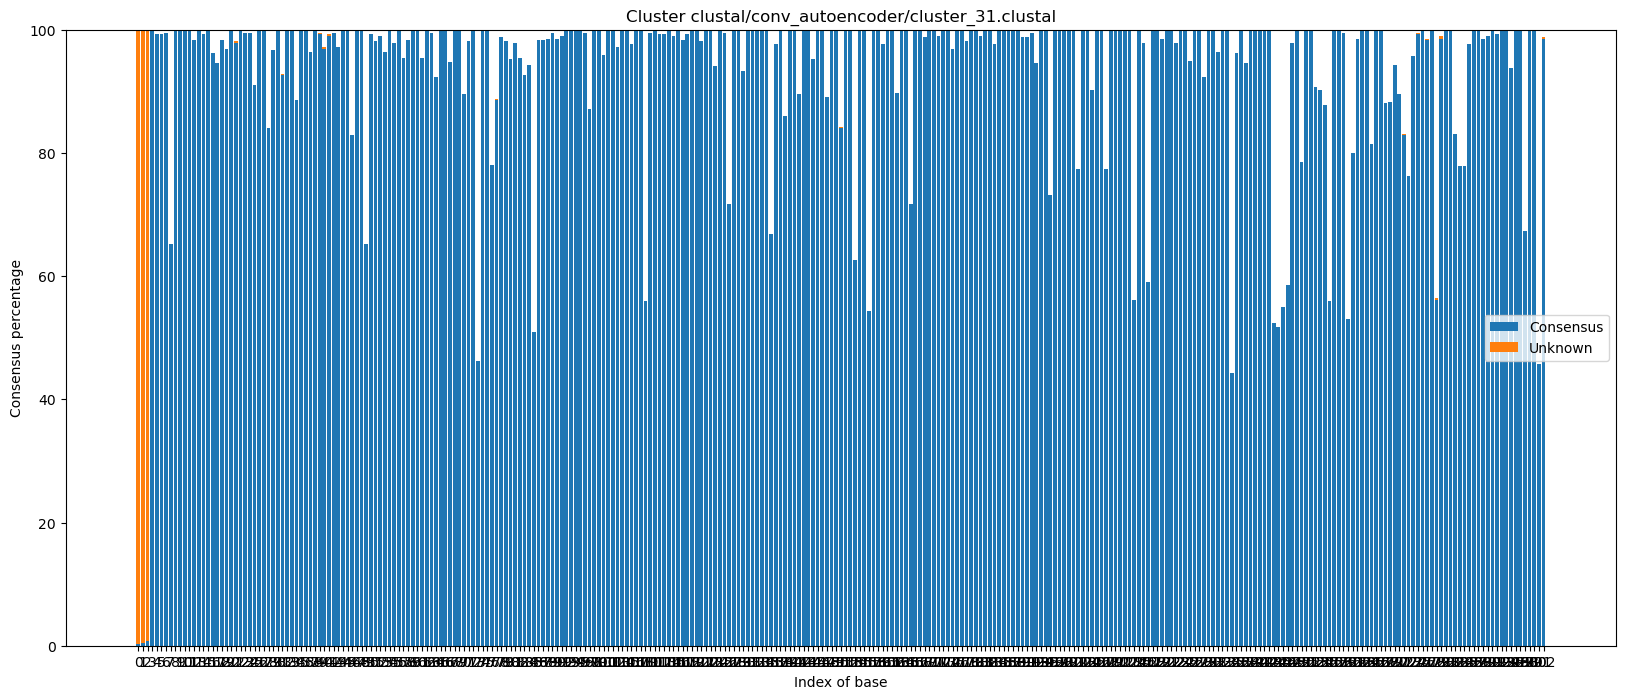

Plot for cluster 32


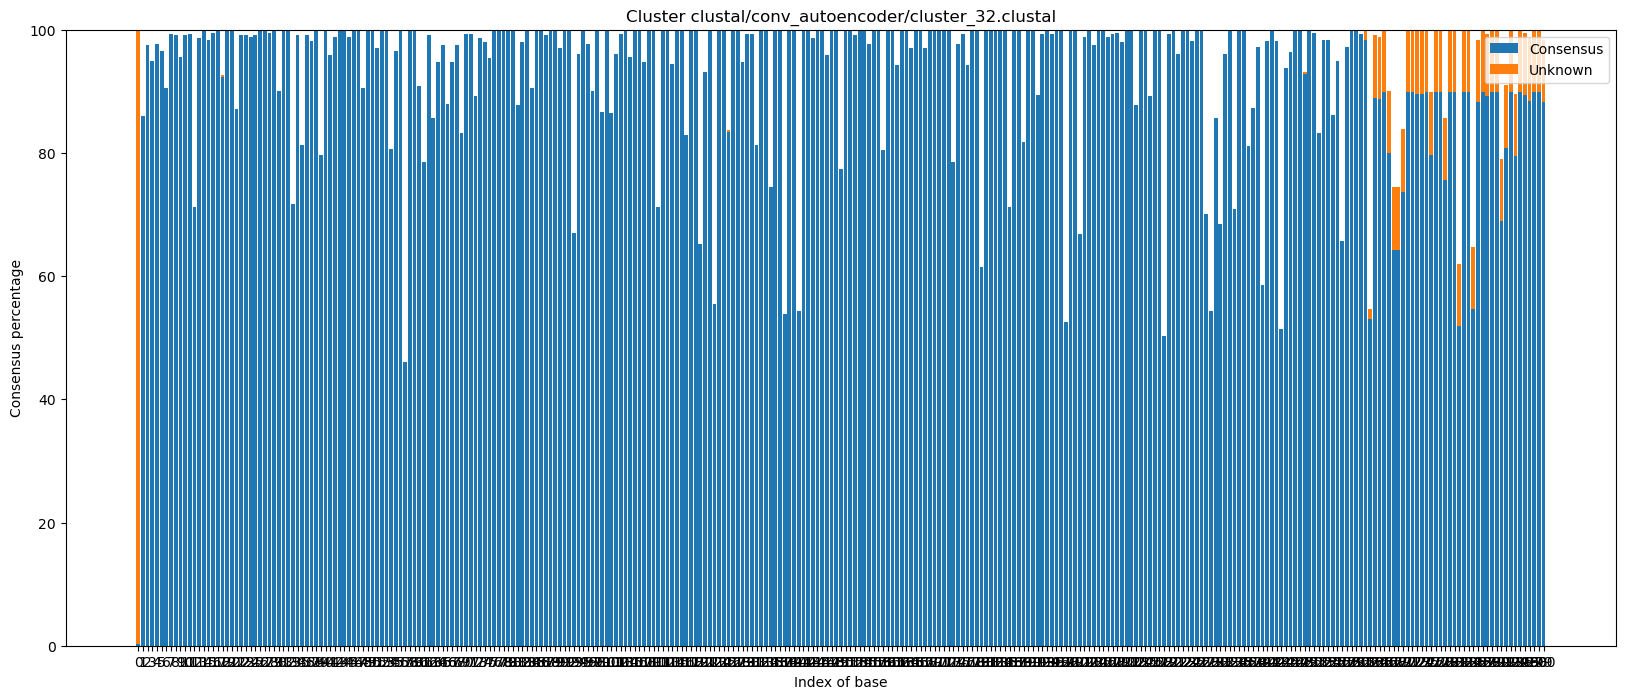

Plot for cluster 33


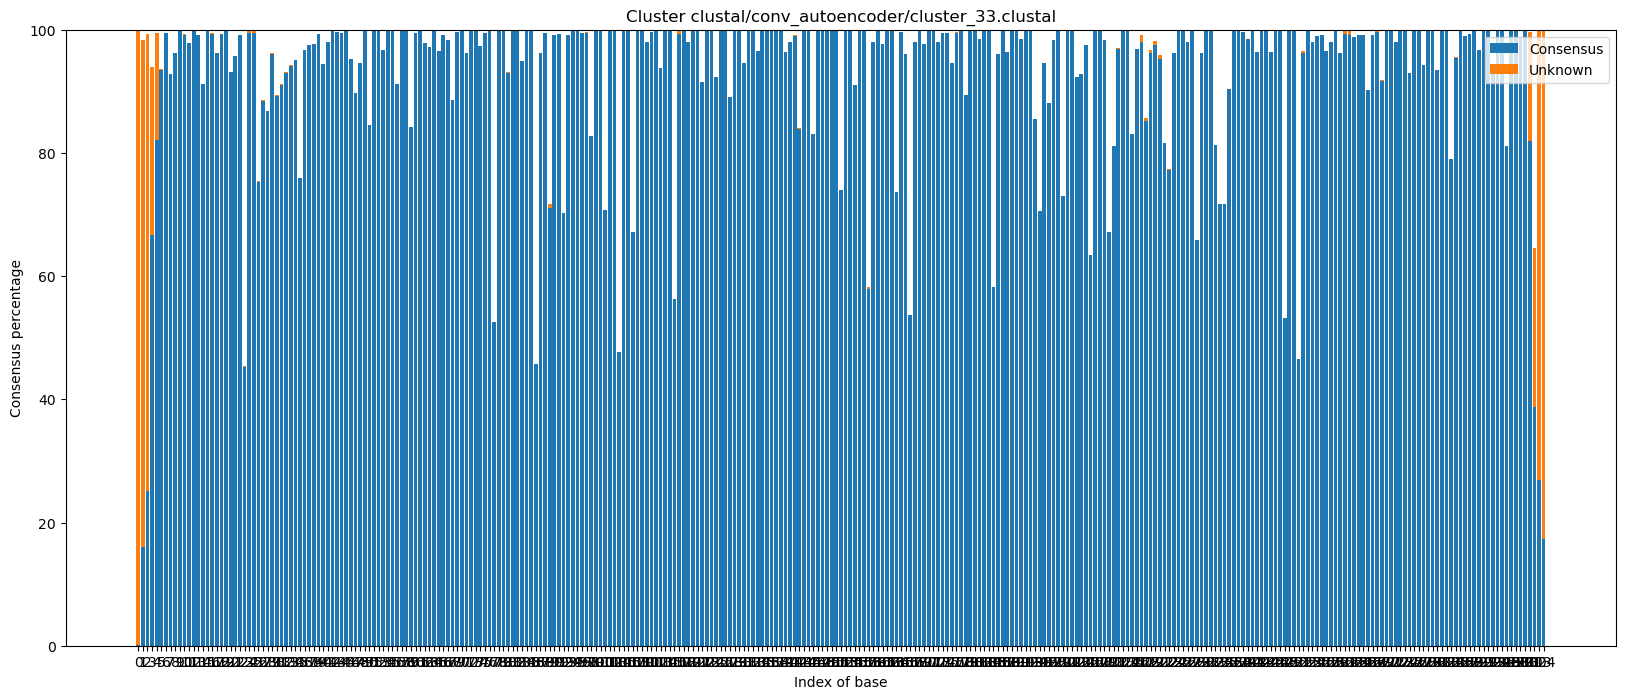

Plot for cluster 34


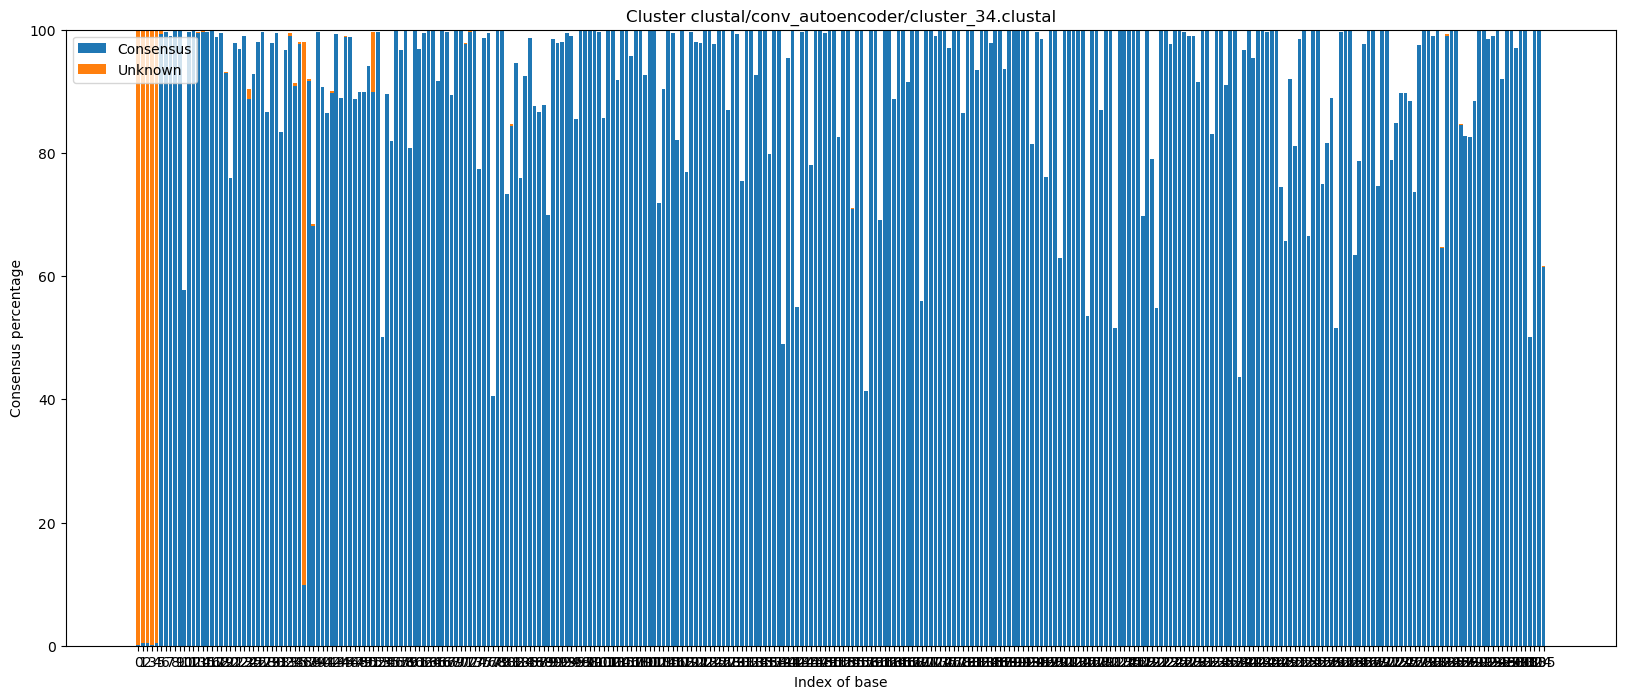

Plot for cluster 35


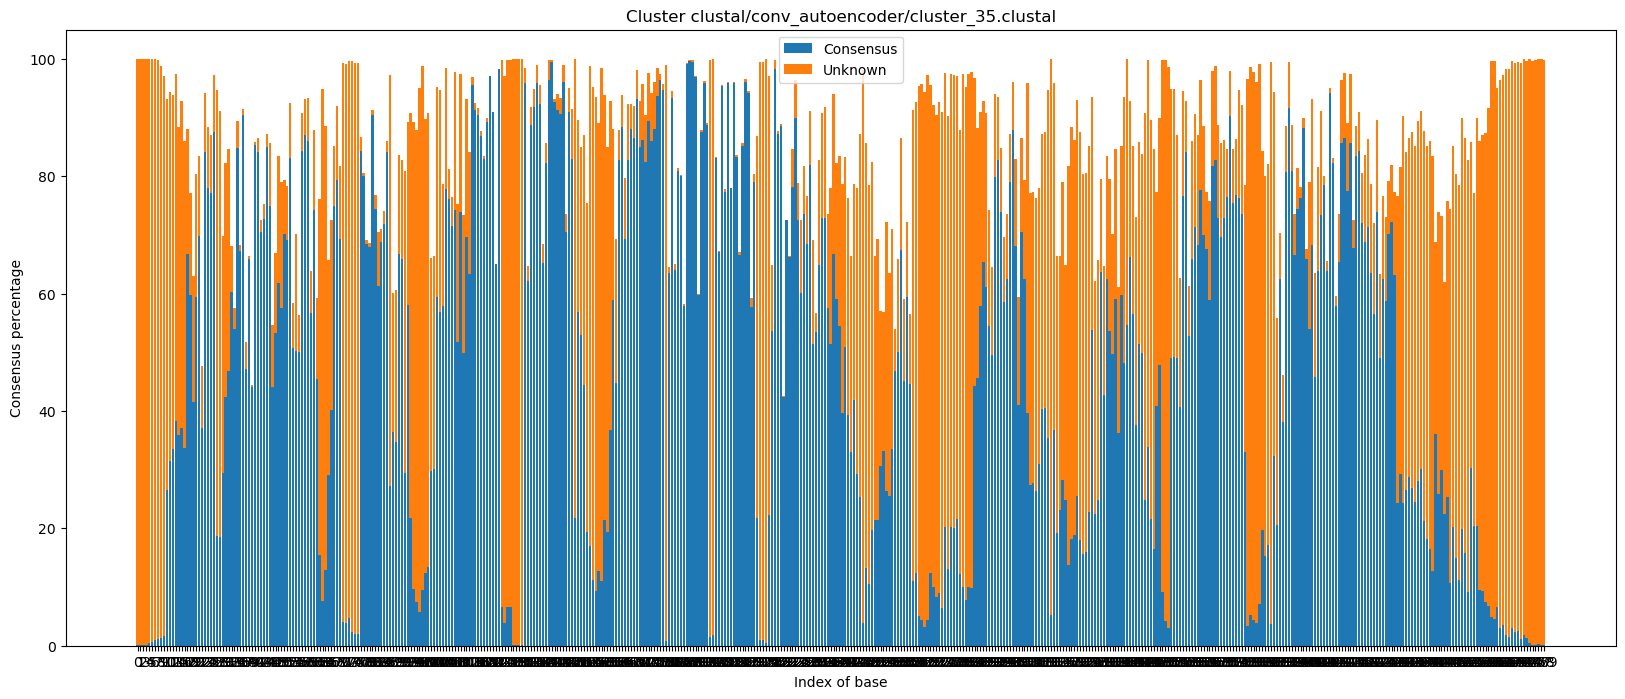

Plot for cluster 36


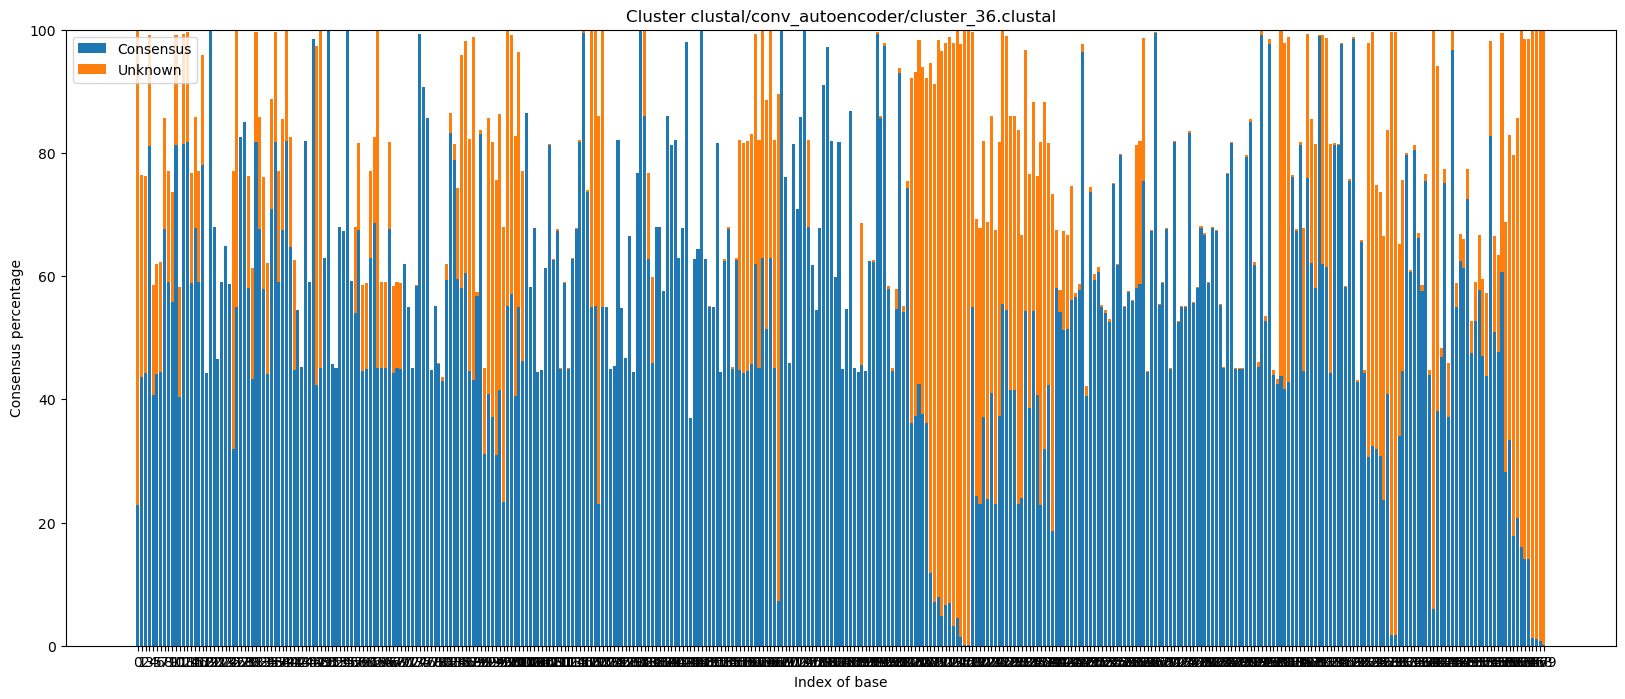

Plot for cluster 37


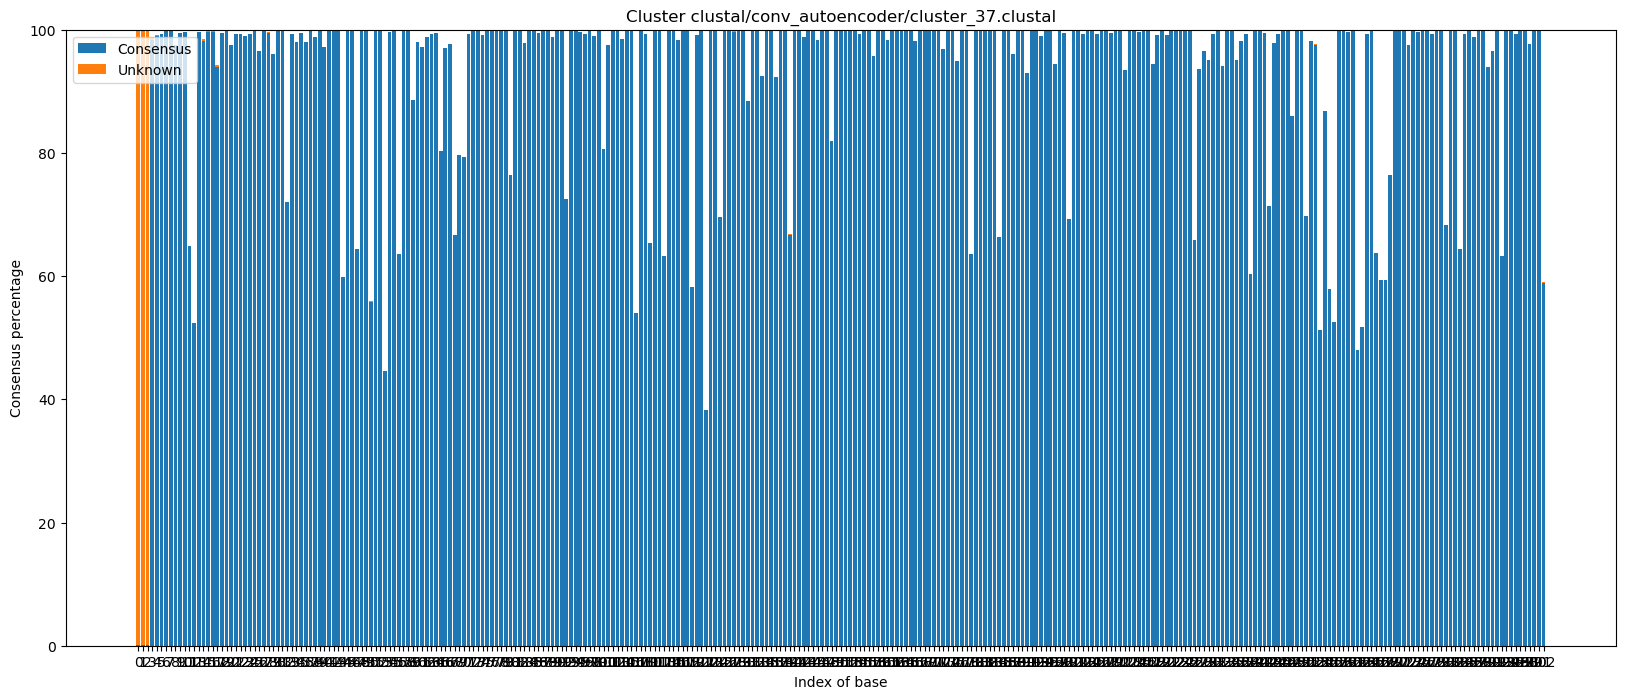

Plot for cluster 38


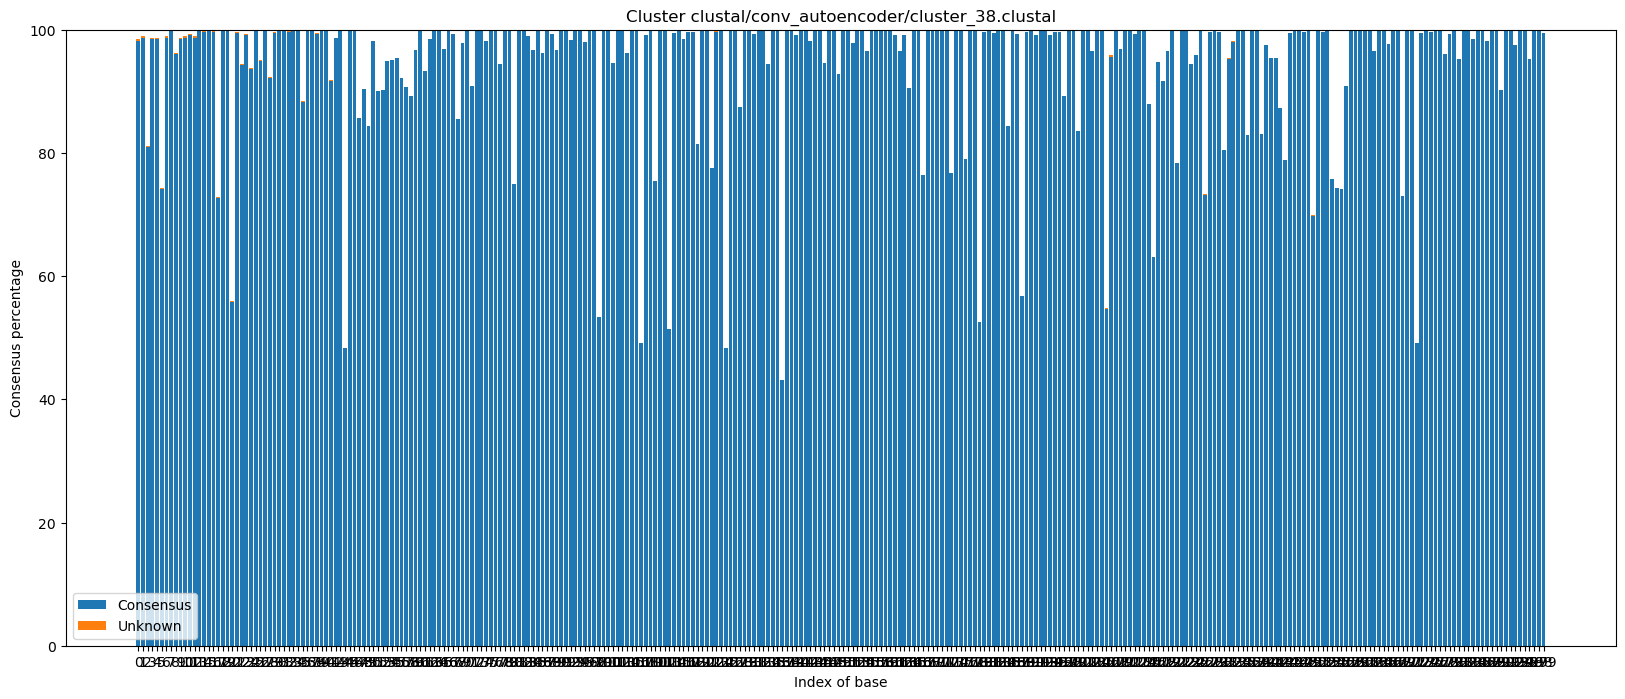

Plot for cluster 39


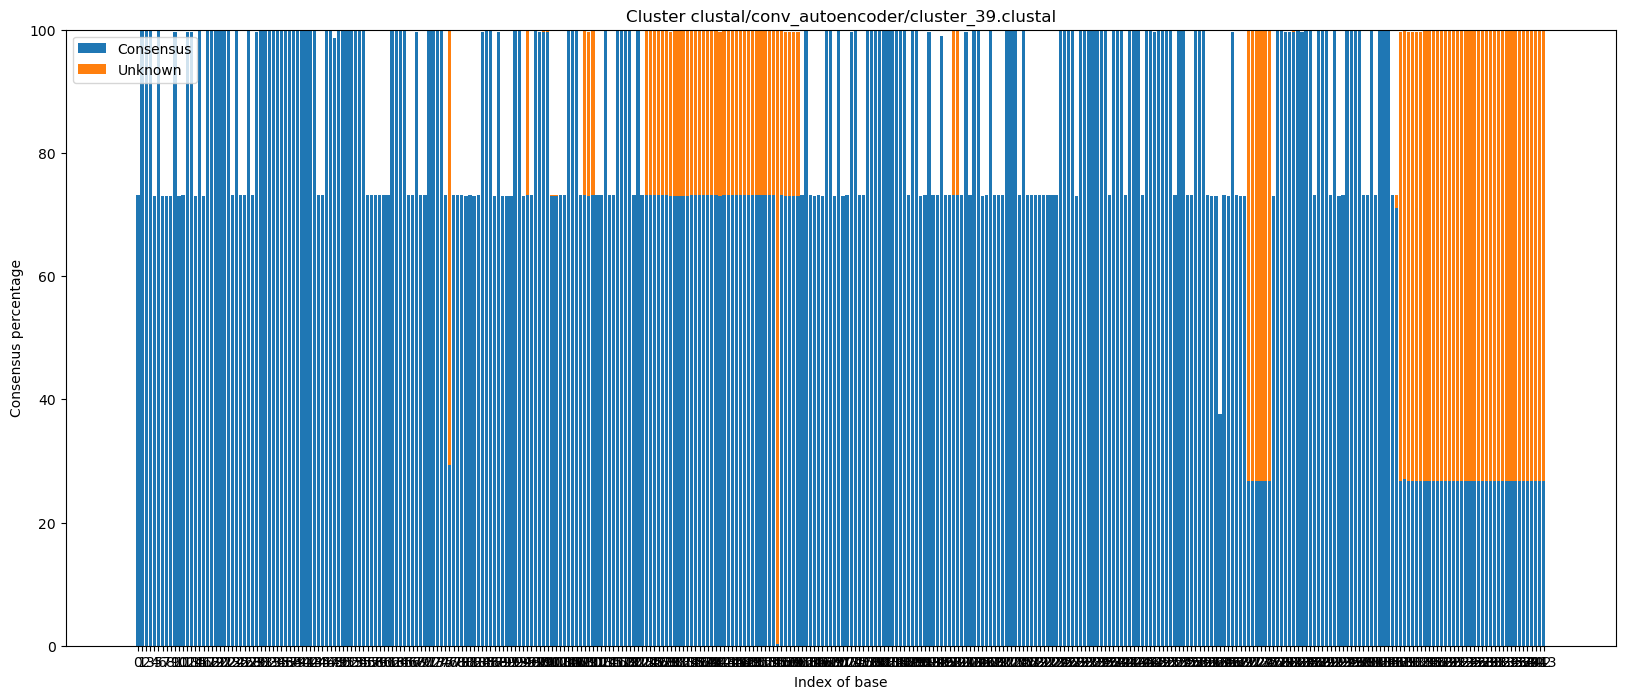

Plot for cluster 40


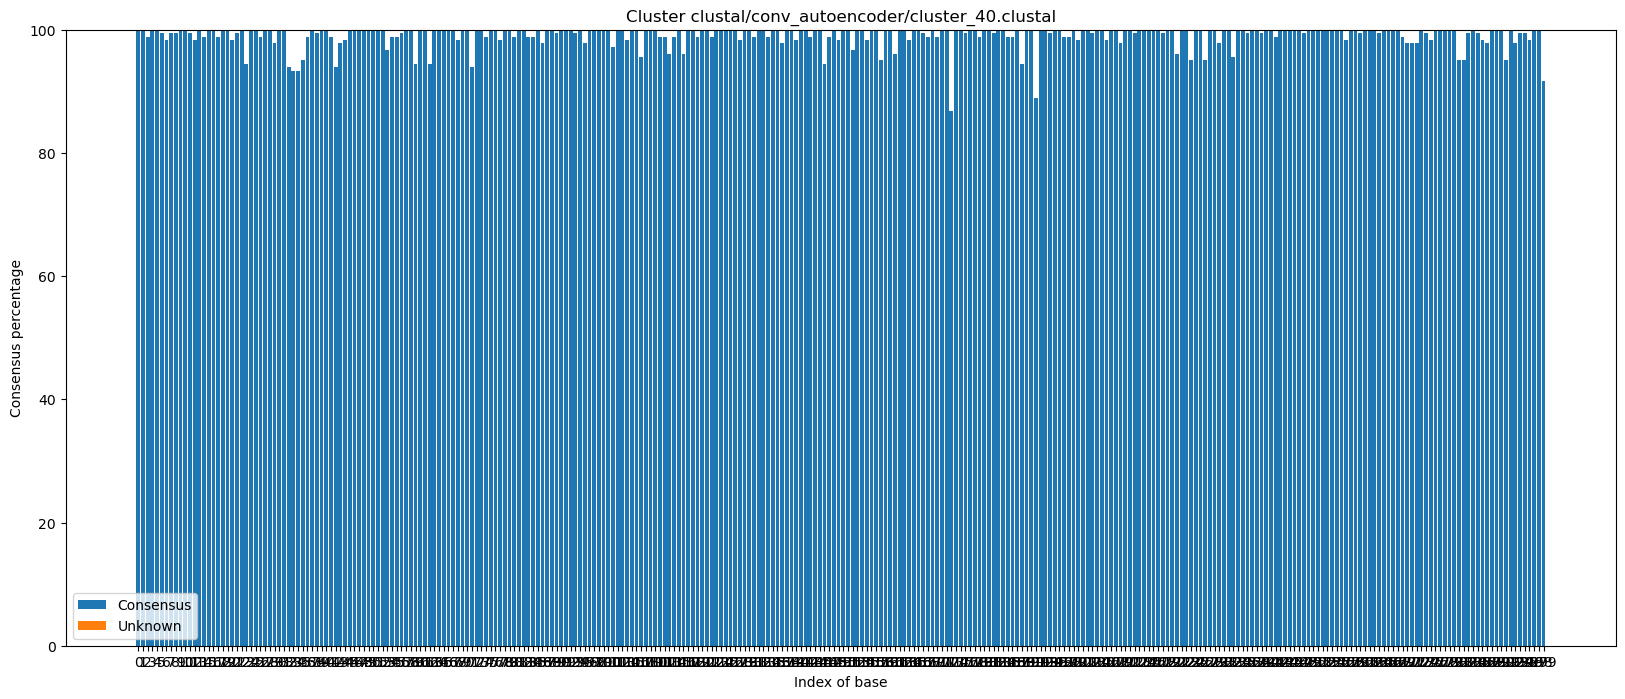

Plot for cluster 41


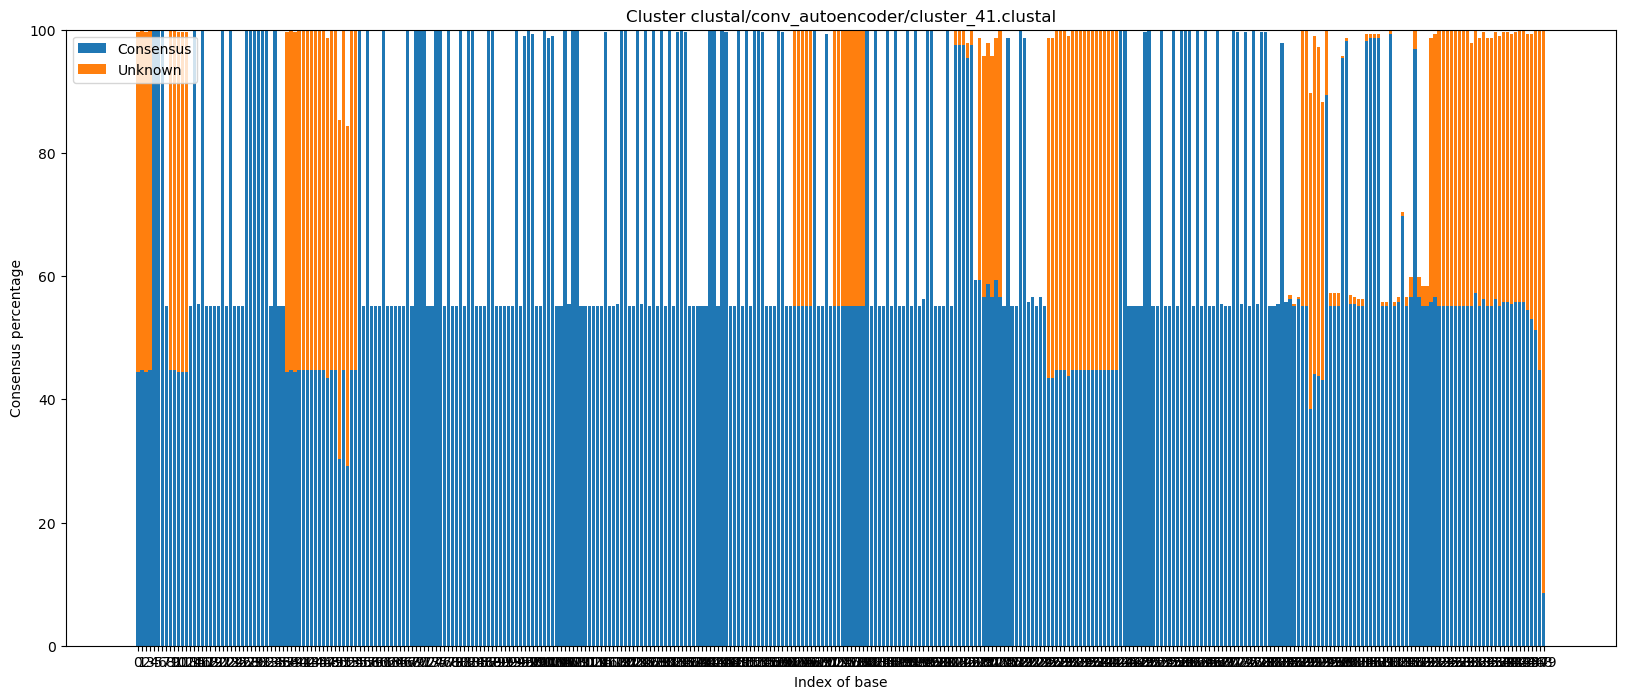

Plot for cluster 42


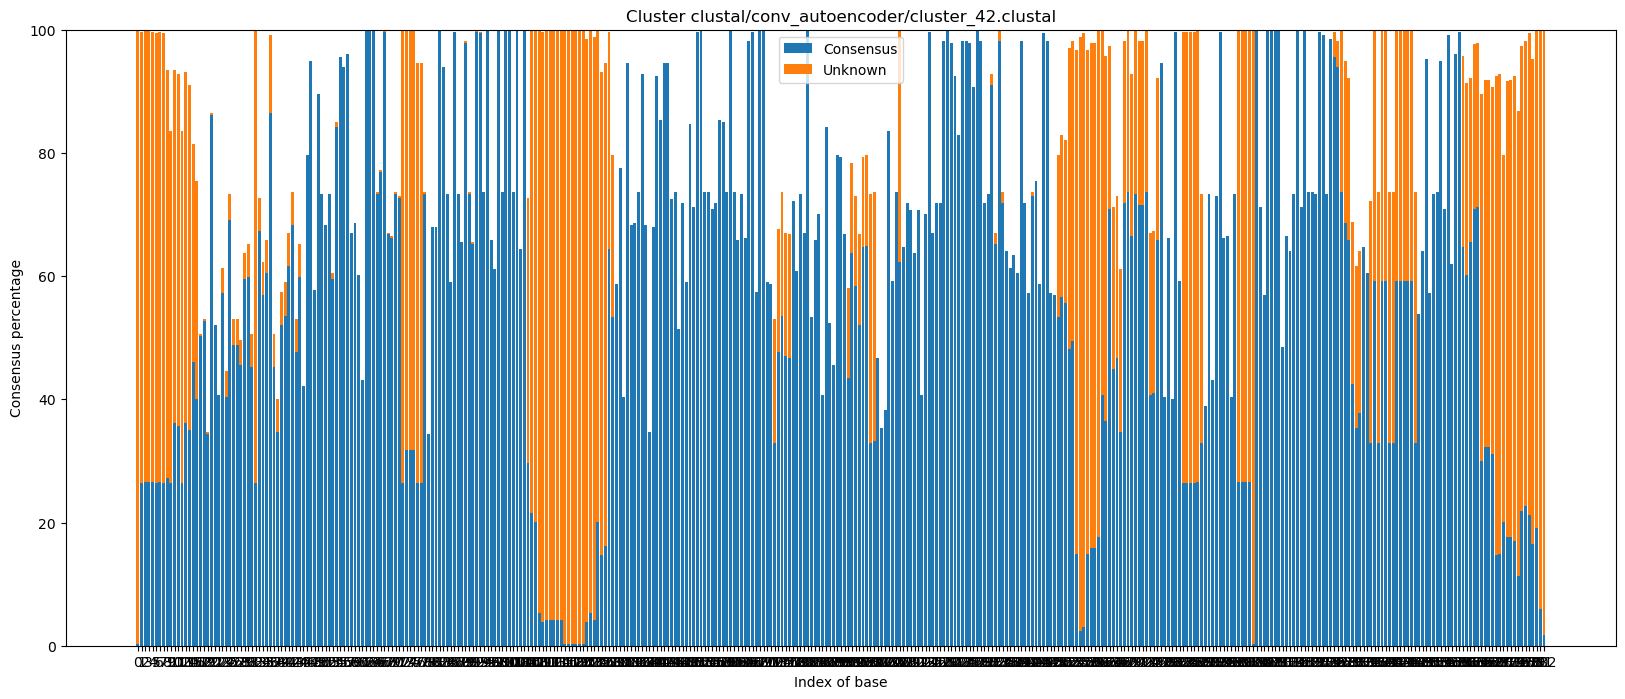

In [38]:
plotClusterRange(architecture_name, 0, num_clusters, unique_labels)

In [18]:
print(np.mean(percentages))
print(np.median(percentages))
print(np.std(percentages))

11.30062754526719
1.4292013101536911
19.496737280323014


In [19]:
scores, normalized_scores, sum_scores, div_scores = primerExtractionScoreOnModel(architecture_name, cluster_labels, unique_labels, stride=1)

In [20]:
print(scores)
print(normalized_scores)
print(sum_scores)
print(div_scores)

[0, 93.90272373540856, 97.32546842470506, 0, 96.56281407035176, 96.54489164086687, 97.84420289855072, 84.73308270676692, 96.44342331993107, 95.55357142857143, 98.26521060842434, 97.01404853128992, 99.93661971830986, 96.82510288065843, 97.5030303030303, 95.32379713914175, 96.88559892328398, 96.54970760233918, 97.21804511278195, 95.78125, 0, 95.39393939393939, 96.41515934539191, 0, 96.58091286307054, 96.70535714285714, 96.0238726790451, 0, 93.63492063492063, 85.11607142857143, 96.9538737124944, 97.61428571428571, 96.4331797235023, 97.24489795918367, 95.80232558139535, 77.18834547346513, 0, 98.11514392991239, 96.83695652173913, 93.01273885350318, 99.60220994475138, 75.77224199288256, 75.54491017964072]
[0.      0.96532 2.80492 0.      1.15296 0.62368 1.0802  0.90156 3.35816
 0.64212 1.25976 1.51924 1.13528 1.88228 0.96528 1.46608 1.43972 0.6604
 1.293   1.226   0.      0.6296  2.23876 0.      0.46552 0.43324 1.44804
 0.      0.47192 1.14396 4.32996 0.81996 0.83704 1.7154  0.98868 1.48356


In [21]:
np.count_nonzero(normalized_scores)/len(unique_labels)

0.8604651162790697

In [22]:
sequences_list = list(SeqIO.parse("Data/rbcL.fasta" , "fasta"))
family_count_per_cluster, family_frequencies_per_cluster = getFamiliesPerCluster(cluster_labels, unique_labels, getIDs("Data/rbcL_ids.txt"), getIDFamilyMapping(sequences_list))

In [23]:
print(family_count_per_cluster)
print(family_frequencies_per_cluster)

{0: 1646, 1: 224, 2: 741, 3: 523, 4: 365, 5: 268, 6: 122, 7: 359, 8: 705, 9: 186, 10: 342, 11: 433, 12: 10, 13: 513, 14: 293, 15: 382, 16: 361, 17: 177, 18: 366, 19: 428, 20: 4202, 21: 235, 22: 521, 23: 810, 24: 189, 25: 108, 26: 423, 27: 3096, 28: 112, 29: 385, 30: 818, 31: 246, 32: 214, 33: 547, 34: 336, 35: 581, 36: 273, 37: 342, 38: 302, 39: 4, 40: 26, 41: 96, 42: 83}
{0: {'strictum': 4, 'cirrhosum': 1, 'parviflora': 10, 'Vellozia': 6, 'sp.': 104, 'spruceana': 2, 'oblonga': 2, 'ascendiflora': 1, 'himalaica': 2, 'lacerulata': 1, 'calisaya': 1, 'australe': 1, 'aspera': 1, 'penduliflora': 8, 'cynanchica': 3, 'monticola': 2, 'glauca': 17, 'kamoonensis': 2, 'stoebe': 64, 'apiculatum': 4, 'yuvinkae': 2, 'palmata': 7, 'nigricans': 1, 'elegans': 4, 'vulgaris': 2, 'makakana': 1, 'colombiana': 35, 'giganteum': 22, 'schiedeana': 1, 'ferruginea': 1, 'sapida': 1, 'racemosa': 6, 'inermis': 1, 'rotundifolius': 1, 'ambrosioides': 3, 'daliensis': 2, 'lunatus': 49, 'hainanensis': 1, 'hemsleyanum': 3

# Validation Set:
Here we use data we have not used before to see if our model generalizes well

In [5]:
data = torch.from_numpy(getData("Data/rbcL_one_hot_encoding.txt", 90000)[50000:90000]).float()

In [6]:
data.shape

torch.Size([40000, 300, 5])

In [7]:
data = data.permute(0, 2, 1)

In [8]:
embeddings = []
for seq in data:
    embedded_seq = model.encode(seq.unsqueeze(0))
    # embedded_seq = sklearn.preprocessing.normalize(embedded_seq.detach().numpy())
    embeddings.append(embedded_seq.detach().numpy())

In [9]:
embeddings = np.array(embeddings)
embeddings = np.concatenate(embeddings, axis=0).reshape(40000, -1)

In [10]:
architecture_name = "run_validation"

In [11]:
num_clusters = 43

In [14]:
cluster_labels, unique_labels = KMeansOnEmbeddings(embeddings, num_clusters)

Label 0: Count 167
Label 1: Count 2188
Label 2: Count 943
Label 3: Count 535
Label 4: Count 674
Label 5: Count 1434
Label 6: Count 476
Label 7: Count 1110
Label 8: Count 530
Label 9: Count 393
Label 10: Count 391
Label 11: Count 580
Label 12: Count 366
Label 13: Count 278
Label 14: Count 462
Label 15: Count 6296
Label 16: Count 449
Label 17: Count 449
Label 18: Count 704
Label 19: Count 161
Label 20: Count 630
Label 21: Count 654
Label 22: Count 509
Label 23: Count 322
Label 24: Count 668
Label 25: Count 5513
Label 26: Count 440
Label 27: Count 410
Label 28: Count 271
Label 29: Count 160
Label 30: Count 257
Label 31: Count 185
Label 32: Count 570
Label 33: Count 471
Label 34: Count 378
Label 35: Count 437
Label 36: Count 172
Label 37: Count 100
Label 38: Count 415
Label 39: Count 231
Label 40: Count 6767
Label 41: Count 519
Label 42: Count 1335


In [16]:
data = data.permute(0, 2, 1)

In [17]:
decodeSequencesRange(architecture_name, 0, num_clusters, data, one_hot_decoder, unique_labels, cluster_labels)

In [18]:
runClustalRange(architecture_name, 0, num_clusters, unique_labels, True)

Using 16 threads
Read 167 sequences (type: DNA) from clusters/run_validation/cluster_0.fasta
Using 54 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 167 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress: 0 % (0 out of 7587)
Ktuple-distance calculation progress: 1 % (126 out of 7587)
Ktuple-distance calculation progress: 3 % (239 out of 7587)
Ktuple-distance calculation progress: 15 % (1196 out of 7587)
Ktuple-distance calculation progress: 22 % (1736 out of 7587)
Ktuple-distance calculation progress: 23 % (1818 out of 7587)
Ktuple-distance calculation progress: 24 % (1856 out of 7587)
Ktuple-distance calculation progress: 25 % (1966 out of 7587)
Ktuple-distance calculation progress: 26 % (2025 out of 7587)
Ktuple-distance calculation progress: 28 % (2140 out of 7587)
Ktuple-distance calculation progress: 29 % (2205 out of 7587)
Ktuple-distance calculation progress: 30 % (2350 out of 7587)
Ktuple-distance calc

In [19]:
percentages = evaluateGapsInRange(architecture_name, 0, num_clusters, unique_labels)

clustal/run_validation/cluster_0.clustal
Percentage of gaps in the alignment for cluster 0: 0.28%
clustal/run_validation/cluster_1.clustal
Percentage of gaps in the alignment for cluster 1: 0.01%
clustal/run_validation/cluster_2.clustal
Percentage of gaps in the alignment for cluster 2: 0.28%
clustal/run_validation/cluster_3.clustal
Percentage of gaps in the alignment for cluster 3: 1.96%
clustal/run_validation/cluster_4.clustal
Percentage of gaps in the alignment for cluster 4: 0.00%
clustal/run_validation/cluster_5.clustal
Percentage of gaps in the alignment for cluster 5: 0.84%
clustal/run_validation/cluster_6.clustal
Percentage of gaps in the alignment for cluster 6: 1.14%
clustal/run_validation/cluster_7.clustal
Percentage of gaps in the alignment for cluster 7: 0.01%
clustal/run_validation/cluster_8.clustal
Percentage of gaps in the alignment for cluster 8: 1.12%
clustal/run_validation/cluster_9.clustal
Percentage of gaps in the alignment for cluster 9: 6.94%
clustal/run_validati

Plot for cluster 0


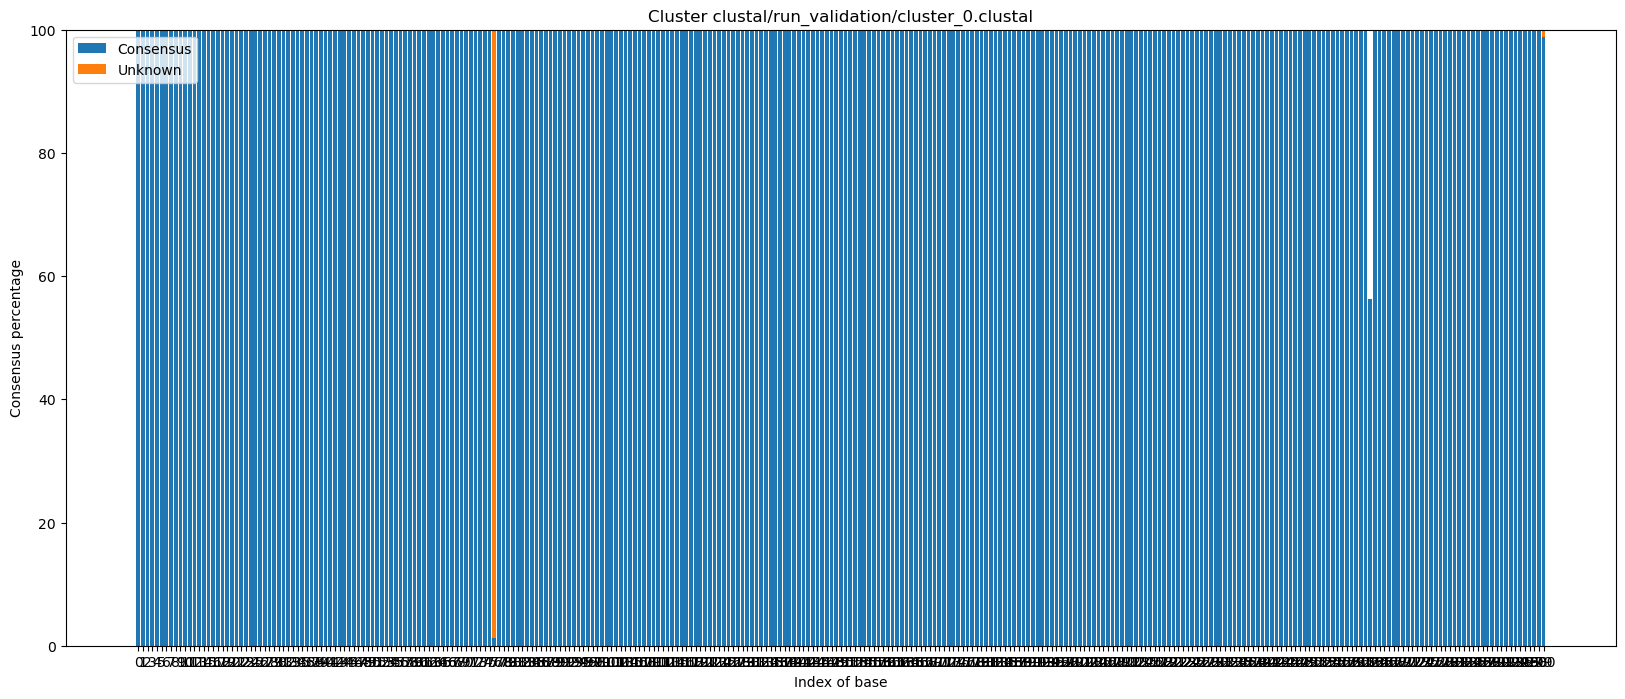

Plot for cluster 1


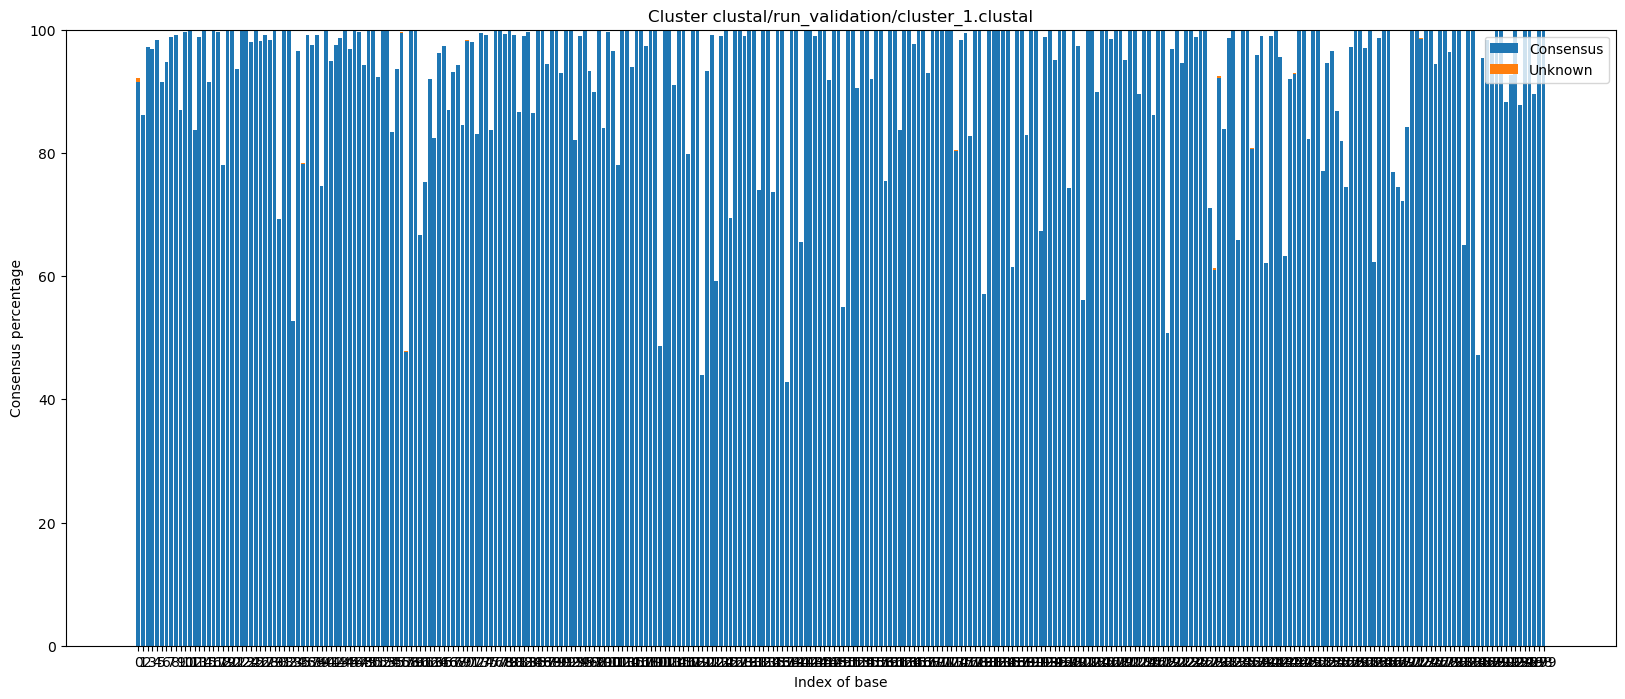

Plot for cluster 2


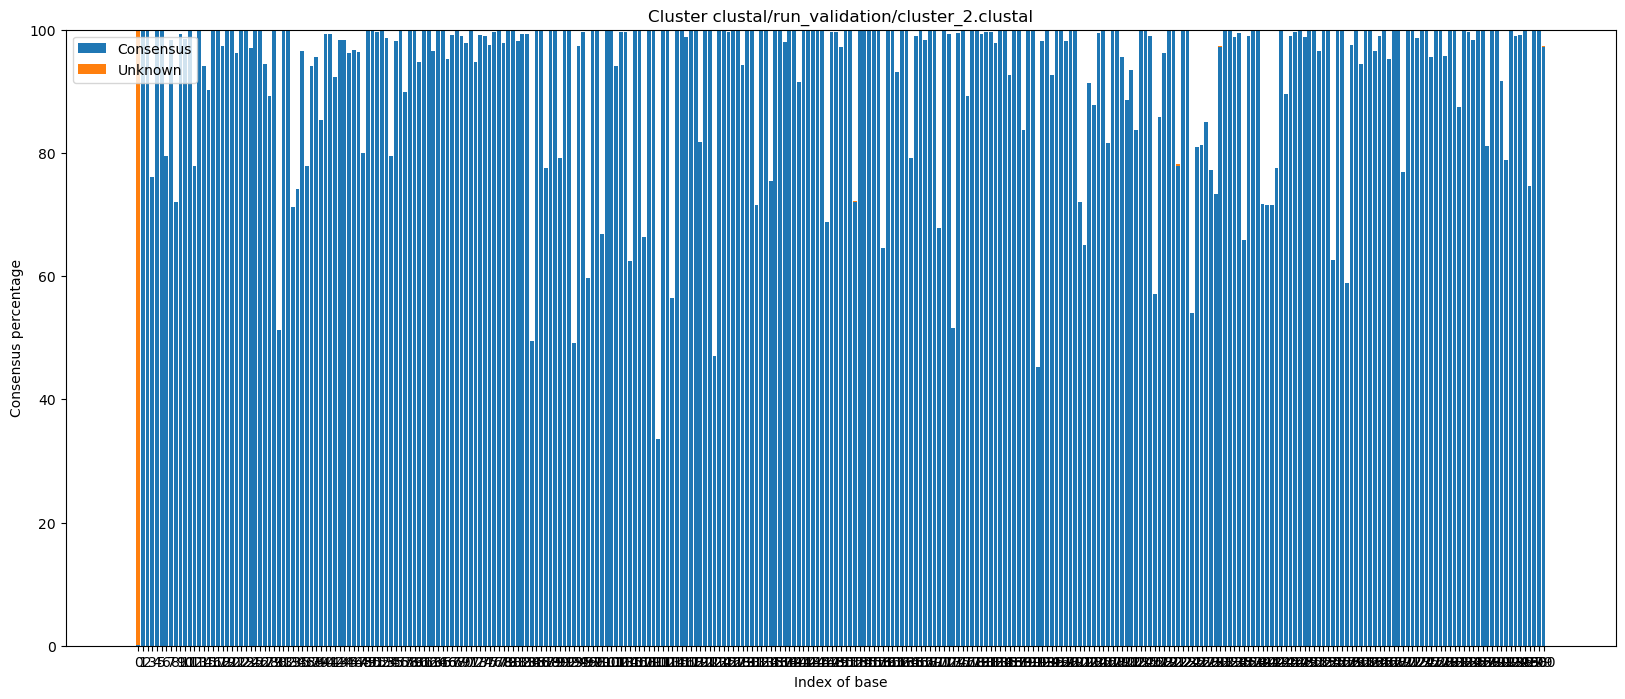

Plot for cluster 3


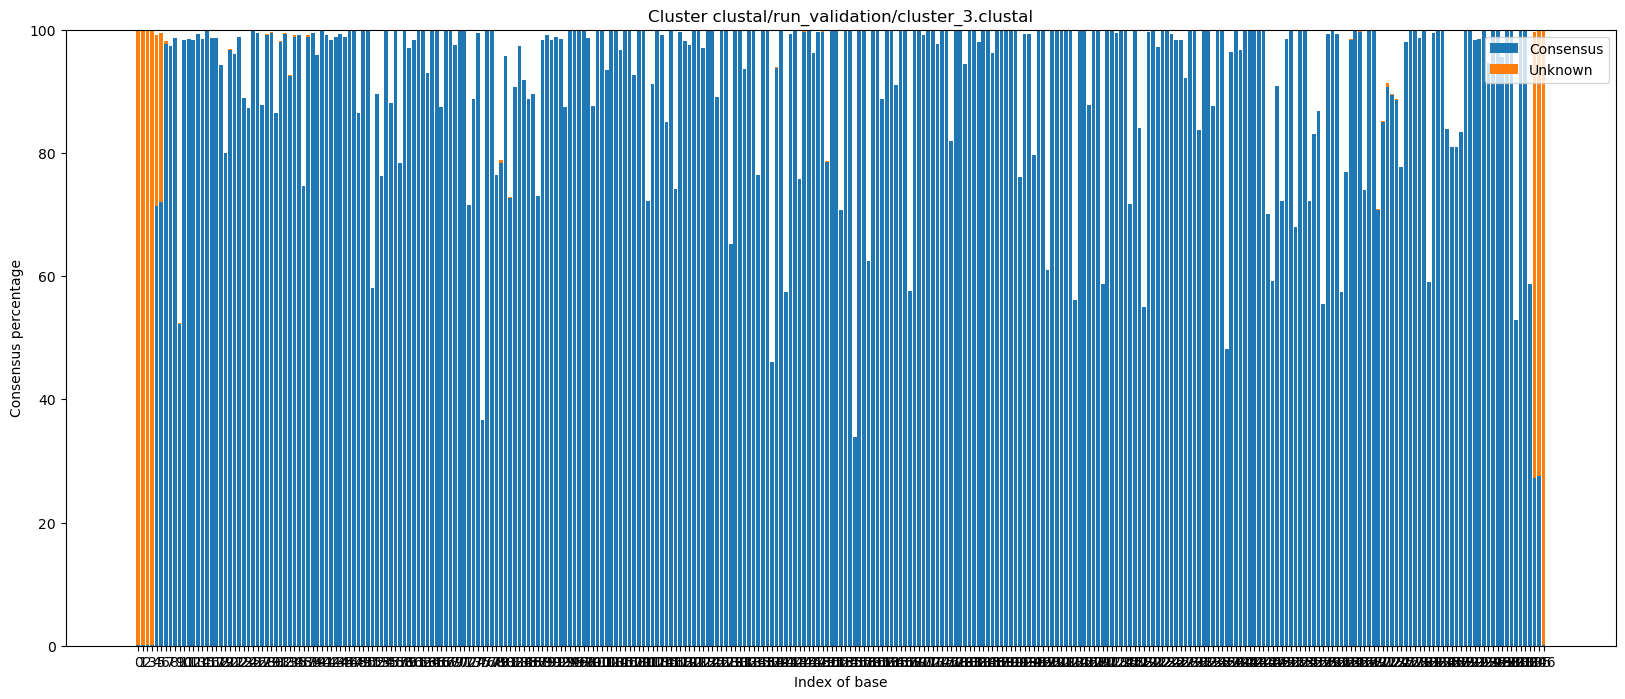

Plot for cluster 4


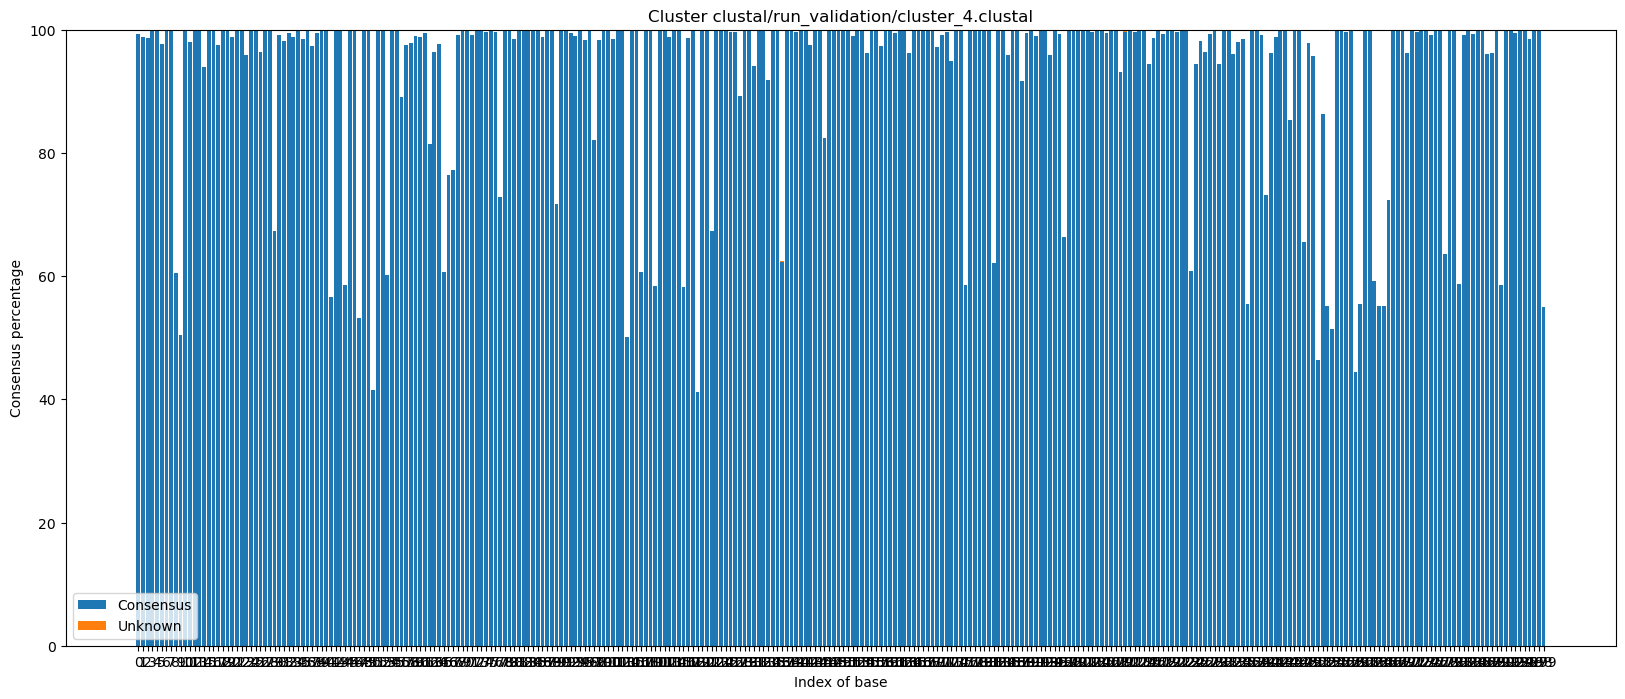

Plot for cluster 5


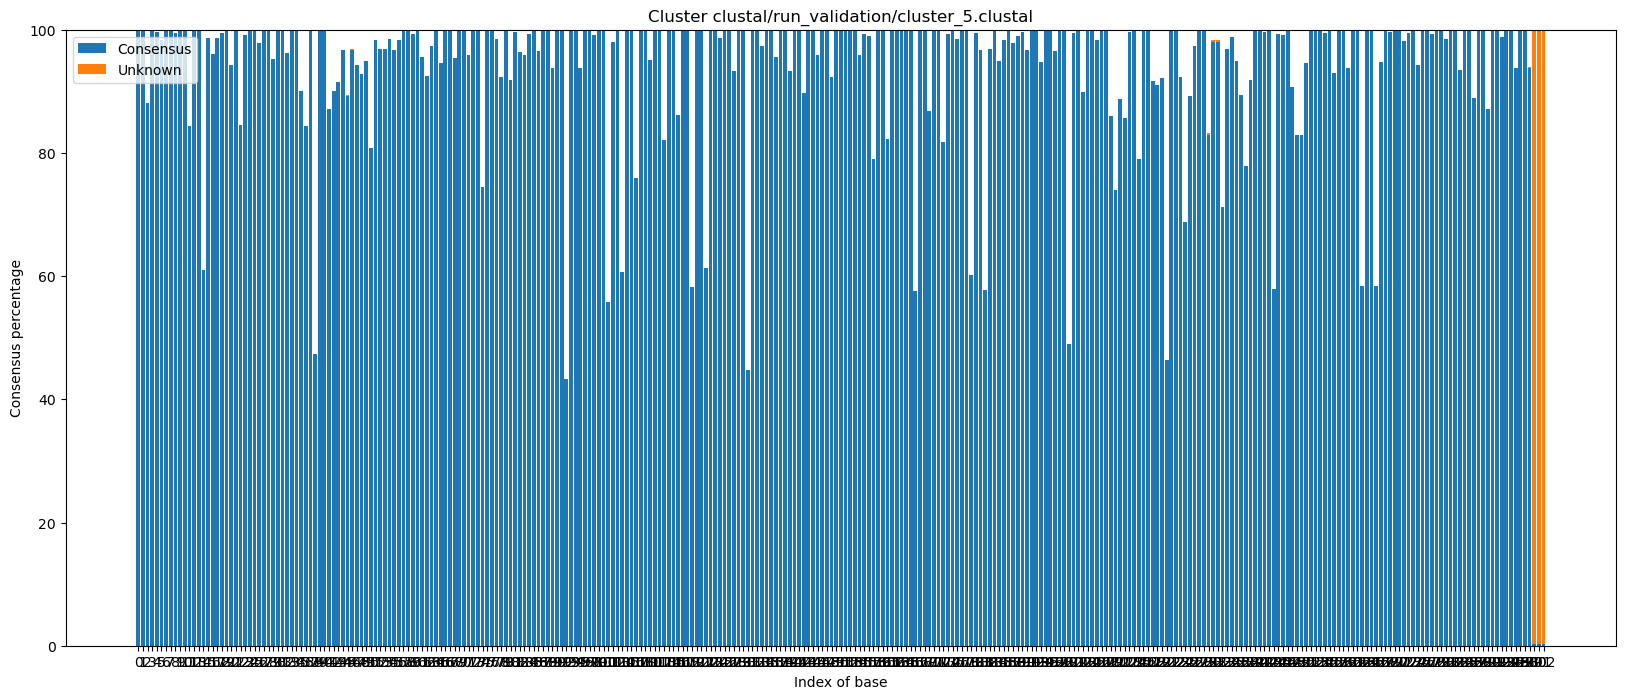

Plot for cluster 6


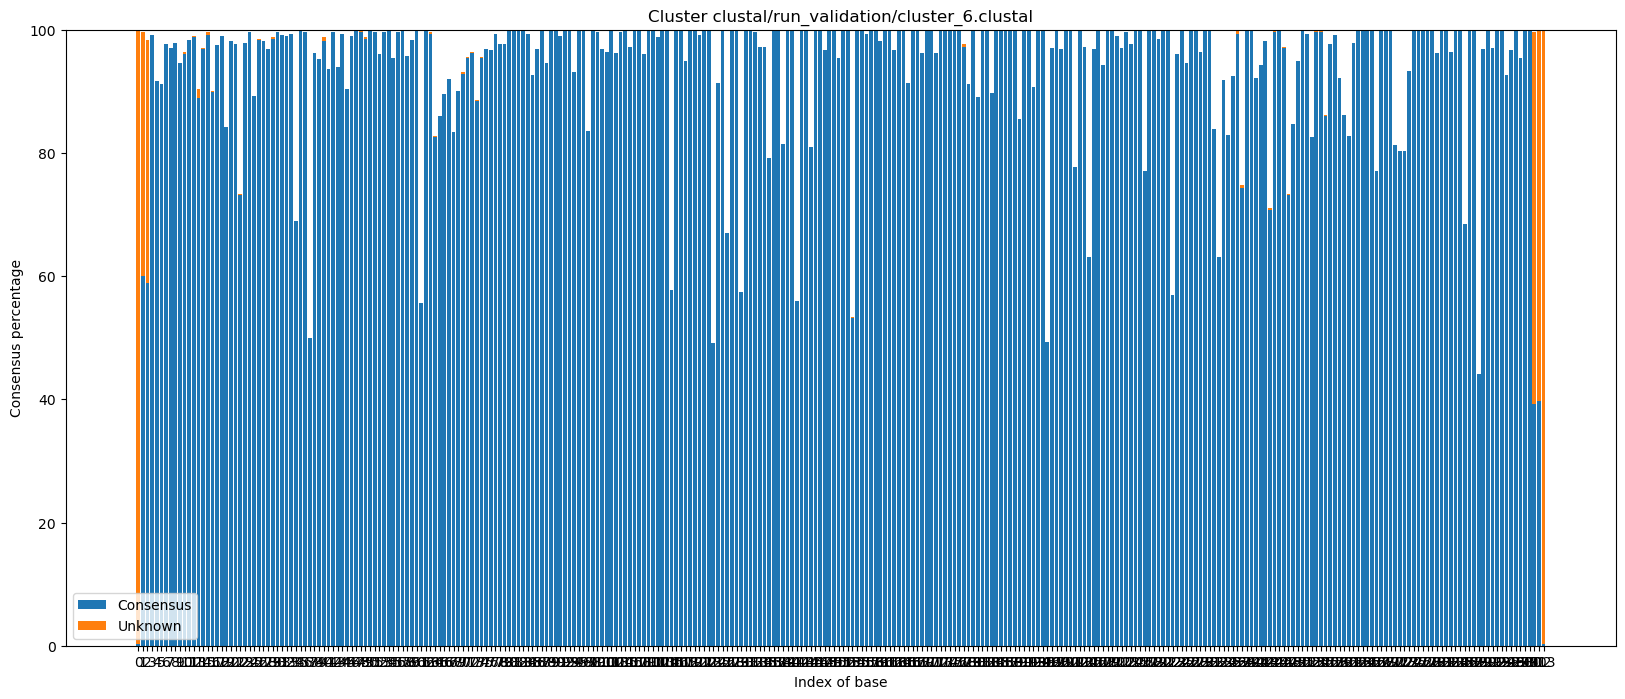

Plot for cluster 7


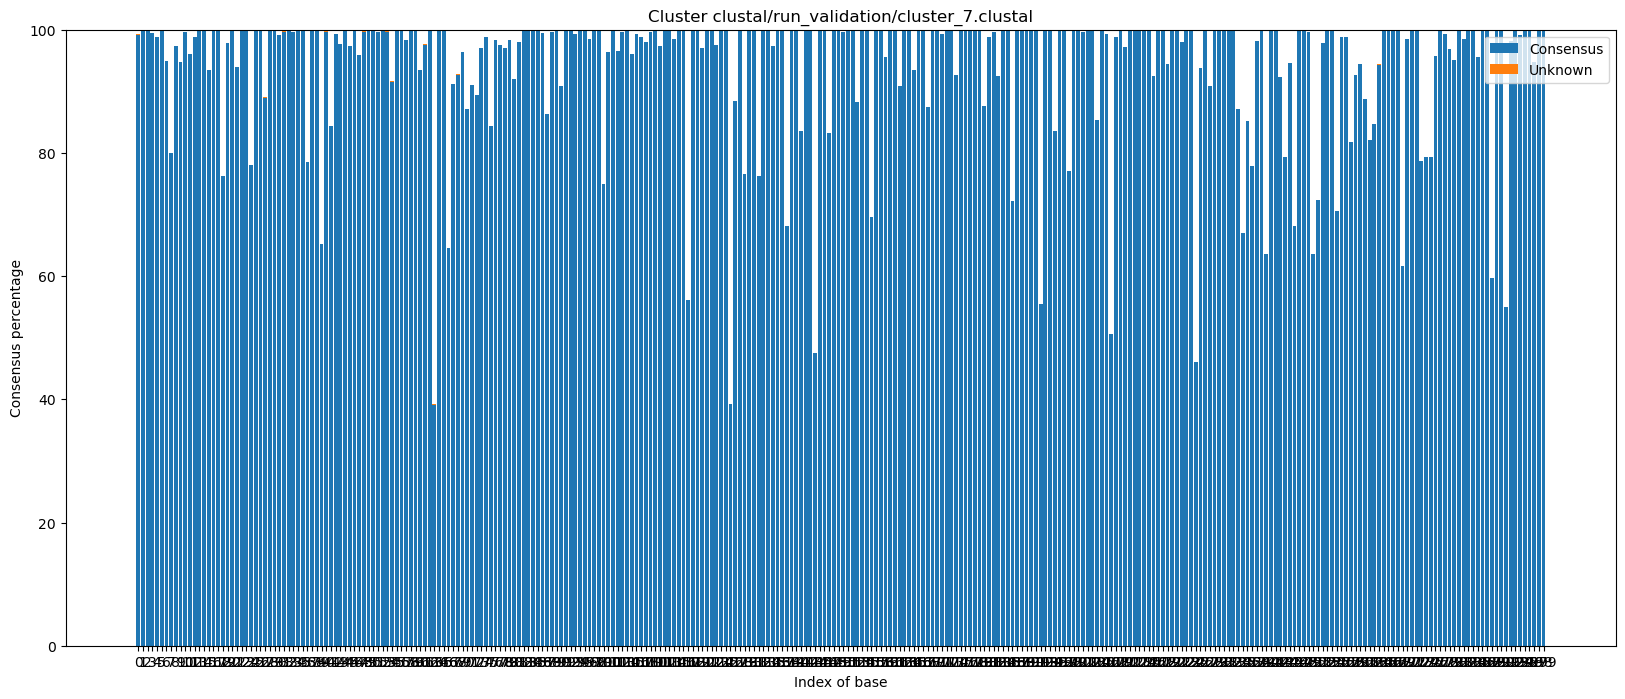

Plot for cluster 8


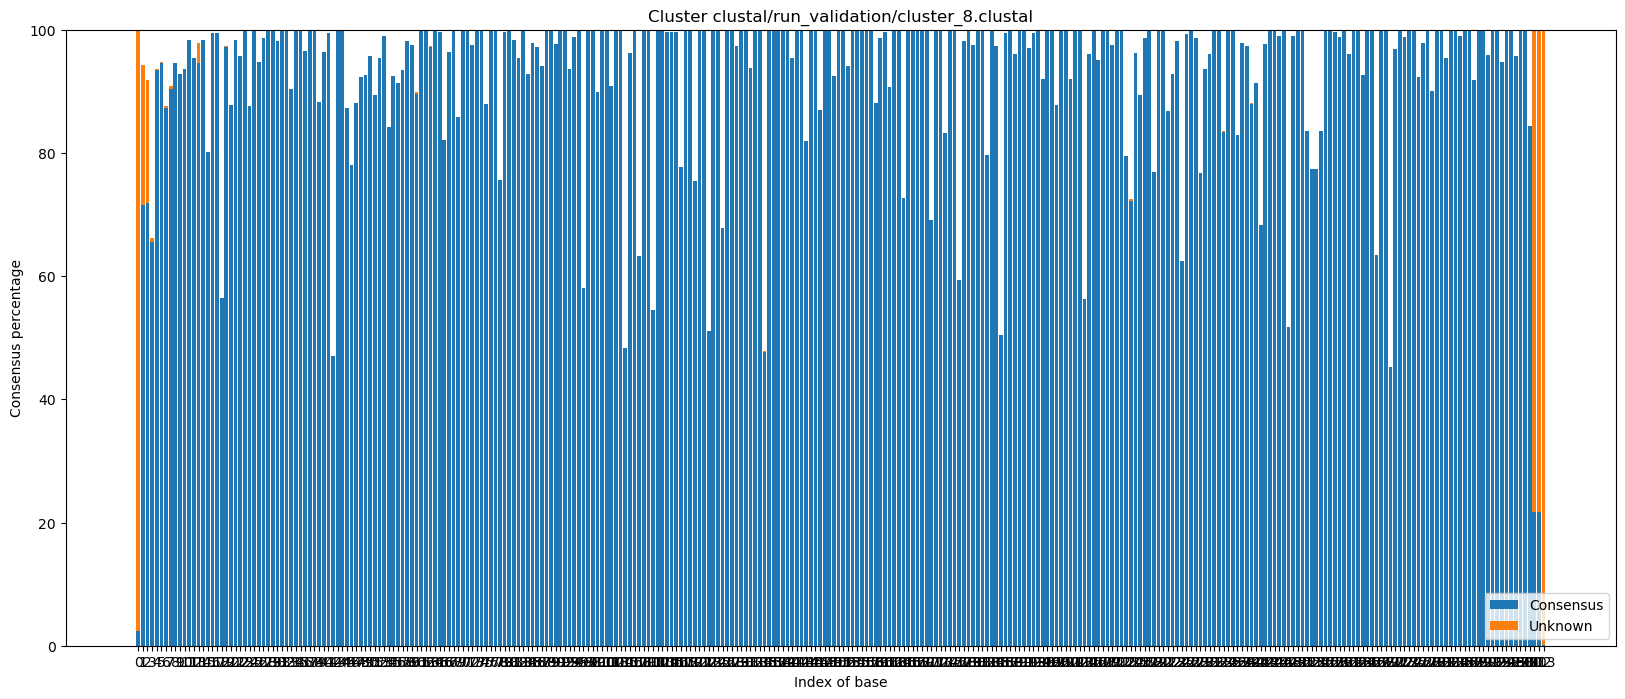

Plot for cluster 9


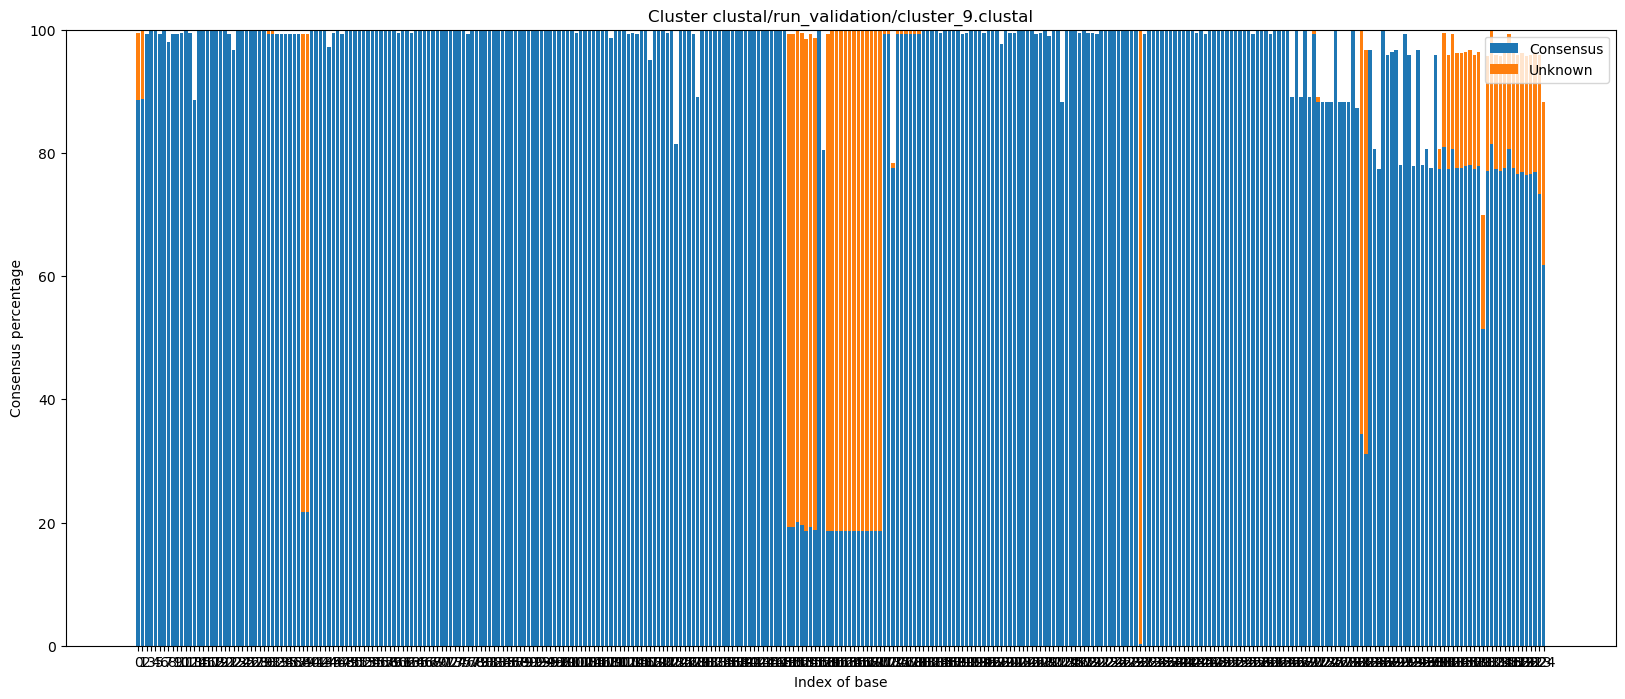

Plot for cluster 10


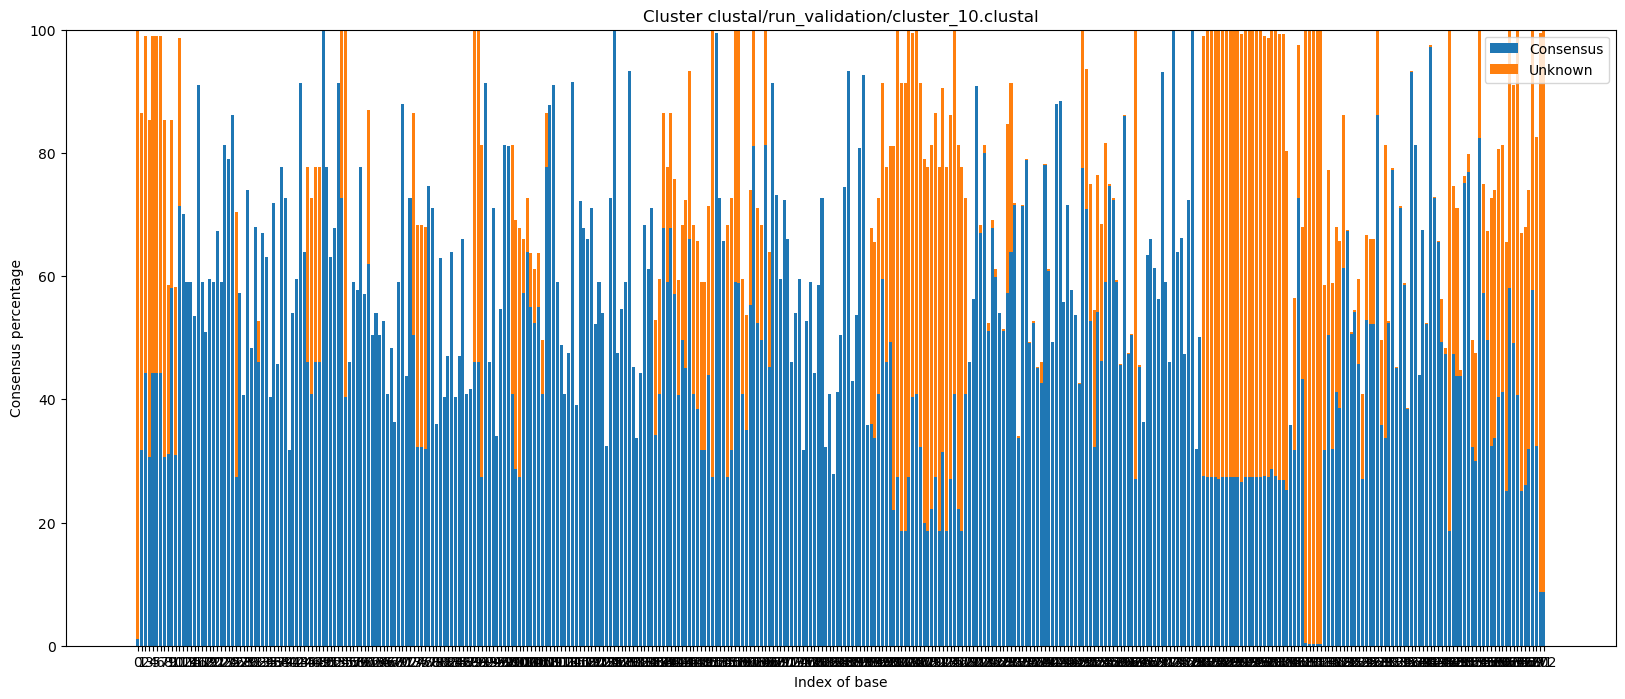

Plot for cluster 11


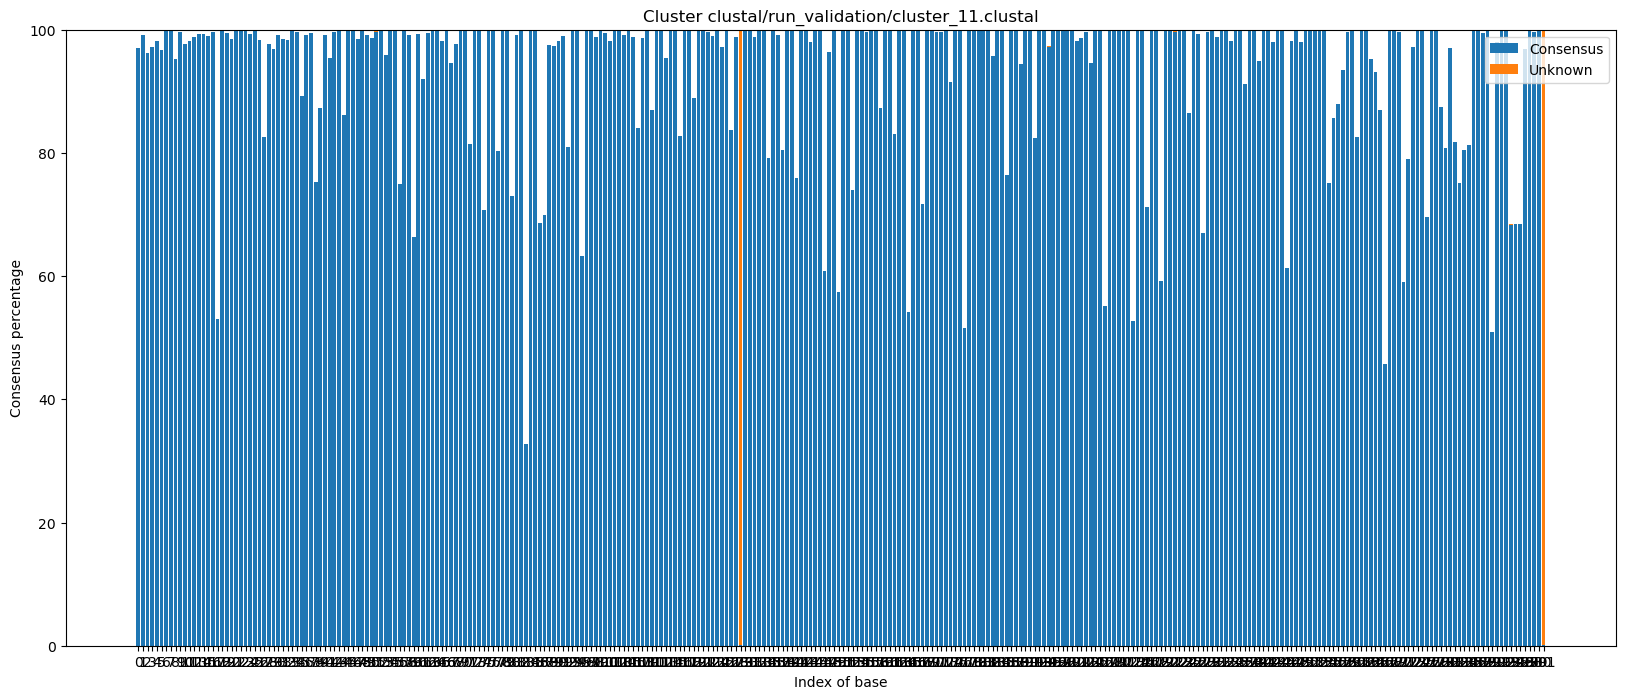

Plot for cluster 12


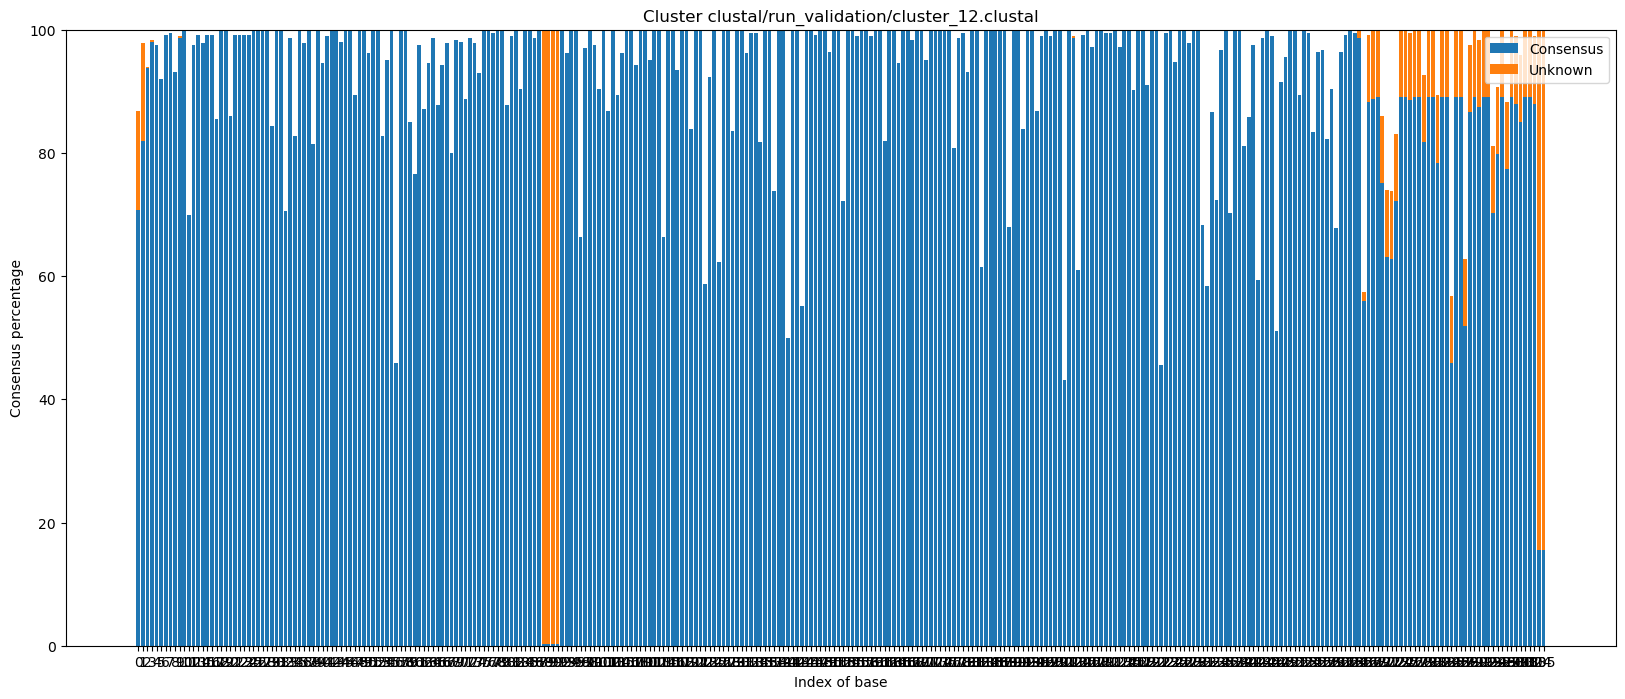

Plot for cluster 13


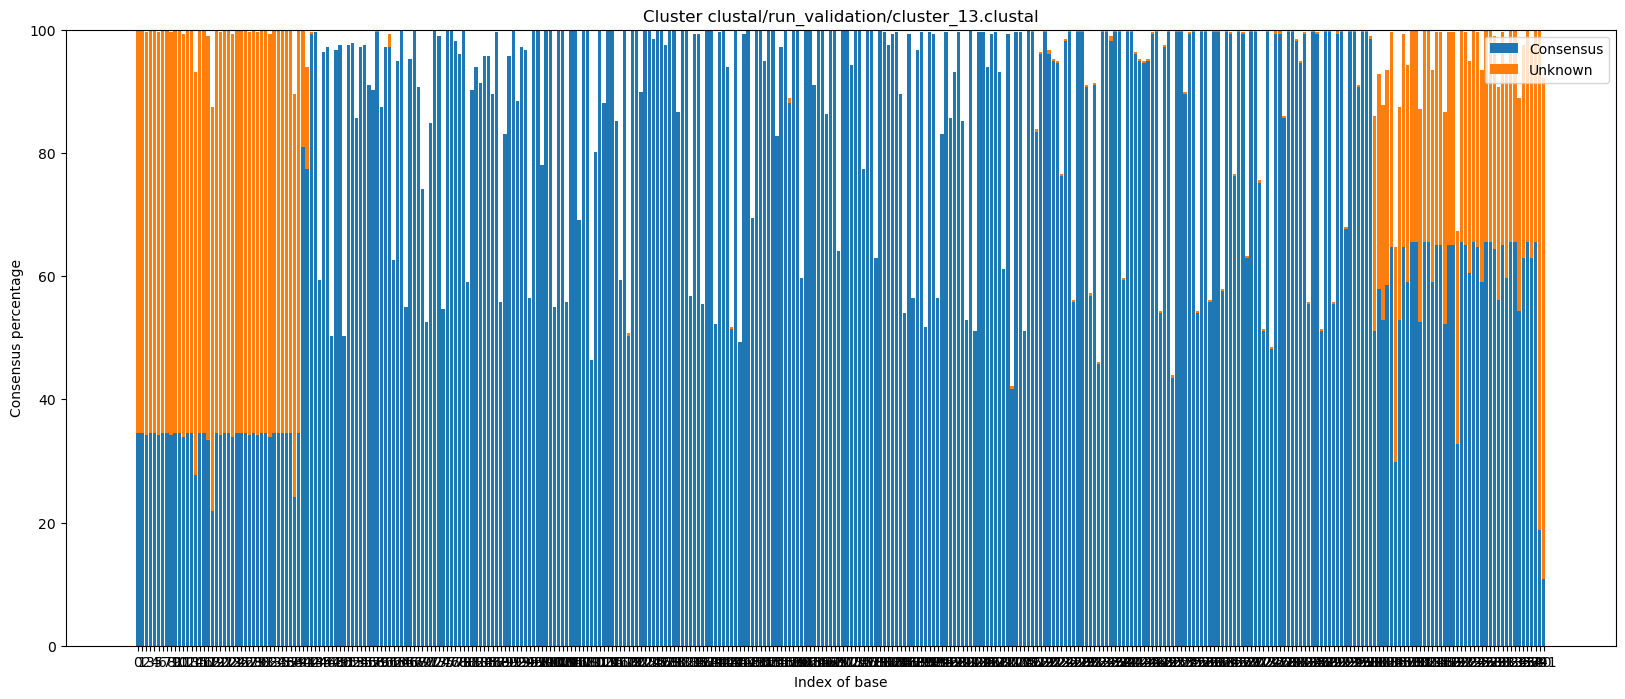

Plot for cluster 14


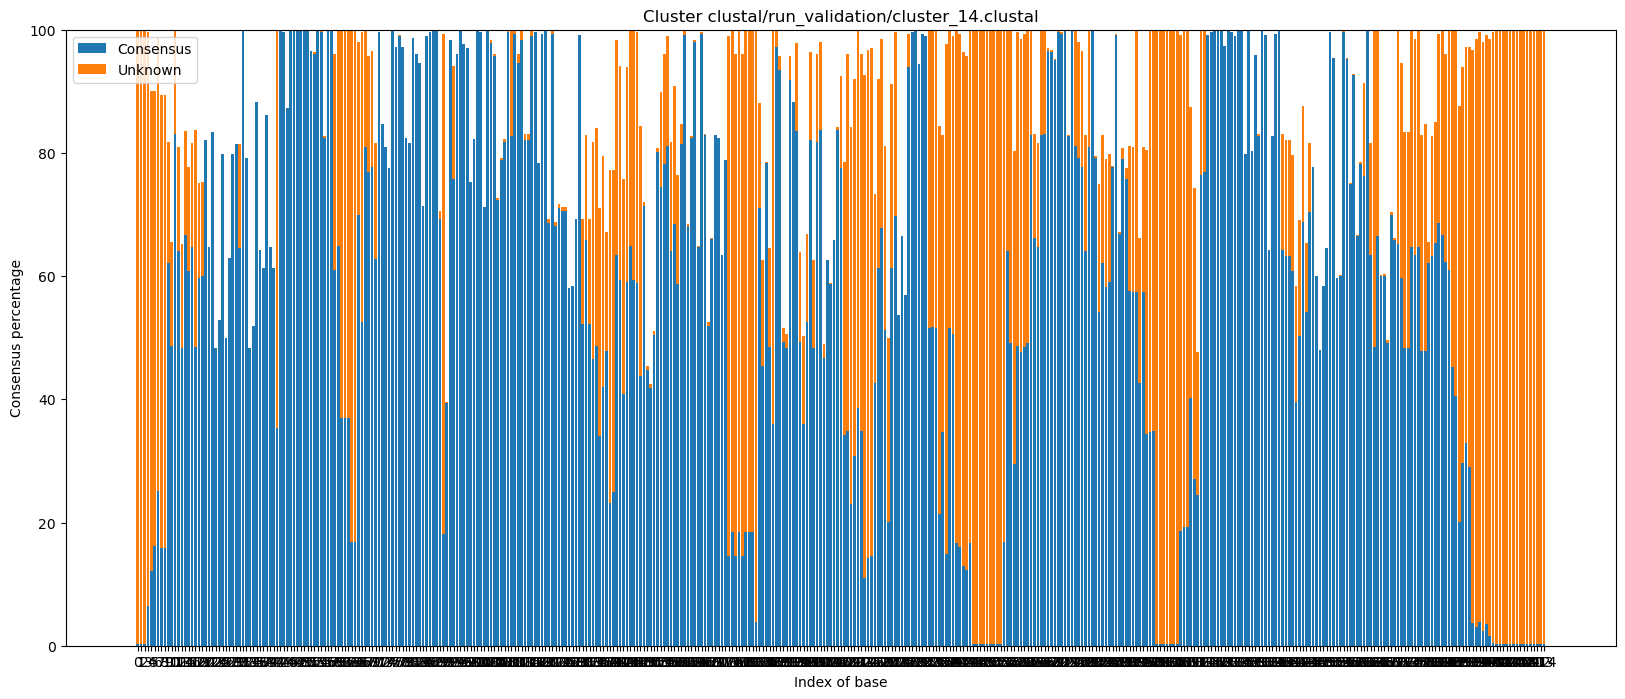

Plot for cluster 15


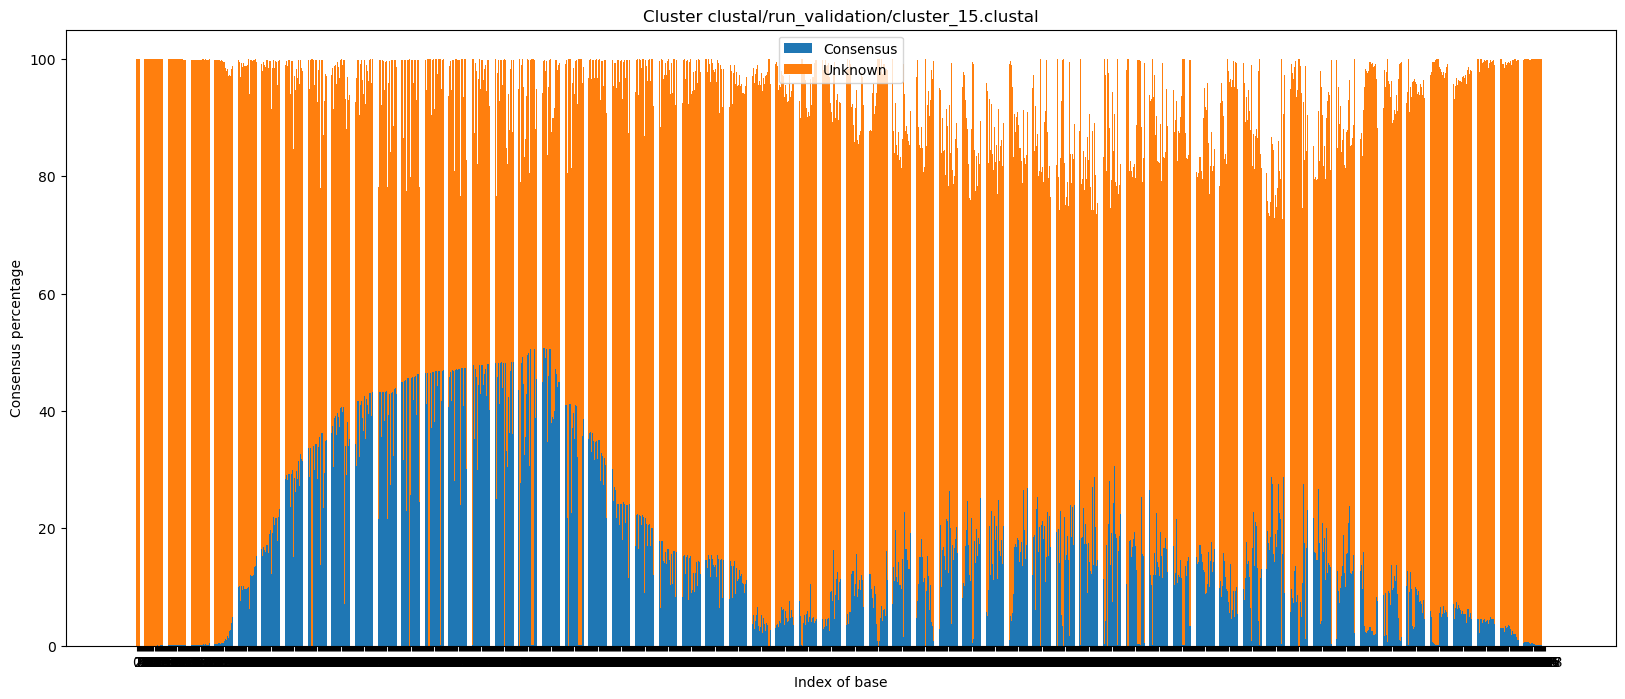

Plot for cluster 16


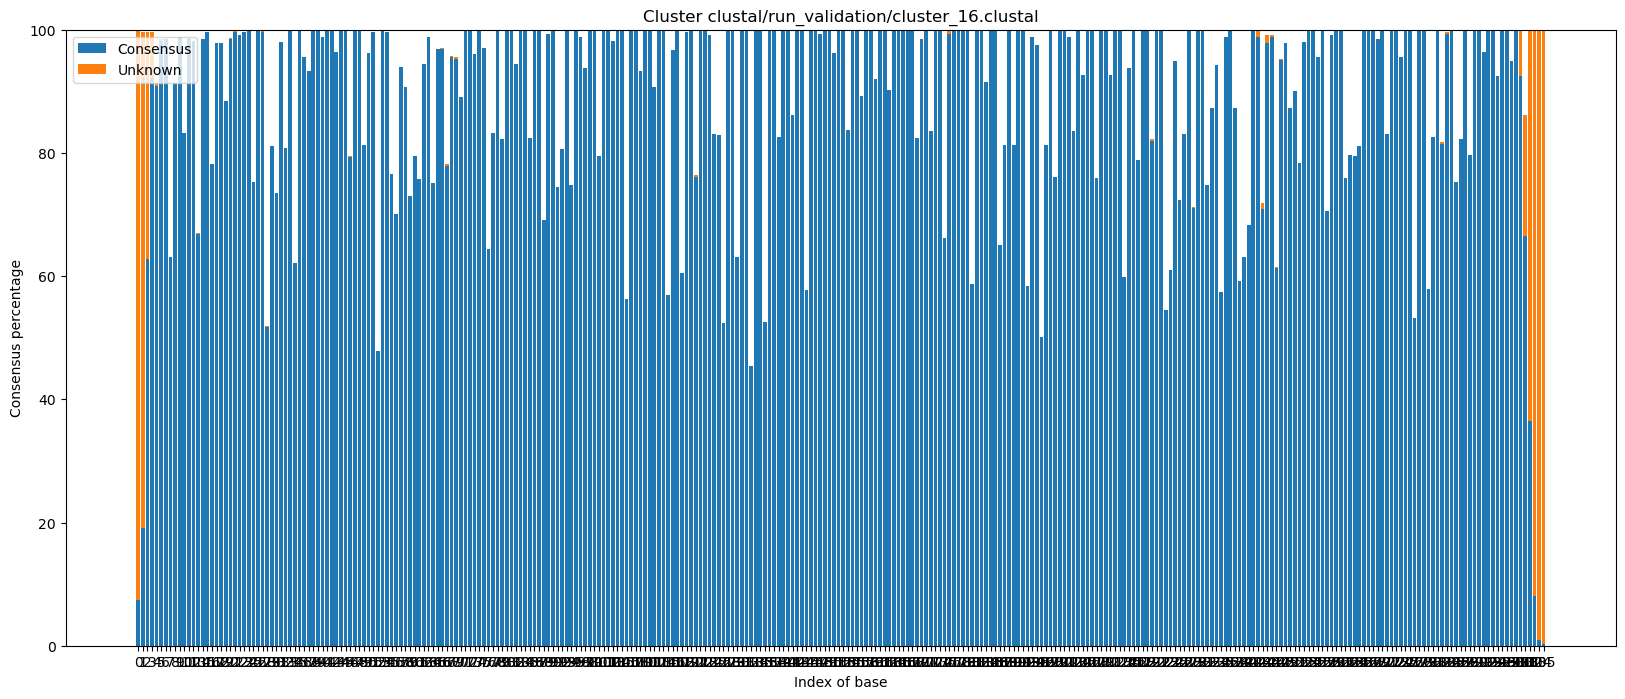

Plot for cluster 17


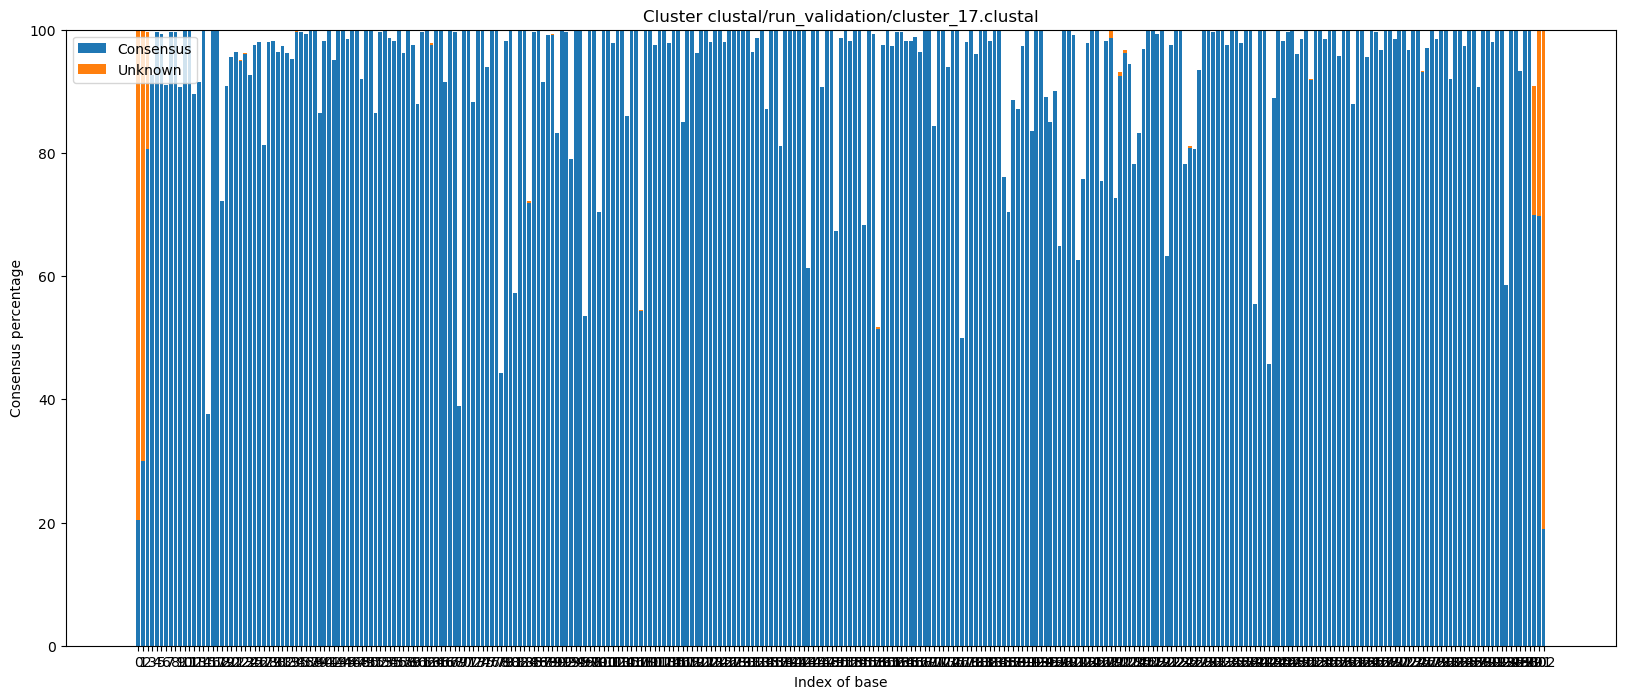

Plot for cluster 18


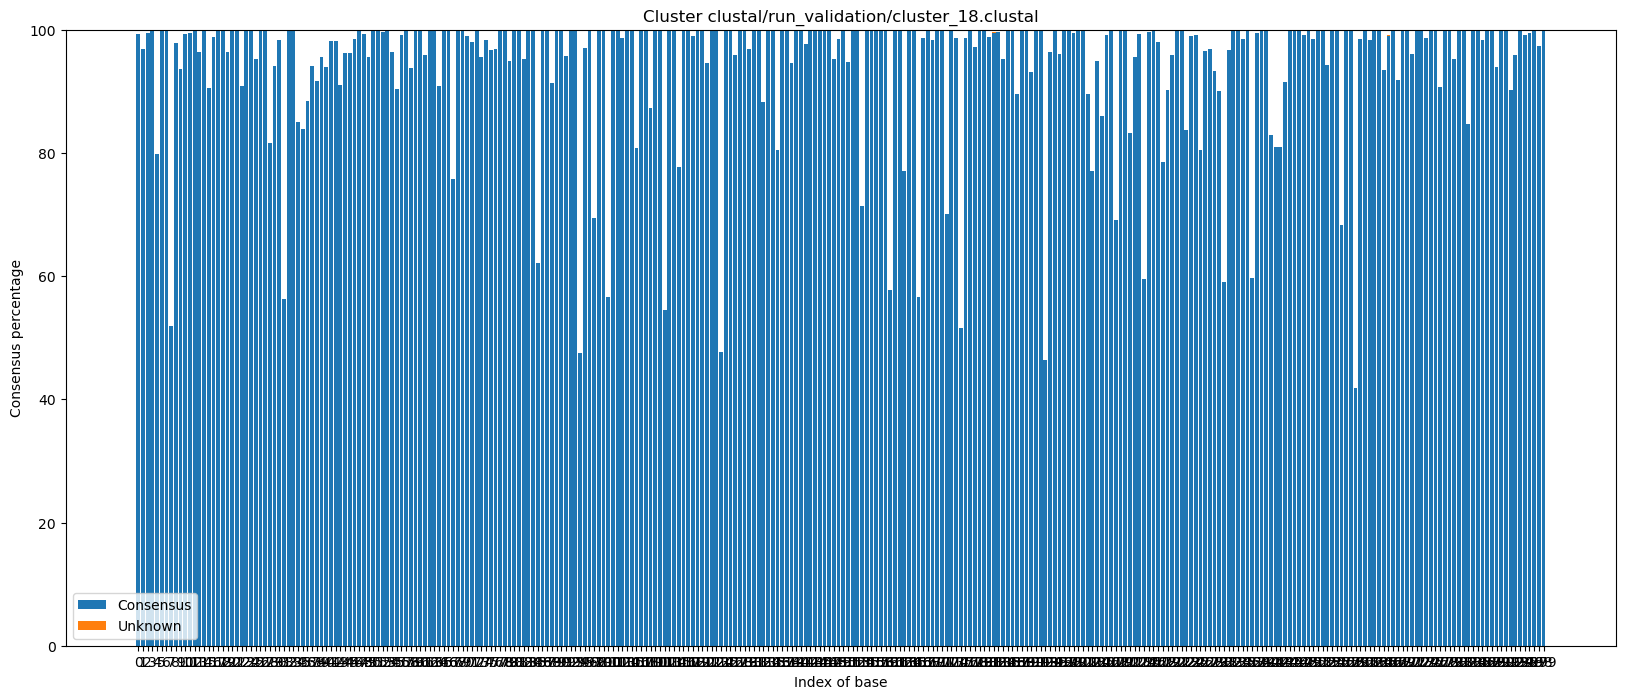

Plot for cluster 19


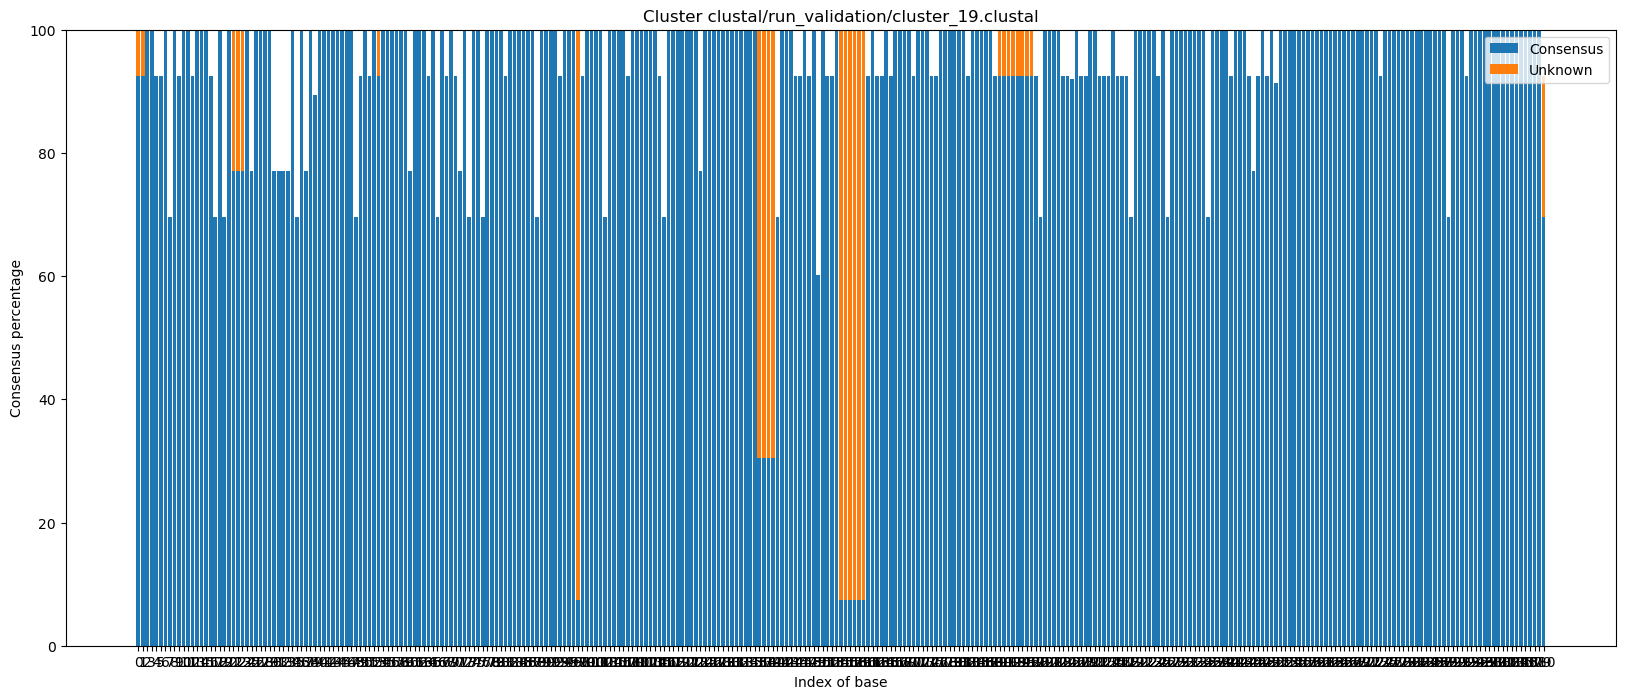

Plot for cluster 20


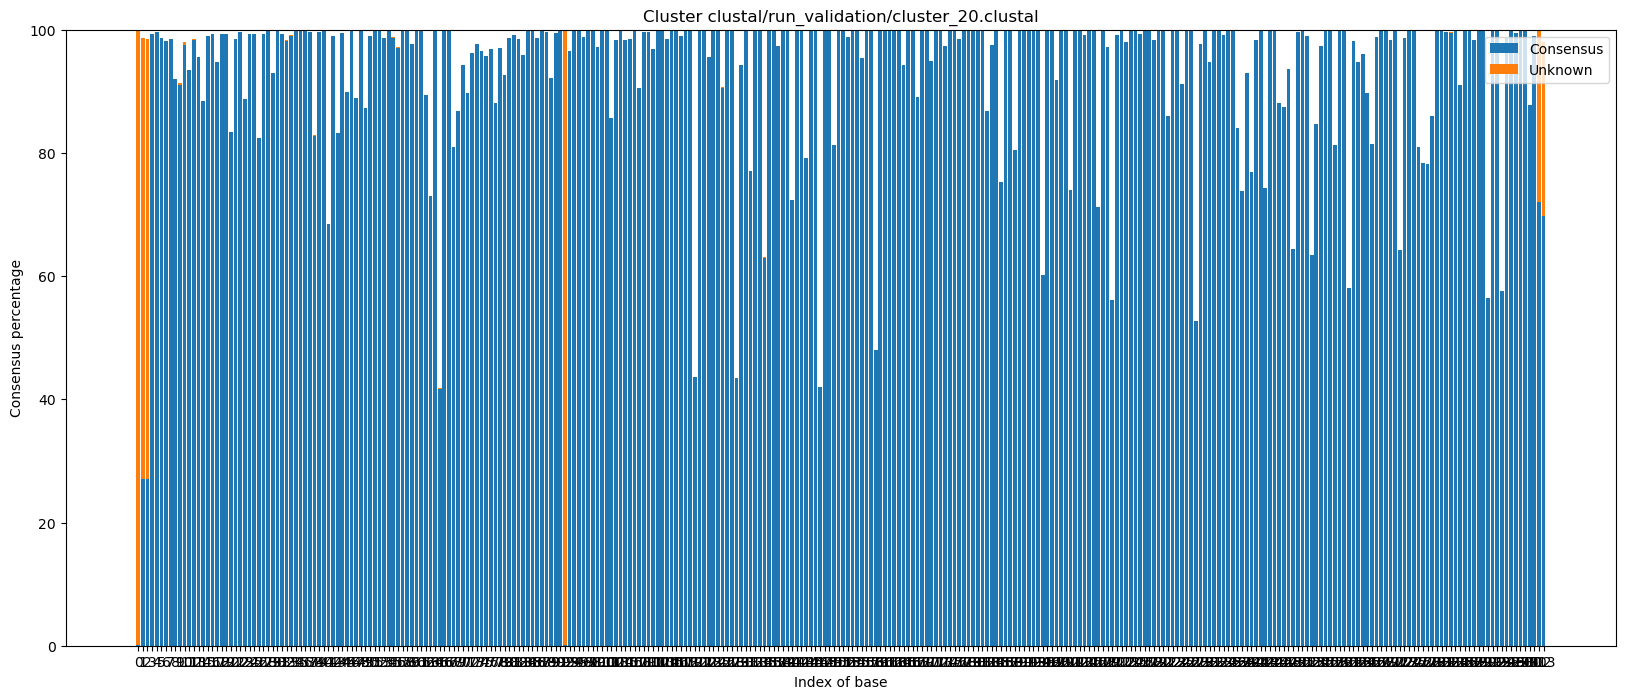

Plot for cluster 21


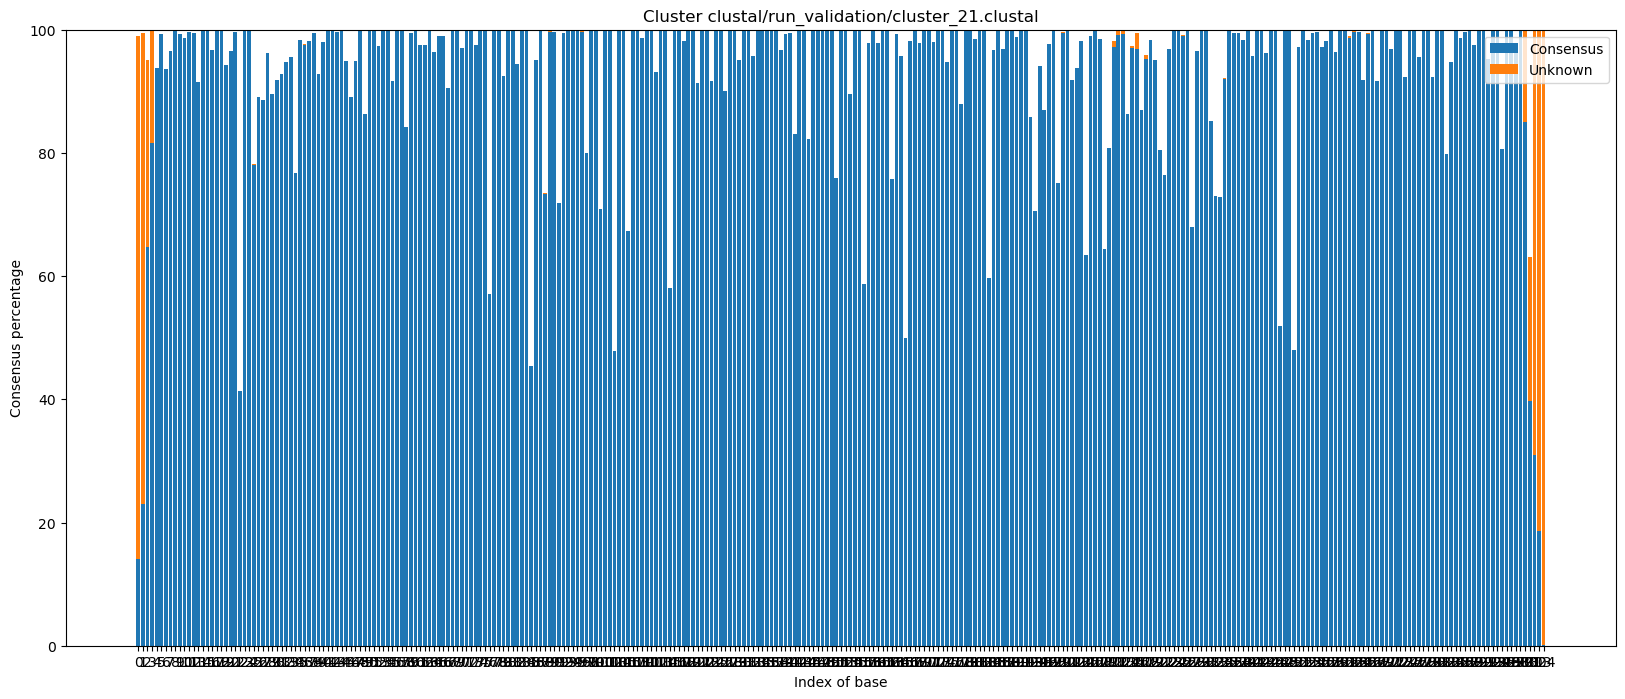

Plot for cluster 22


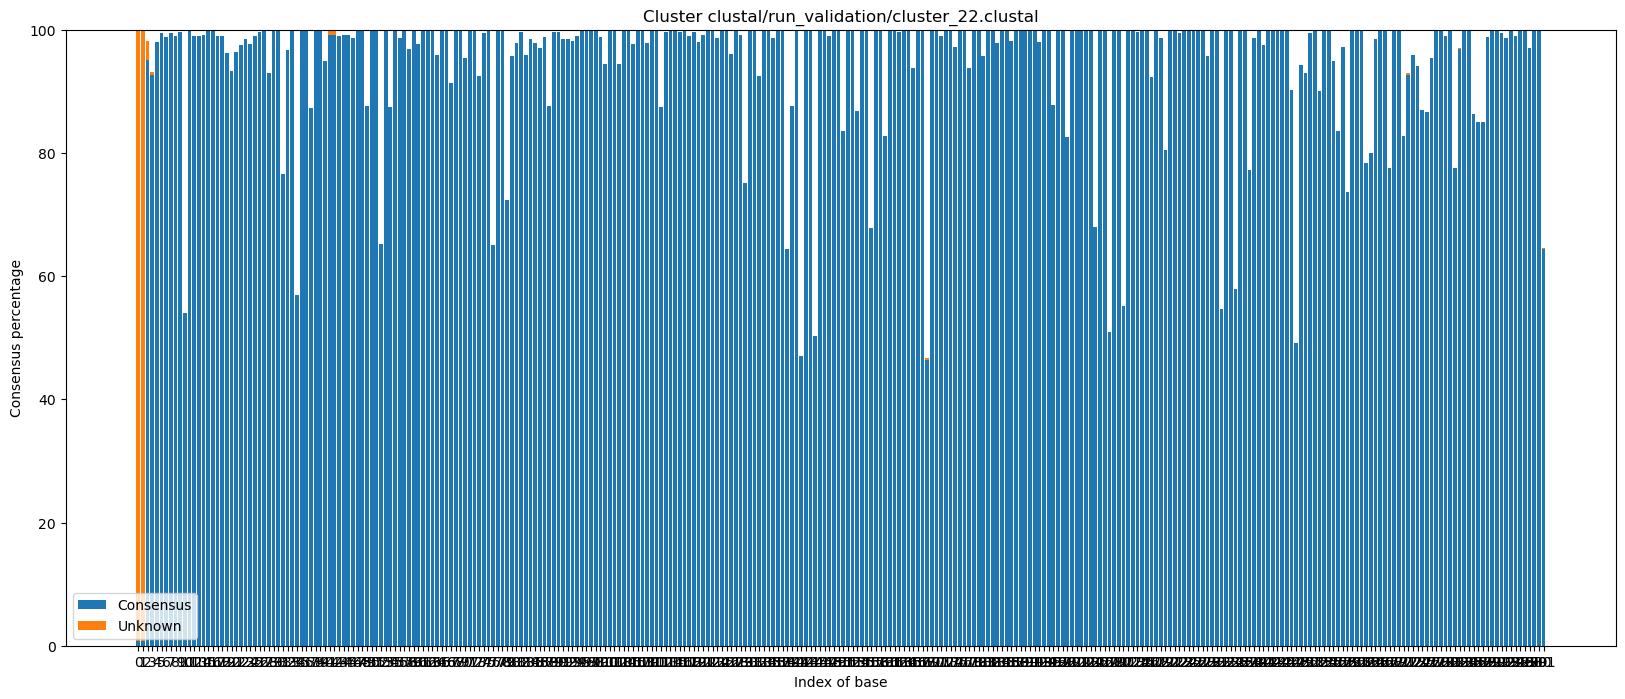

Plot for cluster 23


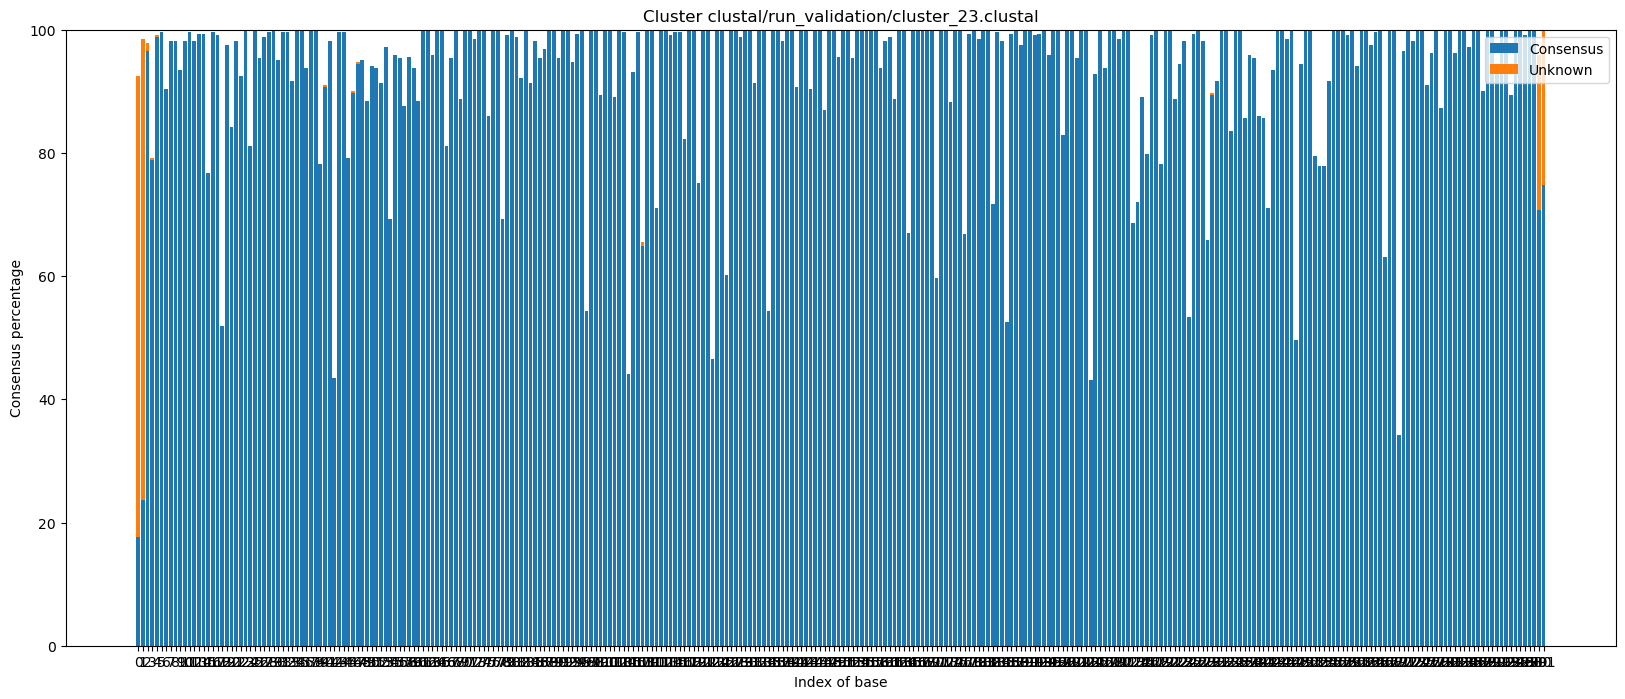

Plot for cluster 24


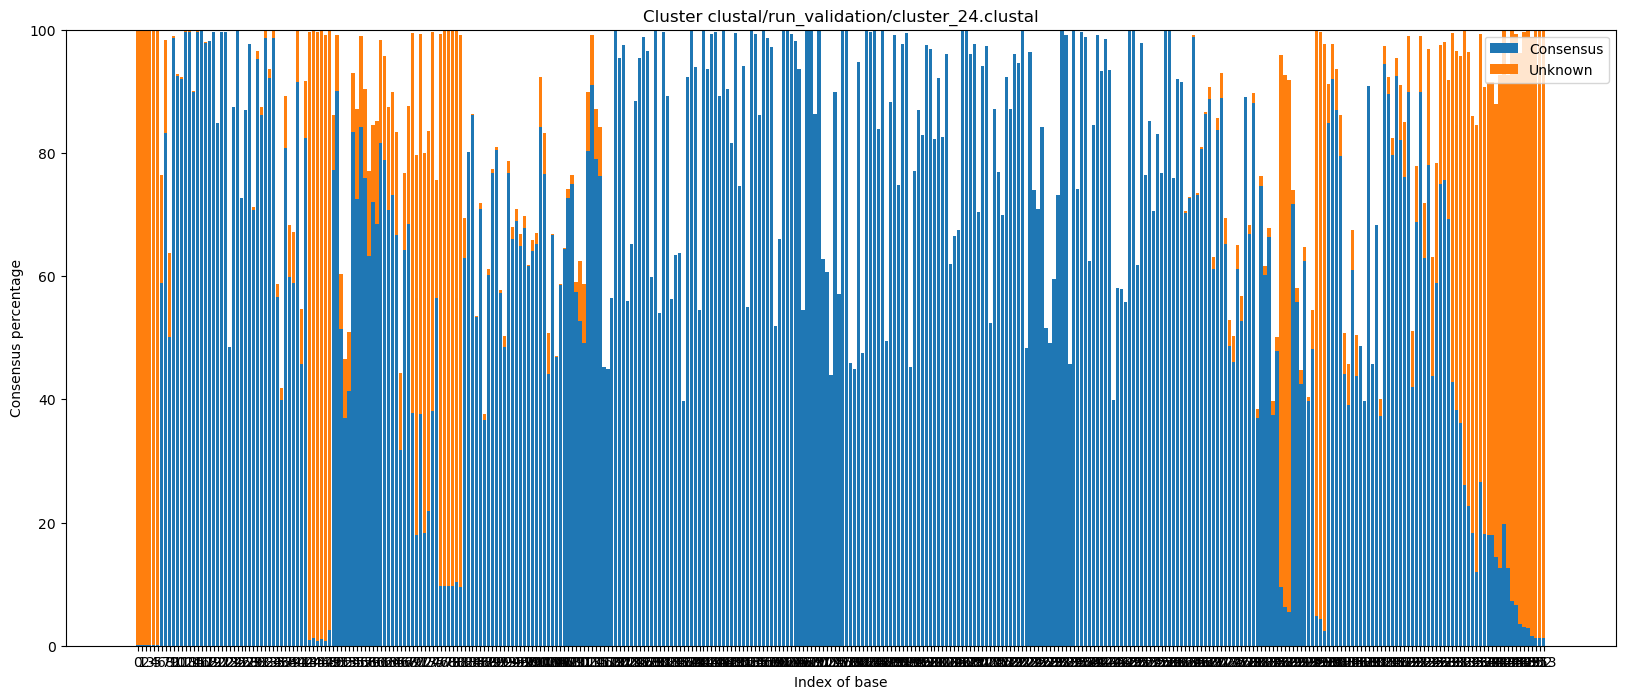

Plot for cluster 25


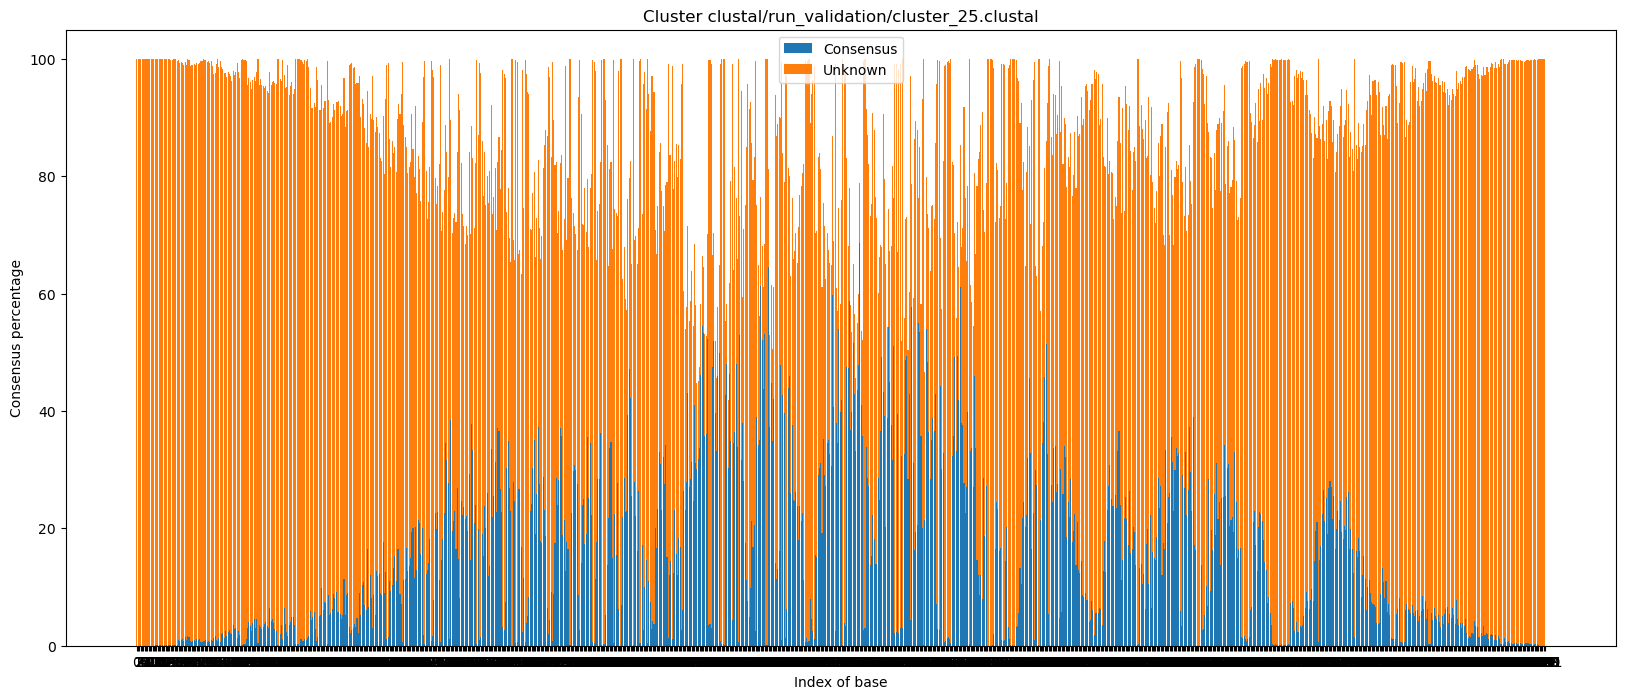

Plot for cluster 26


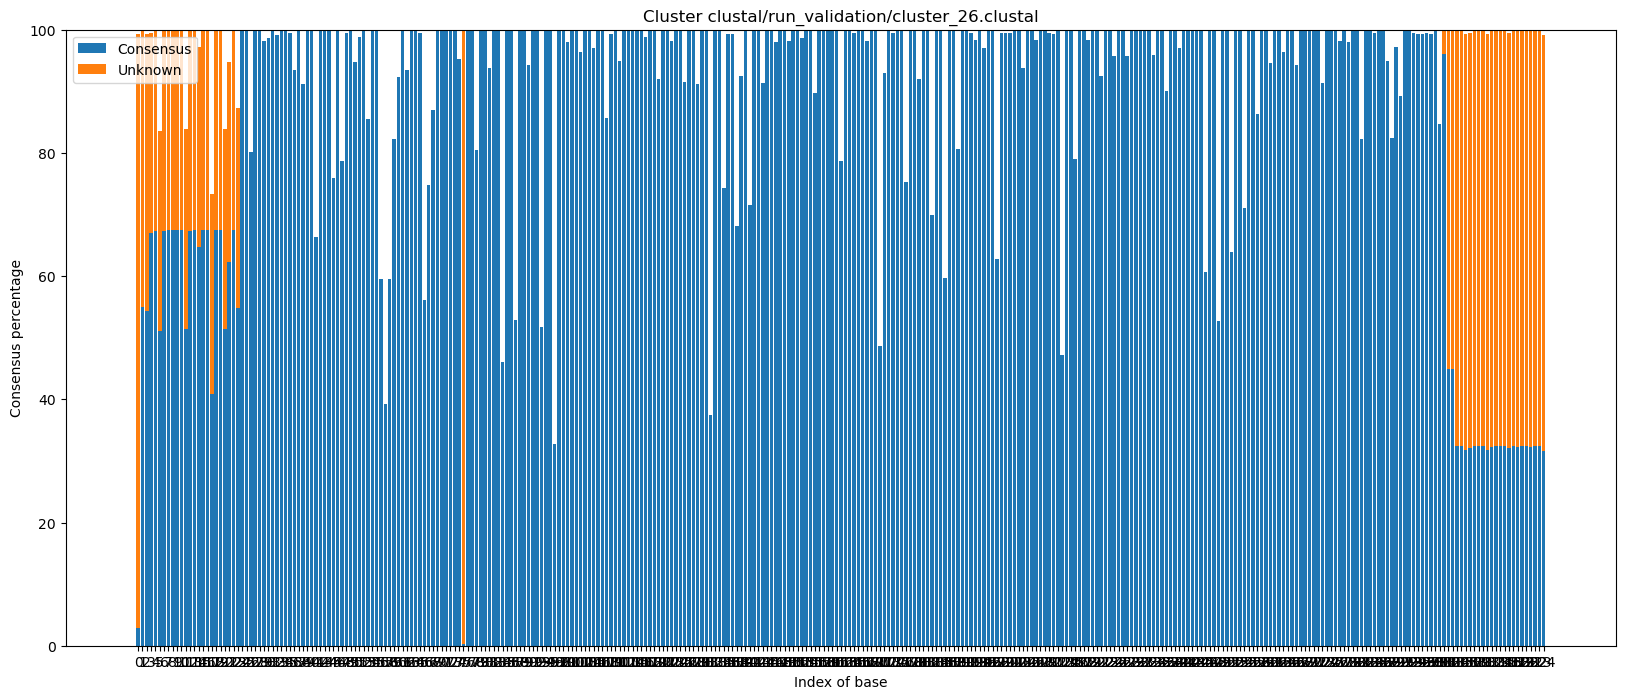

Plot for cluster 27


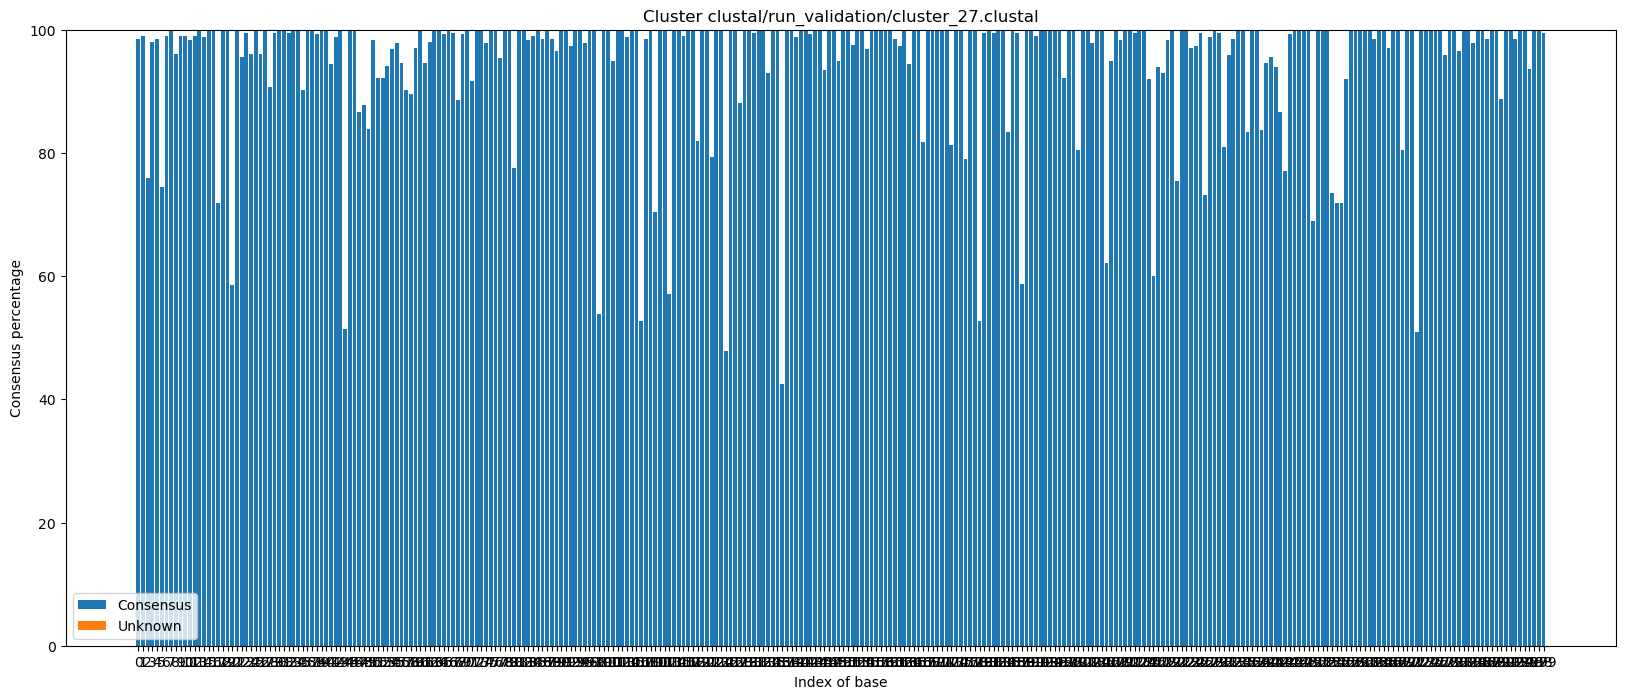

Plot for cluster 28


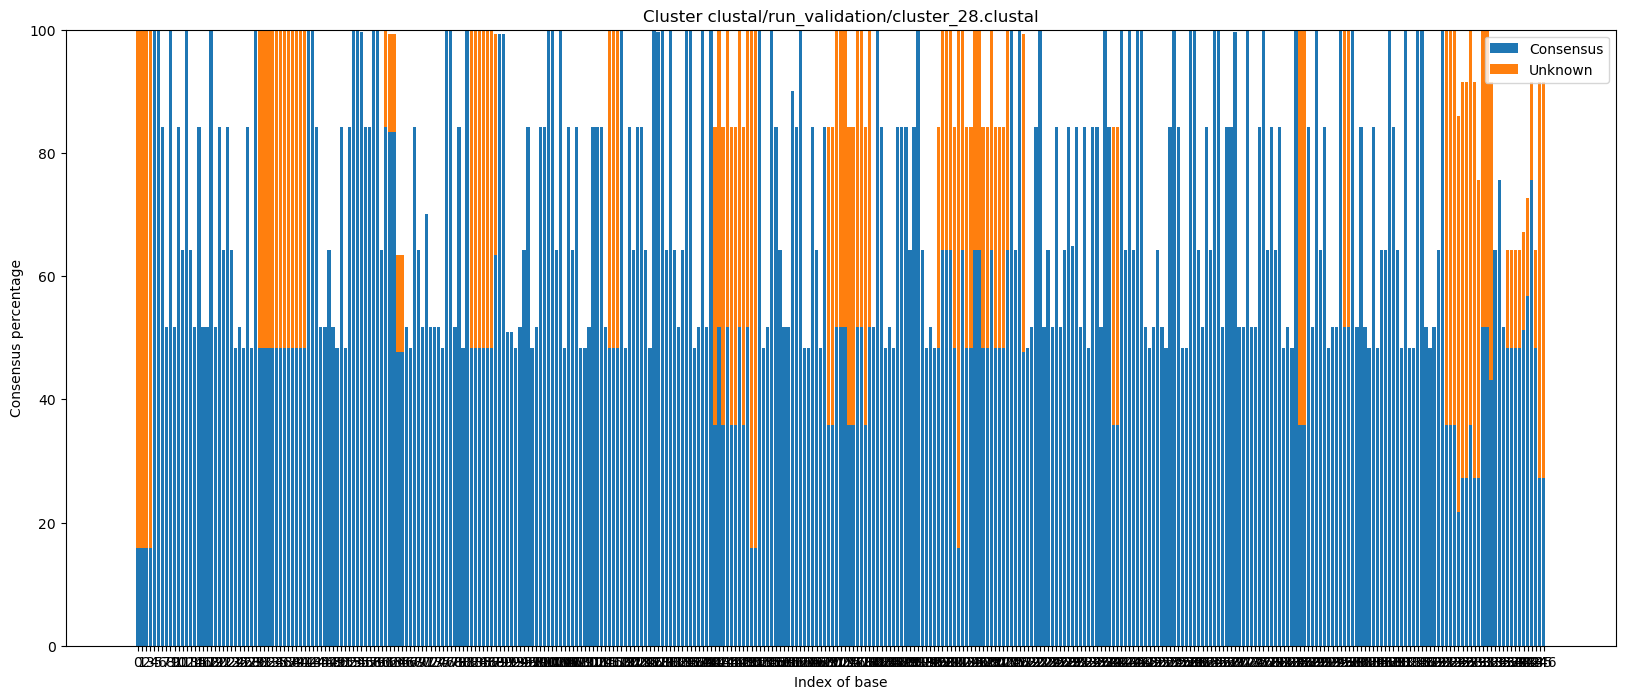

Plot for cluster 29


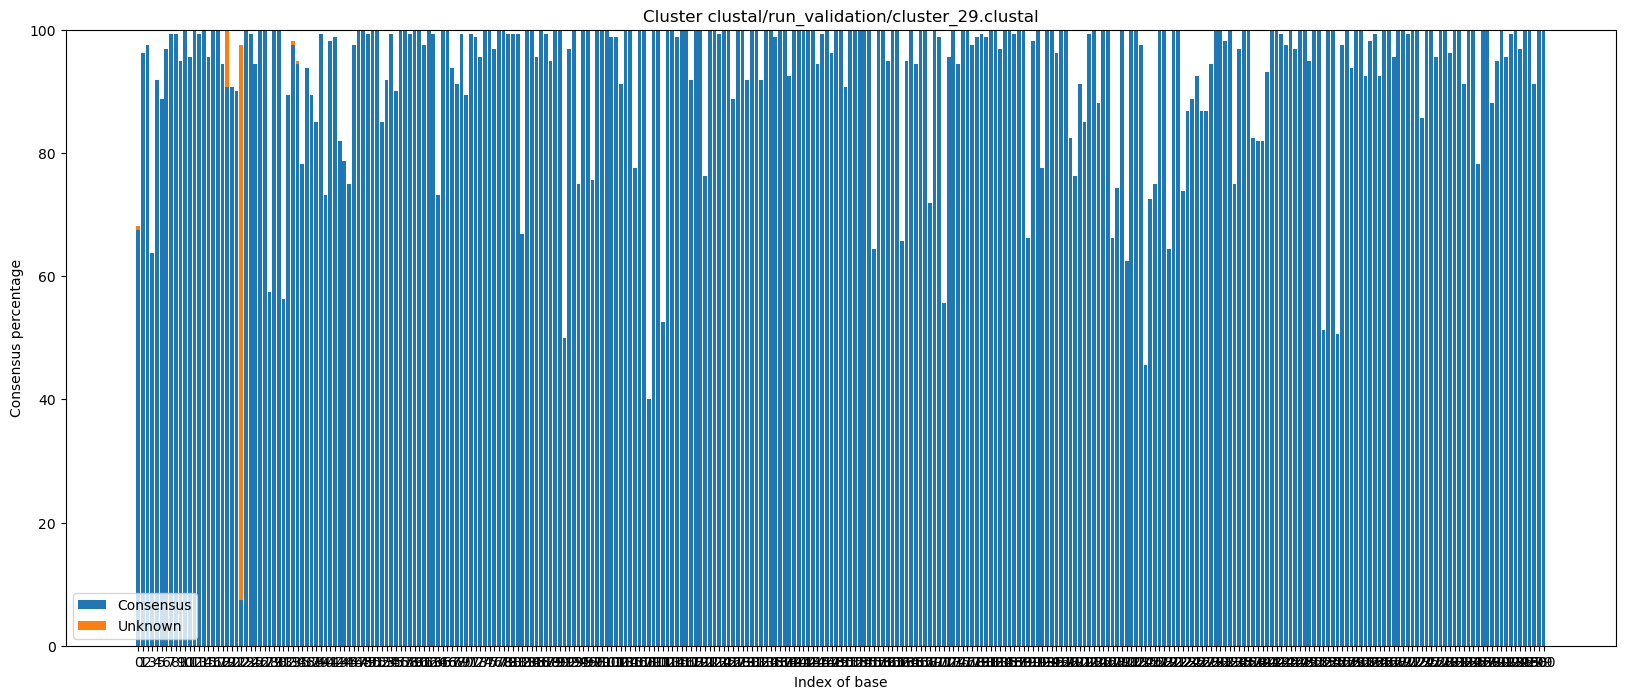

Plot for cluster 30


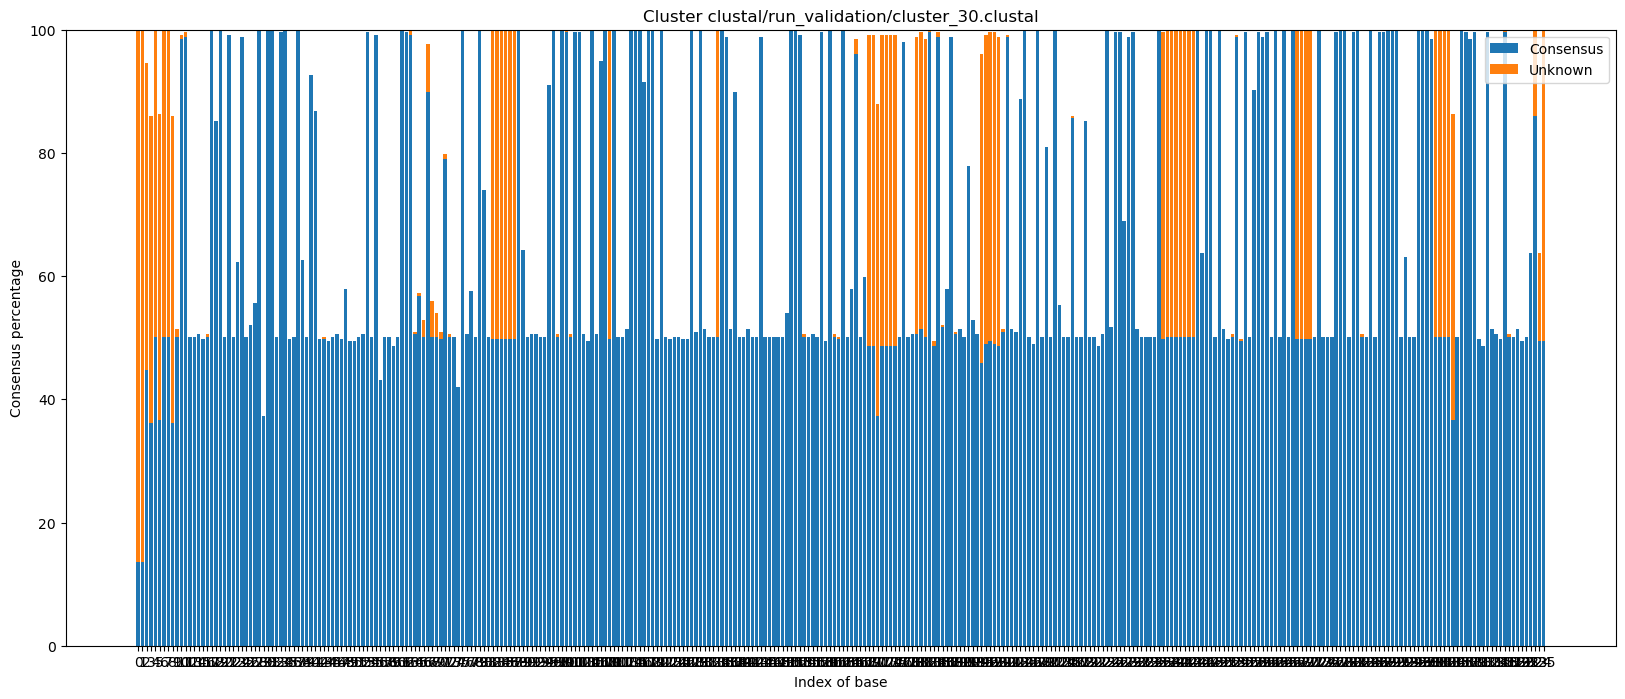

Plot for cluster 31


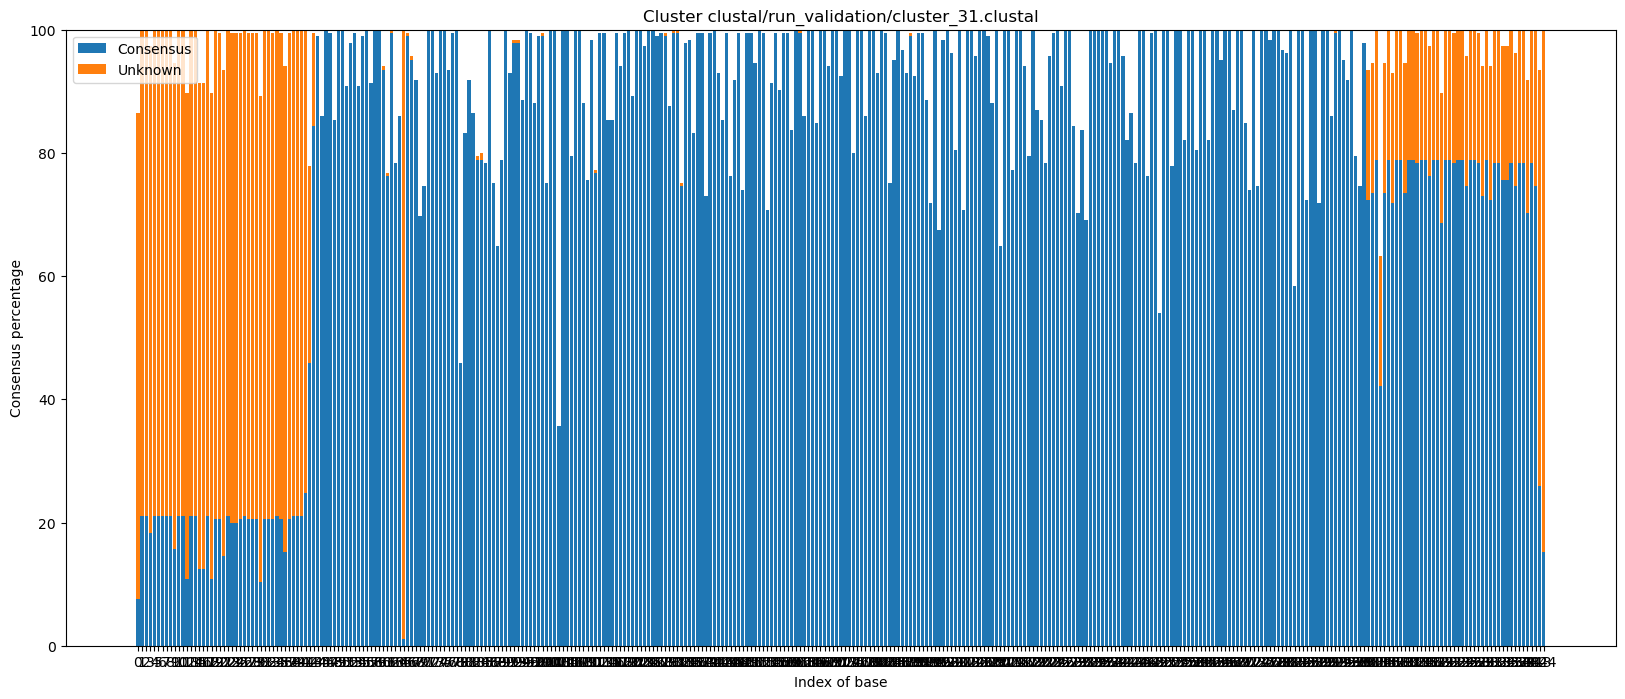

Plot for cluster 32


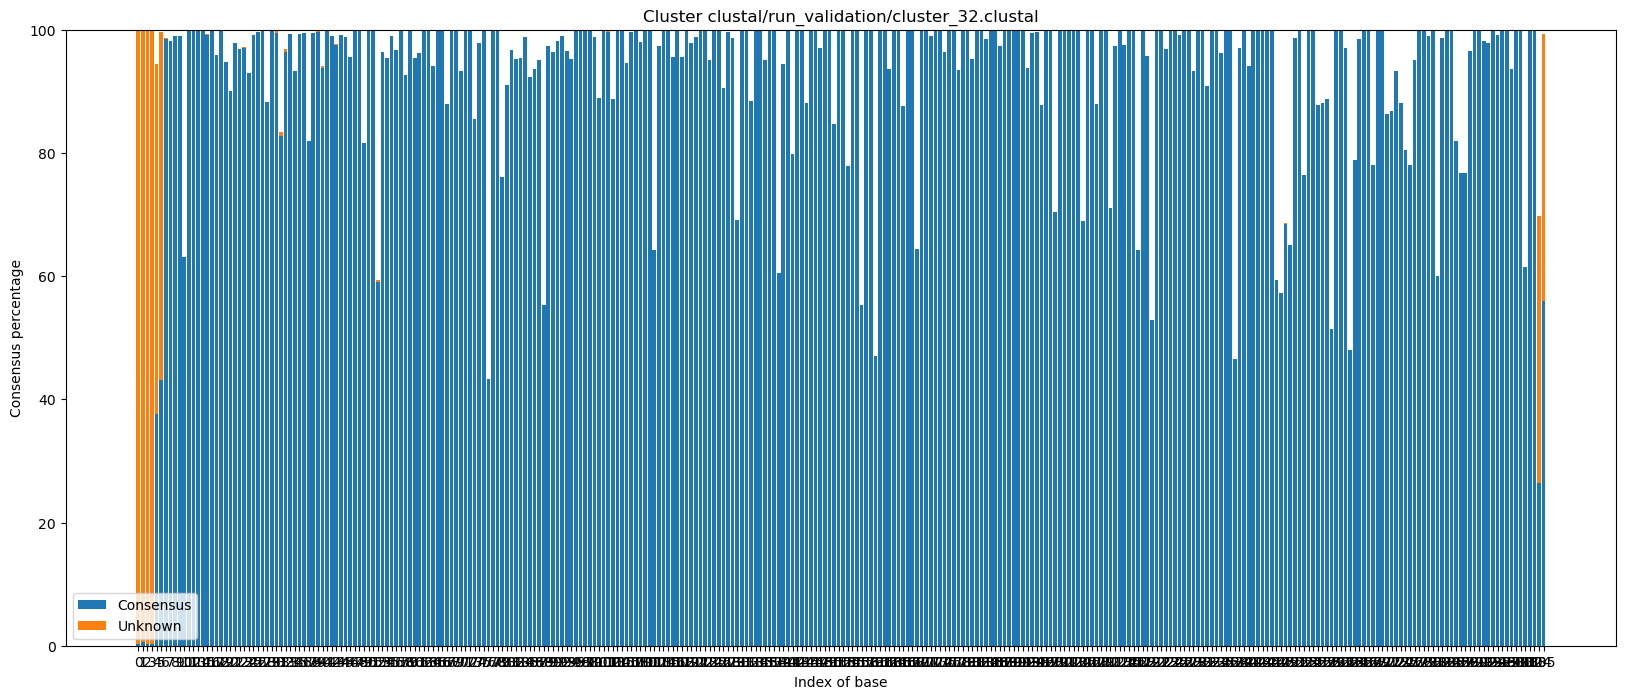

Plot for cluster 33


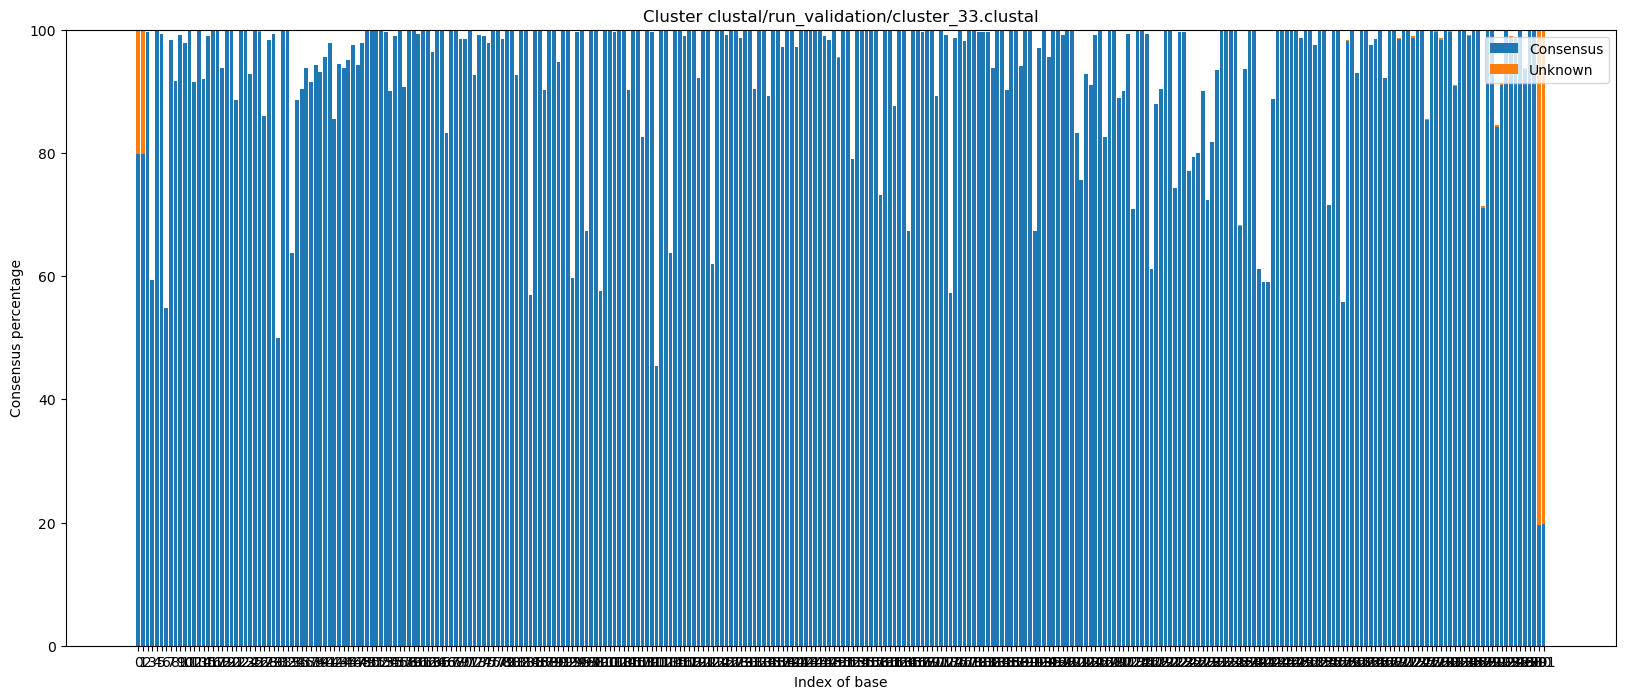

Plot for cluster 34


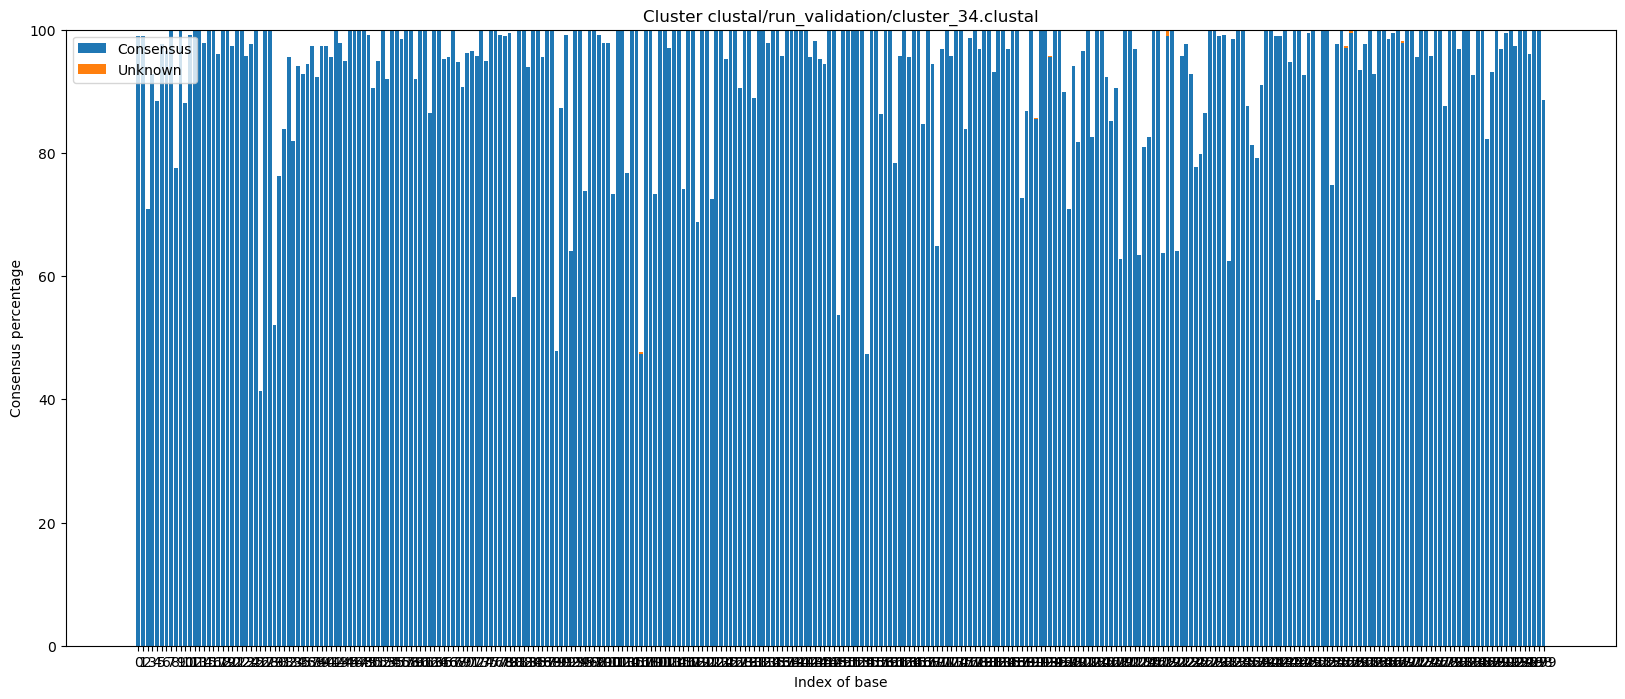

Plot for cluster 35


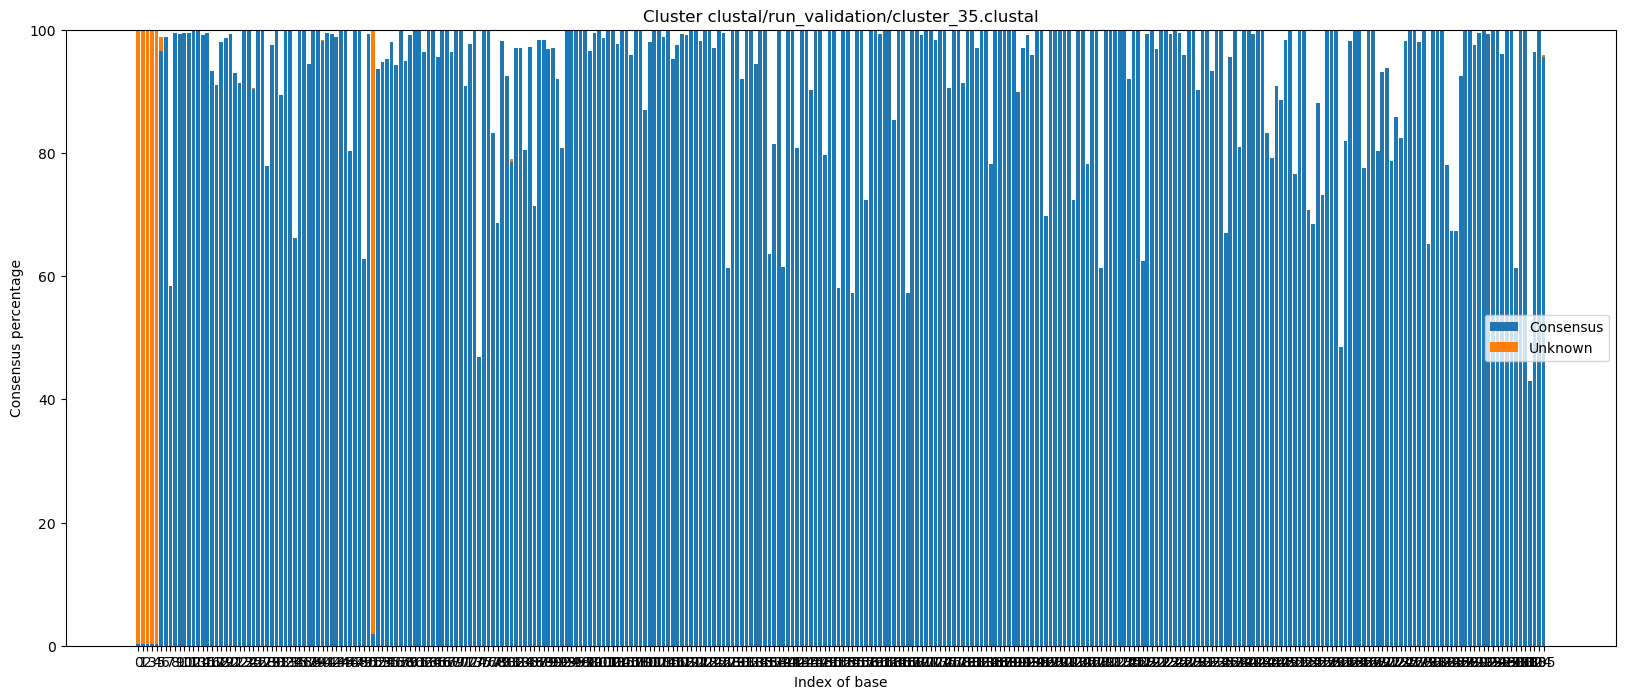

Plot for cluster 36


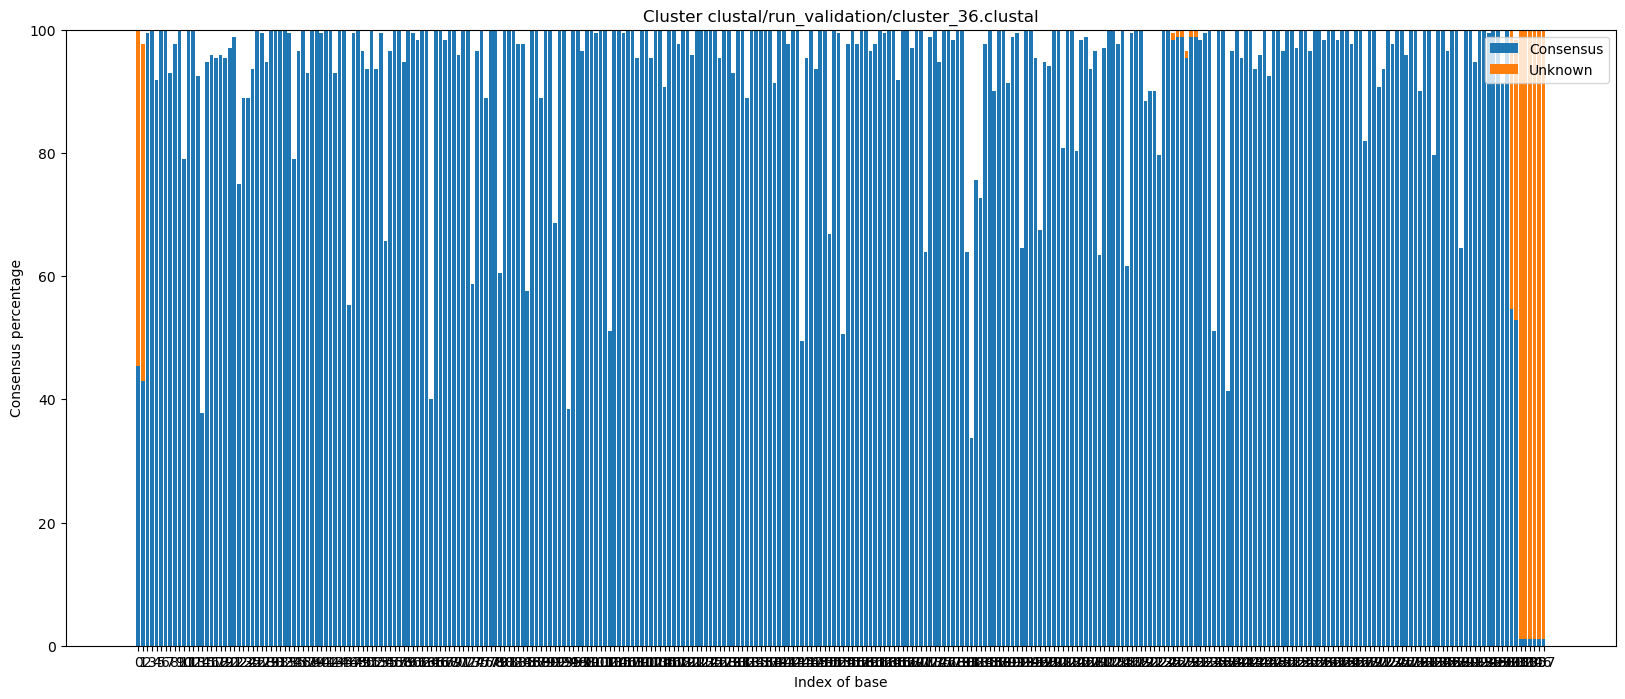

Plot for cluster 37


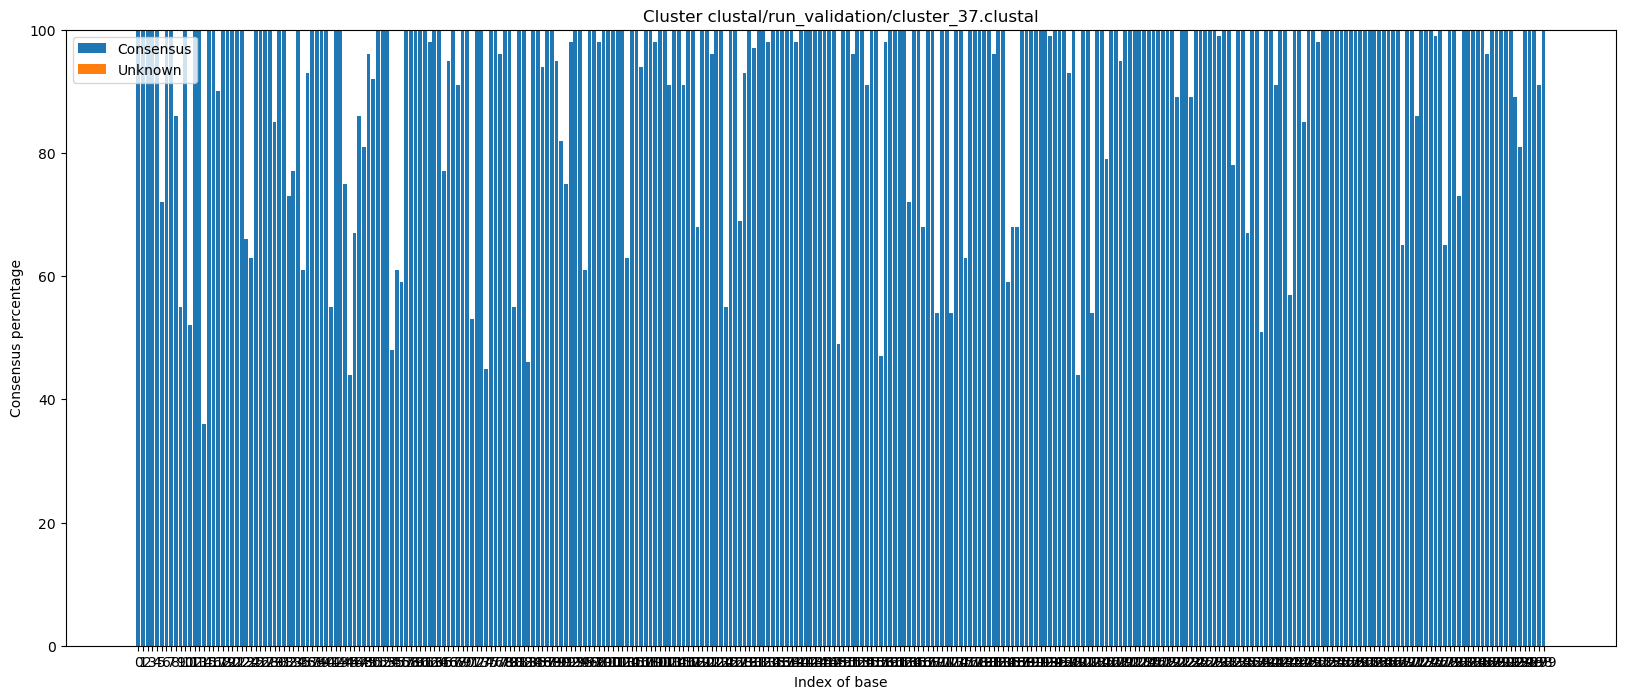

Plot for cluster 38


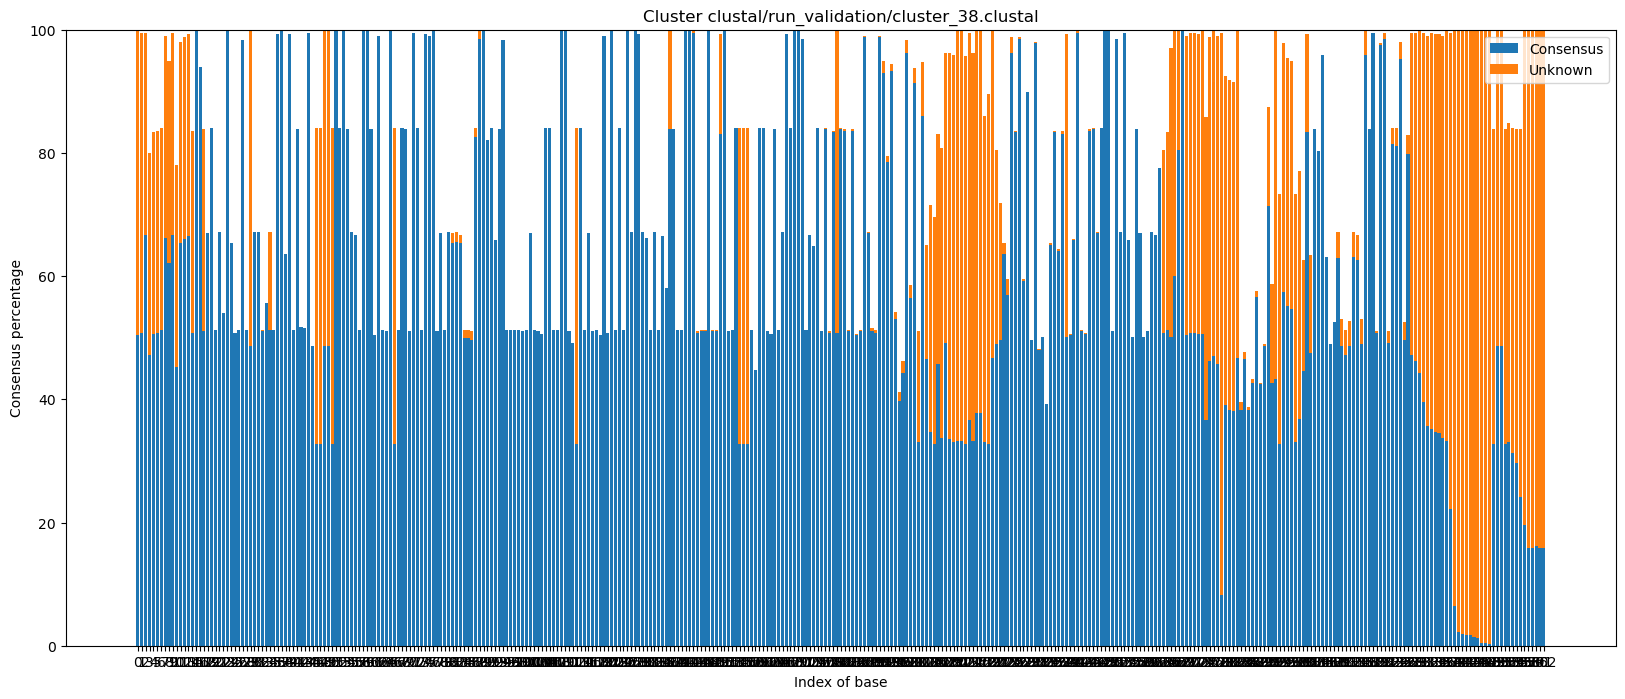

Plot for cluster 39


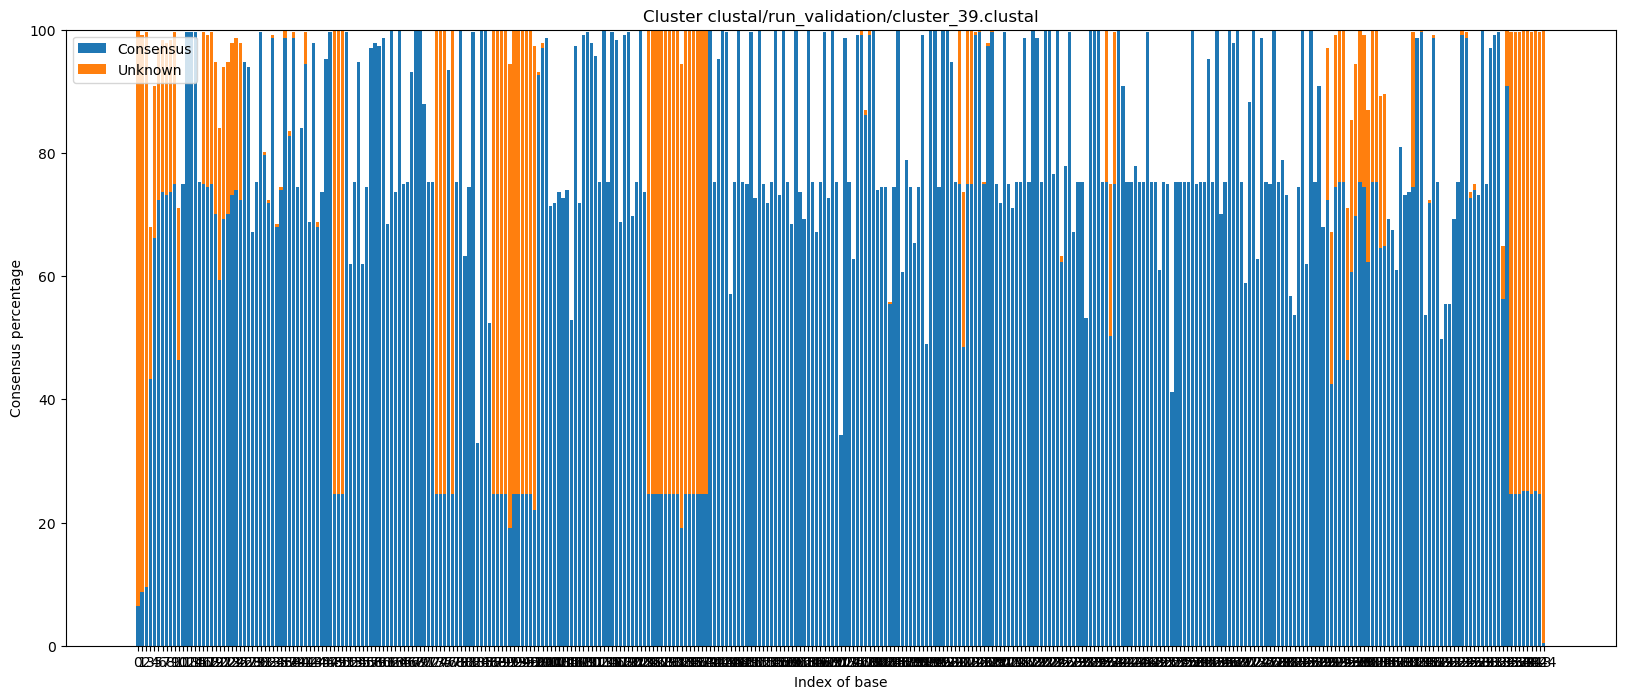

Plot for cluster 40


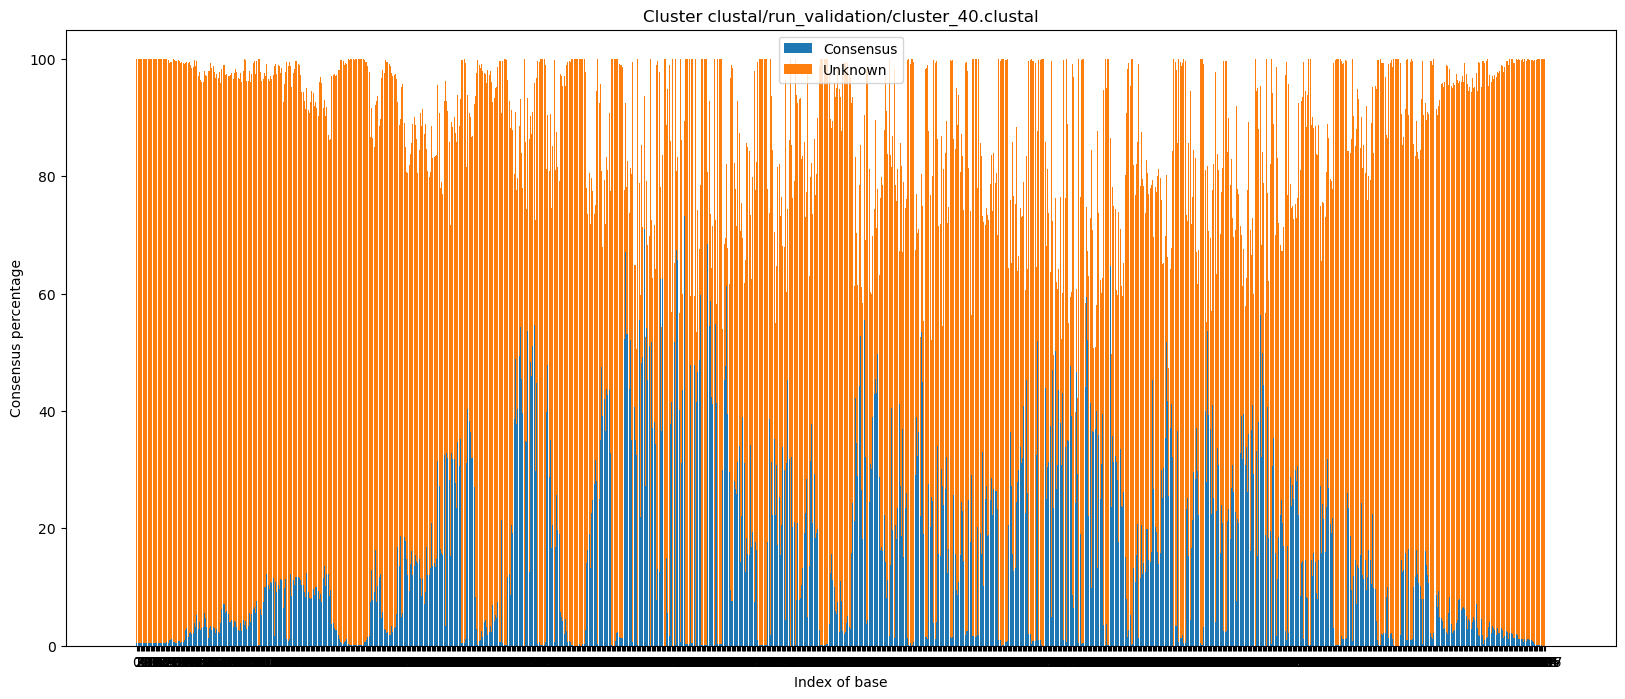

Plot for cluster 41


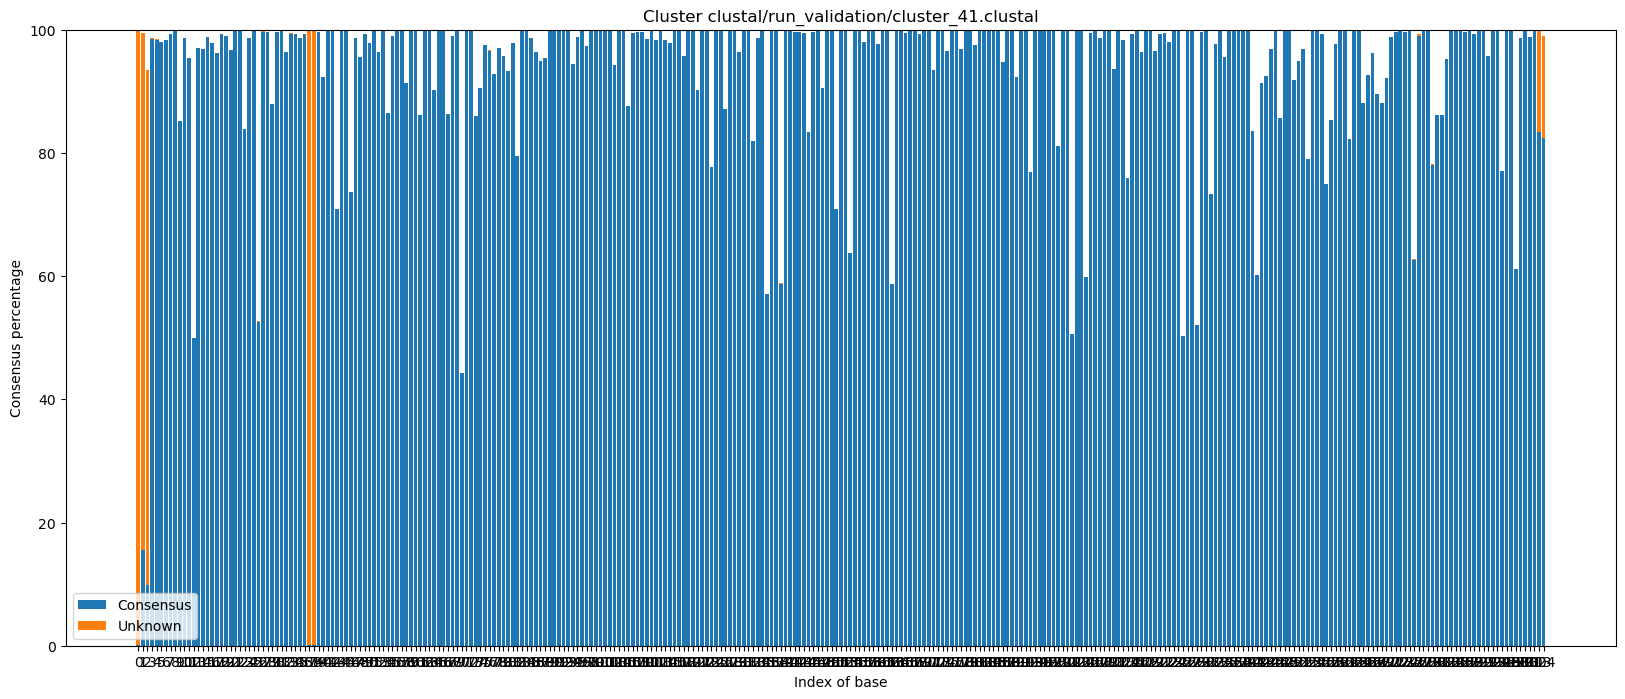

Plot for cluster 42


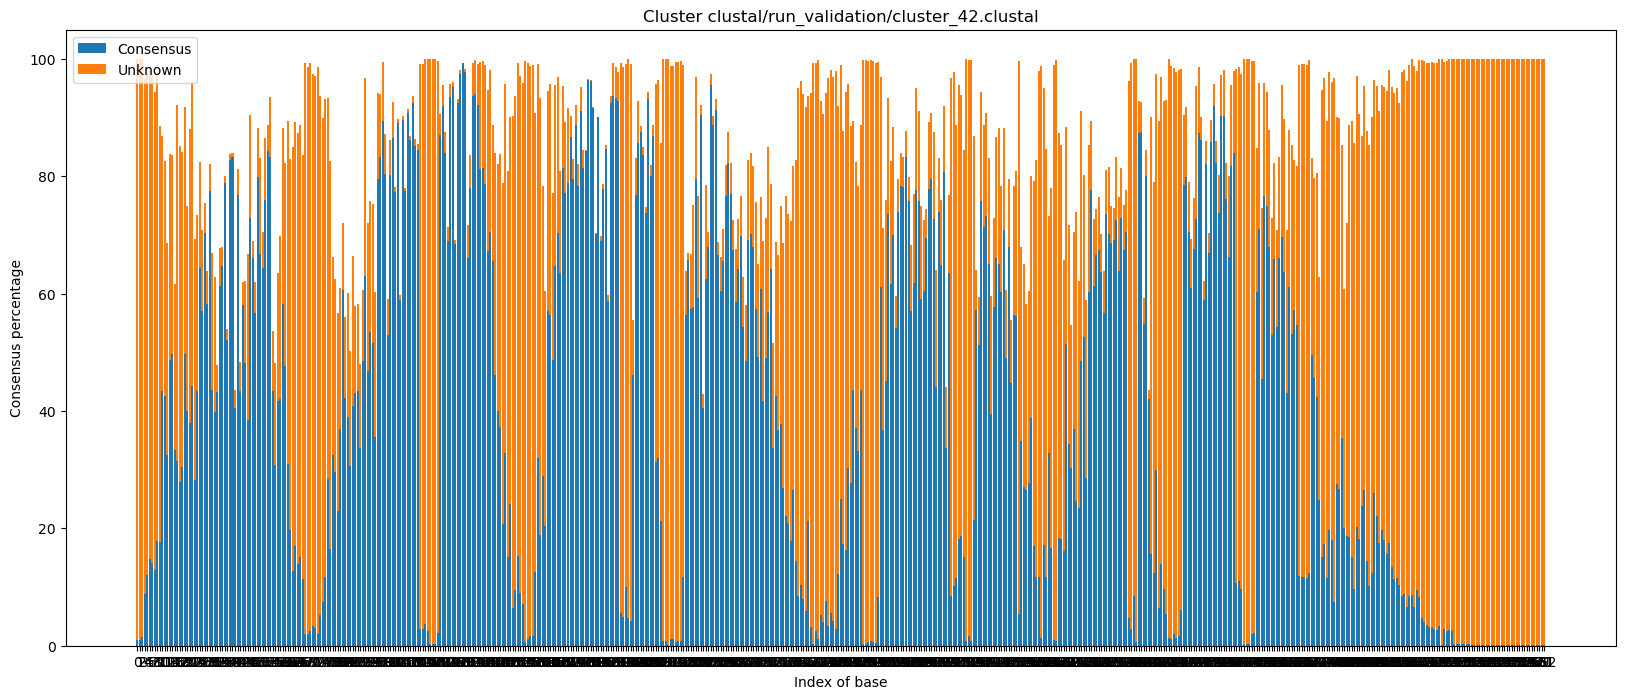

In [20]:
plotClusterRange(architecture_name, 0, num_clusters, unique_labels)

In [21]:
print(np.mean(percentages))
print(np.median(percentages))
print(np.std(percentages))

10.073609245678211
1.6695897885608497
19.077884722819707


In [22]:
scores, normalized_scores, sum_scores, div_scores = primerExtractionScoreOnModel(architecture_name, cluster_labels, unique_labels, stride=1)

In [23]:
print(scores)
print(normalized_scores)
print(sum_scores)
print(div_scores)

[100.0, 95.02925045703837, 96.33510074231177, 95.75327102803739, 97.99406528189911, 96.61924686192468, 97.48319327731092, 97.2036036036036, 95.82641509433962, 99.90839694656489, 0, 96.56551724137933, 96.40983606557377, 91.97122302158273, 88.39393939393939, 0, 95.12249443207126, 98.12026726057907, 97.0028409090909, 99.09316770186335, 96.16190476190478, 97.46177370030581, 98.42829076620825, 95.9192546583851, 85.62275449101796, 0, 96.85909090909091, 97.13170731707316, 72.81918819188192, 97.4, 75.99221789883268, 94.45405405405405, 96.71228070175438, 97.18471337579618, 96.77777777777777, 97.37757437070938, 97.75581395348837, 96.86, 72.19277108433735, 83.87878787878788, 0, 97.86127167630057, 67.69887640449438]
[0.4175  5.1981  2.2711  1.2807  1.6512  3.4638  1.16005 2.6974  1.2697
 0.9816  0.      1.4002  0.88215 0.6392  1.02095 0.      1.06775 1.1014
 1.70725 0.39885 1.51455 1.5935  1.2525  0.77215 1.4299  0.      1.06545
 0.9956  0.49335 0.3896  0.48825 0.43685 1.37815 1.14435 0.91455 1.06

In [24]:
np.count_nonzero(normalized_scores)/len(unique_labels)

0.9069767441860465